# **Installing libraries**

In [ ]:
#importing libraries
!pip install scikit-surprise
import pandas as pd
import numpy as np
from surprise import Dataset
from surprise import Reader
import math
import re

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
# pylab.rcParams[ 'figure.figsize' ] = 8 , 6

     |████████████████████████████████| 11.8MB 5.4MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670944 sha256=ffd1d6fa0d11997c4ee64e37b7e084e1d4dec6058b1dc2abb1fa6edf5985c4f6
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


# **References**

- Rishabh Misra, Mengting Wan, Julian McAuley Decomposing Fit Semantics for Product Size Recommendation in Metric Spaces. RecSys, 2018.
- Filling na by grouping by other column and taking mean in present column. [Link](https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group)


The **graphs** plotted in this file has been inspired from the work in the following notebooks:

- Kaggle notebook by Aditya Agarwal on ModCloth Dataset. [Link](https://www.kaggle.com/agrawaladitya/step-by-step-data-preprocessing-eda/notebook#Modcloth-Dataset)
- Kaggle notebook for beginners on ModCloth Dataset. [Link](https://www.kaggle.com/soujanyag/modcloth-data-preprocessing-for-beginner#Sparse-Data)
- Kaggle notebook for titanic used for plots referencing. [Link](https://www.kaggle.com/helgejo/an-interactive-data-science-tutorial)


# **Setting up helper functions**

In [ ]:
# DataFrame function takes in an iterable
# Inspired from notebook by Aditya Agarwal. Notebook Link given in references.
def findPercentageOfDataMissingInEachColumnOfDataframe(df, total):
    missingPercentageDataframe = pd.DataFrame({'numberOfCellsMissingValues':df.isnull().sum(), 'percentageMissing':(df.isnull().sum()*100)/total})
    missingPercentageDataframe = missingPercentageDataframe.sort_values(by=['percentageMissing'], ascending=False)
    print(missingPercentageDataframe)
    
# convert height from ft and inch to cm
# 1 ft = 30.48cm
# 1 inch = 2.54cm
# input value can be 5ft 6in or 5' 6"
def convertHeightIntoCm(value):
    # to handle nan which is of type float
    if isinstance(value,float):
        return value
    heightInCm=0.0
    splittedHeight = value.split()
    #ft part
    if(splittedHeight[0][-1] == "'"):
        heightInCm = int(splittedHeight[0][0:-1]) * 30.48
    else:
        heightInCm = int(splittedHeight[0][0:-2]) * 30.48
    #inch part
    if len(splittedHeight) > 1:
        if(splittedHeight[1][-1] == '"'):
            heightInCm = heightInCm + int(splittedHeight[1][0:-1]) * 2.54
        else:
            heightInCm = heightInCm + int(splittedHeight[1][0:-2]) * 2.54
#     print("Converted {} to {}".format(value,heightInCm))
    return round(heightInCm, 2)

# convert 57lbs to 57
def removeLBSfromWeight(value):
  if isinstance(value,float):
    return value
  return value[:-3]

def roundToNearestPointFive(value):
  if math.isnan(value):
    return value
  return round(value * 2) / 2

# imputing height by taking means of groups of different category of bra size, cup size & bust in increasing order of missing percentage
# Example take mean of height value where bra size is 34. Place that mean for na cells of height which have bra size 34.
# Example take mean of imputed_height value where shoe size is 34. Place that mean for na cells of imputed_height which have shoe size 34.
def imputeHeightForModCloth(df):
  df['imputed_height'] = df['height'].fillna(df.groupby('bra size')['height'].transform('mean'))
  df['imputed_height'] = df['imputed_height'].fillna(df.groupby('cup size')['height'].transform('mean'))
  df['imputed_height'] = df['imputed_height'].fillna(df.groupby('bust')['height'].transform('mean'))

  df['imputed_height'] = df['imputed_height'].fillna(df.groupby('shoe size')['height'].transform('mean'))
  df['imputed_height'] = df['imputed_height'].fillna(df.groupby('shoe width')['height'].transform('mean'))

  heightMeanValue = df['height'].mean()
  df['imputed_height'] = df['imputed_height'].fillna(heightMeanValue)
  return df

# Imputing shoe size by sequential grouping by imputed height, hips and bra size. This is in decreasing order of correlation with shoe size.
def imputeShoeSizeForModCloth(df):
  df['imputed_shoeSize'] = df['shoe size'].fillna(df.groupby('imputed_height')['shoe size'].transform('mean'))
  df['imputed_shoeSize'] = df['imputed_shoeSize'].fillna(df.groupby('hips')['shoe size'].transform('mean'))
  df['imputed_shoeSize'] = df['imputed_shoeSize'].fillna(df.groupby('bra size')['shoe size'].transform('mean'))

  shoeSizeMeanValue = df['shoe size'].mean()
  df['imputed_shoeSize'] = df['imputed_shoeSize'].fillna(shoeSizeMeanValue)
  df['imputed_shoeSize'] = df['imputed_shoeSize'].apply(roundToNearestPointFive)
  return df

# Since we have already imputed all shoe size, using it to group by and filling in with mode of each grouped category.
def imputeShoeWidthForModCloth(df):
  df['imputed_shoeWidth'] = df['shoe width'].fillna(df.groupby('imputed_shoeSize')['shoe width'].transform(lambda x: x.value_counts().index[0]))
  return df

# imputing height by taking means of groups of different category of body type, bust size & weight in increasing order of missing percentage
# Example take mean of height value where bra size is 34. Place that mean for na cells of height which have bra size 34.
# Example take mean of imputed_height value where shoe size is 34. Place that mean for na cells of imputed_height which have shoe size 34.
def imputeHeightForRentTheRunWay(df):
  df['imputed_height'] = df['height'].fillna(df.groupby('body type')['height'].transform('mean'))
  df['imputed_height'] = df['imputed_height'].fillna(df.groupby('bust size')['height'].transform('mean'))
  df['imputed_height'] = df['imputed_height'].fillna(df.groupby('weight')['height'].transform('mean'))

  heightMeanValue = df['height'].mean()
  df['imputed_height'] = df['imputed_height'].fillna(heightMeanValue)
  return df

def imputeWeightForRentTheRunWay(df):
  df['imputed_weight'] = df['weight'].fillna(df.groupby('size')['weight'].transform('mean'))
  df['imputed_weight'] = df['imputed_weight'].fillna(df.groupby('imputed_height')['weight'].transform('mean'))
  #check correlation between bust and weight and include it in computing weight

  weightMeanValue = df['weight'].mean()
  df['imputed_weight'] = df['imputed_weight'].fillna(weightMeanValue)
  return df

def imputeAgeForRentTheRunWay(df):
  ageMeanValue = df['age'].mean()
  df['age'] = df['age'].fillna(df.groupby('size')['age'].transform('mean'))
  df['age'] = df['age'].fillna(ageMeanValue)
  return df

def imputeHipsForModCloth(df):
  df['imputed_hips'] = df['hips'].fillna(df.groupby('size')['hips'].transform('mean'))
  return df



#imputing Bra Size by considering size and imputed hips.
def imputeBraSizeForModCloth(df):
  df['imputed_brasize'] = df['bra size'].fillna(df.groupby('size')['bra size'].transform('mean'))
  df['imputed_brasize'] = df['bra size'].fillna(df.groupby('imputed_hips')['bra size'].transform('mean'))
  braSizeMeanValue = df['bra size'].mean()
  df['imputed_brasize'] = df['imputed_brasize'].fillna(braSizeMeanValue)
  return df

#round odd bra sizes to even by adding 1 to them as suggested in referred mateiral
def roundToEvenBraSize(df):
  for i in range(len(df)) : 
    if df.loc[i, 'imputed_brasize'] % 2 !=0:
      df.loc[i, 'imputed_brasize'] = df.loc[i, 'imputed_brasize'] + 1
  return df
  
#imputing by grouping by bra size categories and finding out mode
def imputeCupSizeForModCloth(df):
  df['imputed_cupsize'] = df['cup size'].fillna(df.groupby('imputed_brasize')['cup size'].transform(lambda x: x.value_counts().index[0]))
  return df

#combine bra size and cup size to create new column
def combineBustSizeForModCloth(df):
  df['imputed_bustsize']=df['imputed_brasize'].str.cat(df['imputed_cupsize'], sep ="")
  return df

#imputing bust size by grouping categories and taking mode
def imputeBustSizeForRentTheRunWay(df):
  df['imputed_bustsize'] = df['bust size'].fillna(df.groupby('category')['bust size'].transform(lambda x: x.value_counts().index[0]))
  return df

#imputing bust sizes that are not currently in universal format
# d+ -> dd/e
# dd -> dd/e
# ddd/e -> ddd/f
# f -> ddd/f
def convertBustSizeForRentTheRunWay(df):
  for i in range(len(df)) :
    # print (df.loc[i, 'imputed_bustsize'])
    if re.search("d\+$", df.loc[i, 'imputed_bustsize']):
      # print('yes')
      df.loc[i,'imputed_bustsize'] = re.sub('(d\+)$', 'dd/e',df.loc[i,'imputed_bustsize'])  
    elif re.search("dd$", df.loc[i, 'imputed_bustsize']):
      # print('yes1')
      df.loc[i,'imputed_bustsize'] = re.sub('(dd)$', 'dd/e',df.loc[i,'imputed_bustsize'])
    elif re.search("ddd\/e$", df.loc[i, 'imputed_bustsize']):
      # print('yes2')
      df.loc[i,'imputed_bustsize'] = re.sub('(ddd\/e)$', 'ddd/f',df.loc[i,'imputed_bustsize'])
    elif re.search("f$", df.loc[i, 'imputed_bustsize']):
      # print('yes3')
      df.loc[i,'imputed_bustsize'] = re.sub('(f)$', 'ddd/f',df.loc[i,'imputed_bustsize'])
  return df 

def convertBustSizeToInches(df):
  for i in range(len(df)) :
    
    a=df.loc[i, 'imputed_bustsize']
    x=slice(0,2)
    y=slice(2,len(df.loc[i, 'imputed_bustsize']))
    cup=0
    if a[y]=="aa":
      cup=0
    elif a[y]=="a":
      cup=1
    elif a[y]=="b":
      cup=2
    elif a[y]=="c":
      cup=3
    elif a[y]=="d":
      cup=4
    elif a[y]=="dd/e":
      cup=5
    elif a[y]=="ddd/f":
      cup=6
    elif a[y]=="g":
      cup=7
    elif a[y]=="h":
      cup=8
    elif a[y]=="i":
      cup=9
    elif a[y]=="j":
      cup=10
    elif a[y]=="k":
      cup=11
    
    df.loc[i,'bustsize_in_inches']=int(a[x])+cup
  return df

def imputeLengthForModCloth(df):
  df['imputed_length'] = df['length'].fillna(df.groupby(['category','fit'])['length'].transform(lambda x: x.value_counts().index[0]))
  return df

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def frequencyCountByValue(df, col, datasetName ,ax):
    df[col][df[col].notnull()].value_counts().plot(kind='bar', facecolor='r', ax=ax)
    ax.set_xlabel('{}'.format(col), fontsize=18)
    ax.set_title("{} on {}".format(col, datasetName), fontsize= 18)
    return ax
  
# All the plot functions below have been inspired from the 3 Kaggle notebooks whose access link have been given in reference.
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    hue = kwargs.get( 'hue' , None )
    facet = sns.FacetGrid( df , hue=hue , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , target ,shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    hue = kwargs.get( 'hue' , None )
    facet = sns.FacetGrid( df , aspect=6 , row = row , col = col,hue = hue )
    facet.map( sns.barplot , cat , target)
    facet.set_xticklabels(rotation=90)
    facet.add_legend()

def plot_barh(df,col, cmap = None, stacked=False, norm = None):
    df.plot(kind='barh', colormap=cmap, stacked=stacked)
    fig = plt.gcf()
    fig.set_size_inches(24,12)
    plt.title("Category vs {}-feedback -  Modcloth {}".format(col, '(Normalized)' if norm else ''), fontsize= 20)
    plt.ylabel('Category', fontsize = 18)
    plot = plt.xlabel('Frequency', fontsize=18)

def plot_barhRR(df,col, cmap = None, stacked=False, norm = None):
    df.plot(kind='barh', colormap=cmap, stacked=stacked)
    fig = plt.gcf()
    fig.set_size_inches(24,12)
    plt.title("Category vs {}-feedback -  Rent the Runway  {}".format(col, '(Normalized)' if norm else ''), fontsize= 20)
    plt.ylabel('Category', fontsize = 18)
    plot = plt.xlabel('Frequency', fontsize=18)
    
def norm_counts(t):
    norms = np.linalg.norm(t.fillna(0), axis=1)
    t_norm = t[0:0]
    for row, euc in zip(t.iterrows(), norms):
        t_norm.loc[row[0]] = list(map(lambda x: x/euc, list(row[1])))
    return t_norm

In [ ]:
def imputeBodyType(df):
  df['imputed_bodyType'] = df['body type'].fillna(df.groupby('size')['body type'].transform(lambda x: x.value_counts().index[0]))
  return df

def plotFactorPlot(arr):
  vars = arr
  for variable in vars:
      var_df = data_renttherunway_df.groupby(variable)["binary_rating"].agg(["mean", "count"]).reset_index()
      var_df.sort_values(["mean"], ascending = False, inplace = True)
      sns.factorplot(y  = variable, x = "mean", 
                    orient = "h", 
                    hue = "count",
                    palette = "Set2",
                    size = 3, aspect = 3,
                    data = var_df)
      plt.title(variable + " " + "binary rating Plot")

# **Mounting Personal Google Drive**

I have stored the dataset files in my private Google Drive. The way to mount google drive on Google colab was studied from the Colab's [getting started tutorial](https://colab.research.google.com/notebooks/io.ipynb).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Reading [ModCloth](https://www.modcloth.com/) Data**

ModCloth sells women’s vintage clothing and accessories. The data was collected when user's purchased an item from category such as tops, bottoms, dresses etc. Additionally, when user returned an item, the reason was asked, and thus that transaction is included in the data too.

In [ ]:
# There is one JSON object per line, and there are multiple lines, so reading entire file as one object per line
data_modcloth_df=pd.read_json('/content/drive/My Drive/CMPE256_CourseProjectShortcut/CMPE256_CourseProject/Datasets/modcloth.json', lines=True)
data_modcloth_df.head()

item_id  waist  size  ...  shoe width review_summary  review_text
0   123373   29.0     7  ...         NaN            NaN          NaN
1   123373   31.0    13  ...         NaN            NaN          NaN
2   123373   30.0     7  ...         NaN            NaN          NaN
3   123373    NaN    21  ...         NaN            NaN          NaN
4   123373    NaN    18  ...         NaN            NaN          NaN

[5 rows x 18 columns]

In [ ]:
data_modcloth_df.iloc[0]
# data_modcloth_df.groupby('bra size')['height'].mean()

item_id               123373
waist                     29
size                       7
quality                    5
cup size                   d
hips                      38
bra size                  34
category                 new
bust                      36
height               5ft 6in
user_name              Emily
length            just right
fit                    small
user_id               991571
shoe size                NaN
shoe width               NaN
review_summary           NaN
review_text              NaN
Name: 0, dtype: object

In [ ]:
# dataframe.describe gives information of numerical variables of dataframe
data_modcloth_df.describe()

item_id        waist  ...        user_id     shoe size
count   82790.000000  2882.000000  ...   82790.000000  27915.000000
mean   469325.229170    31.319223  ...  498849.564718      8.145818
std    213999.803314     5.302849  ...  286356.969459      1.336109
min    123373.000000    20.000000  ...       6.000000      5.000000
25%    314980.000000    28.000000  ...  252897.750000      7.000000
50%    454030.000000    30.000000  ...  497913.500000      8.000000
75%    658440.000000    34.000000  ...  744745.250000      9.000000
max    807722.000000    50.000000  ...  999972.000000     38.000000

[8 rows x 8 columns]

In [ ]:
# dataframe.info gives information about column type and non null count
data_modcloth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         82790 non-null  int64  
 1   waist           2882 non-null   float64
 2   size            82790 non-null  int64  
 3   quality         82722 non-null  float64
 4   cup size        76535 non-null  object 
 5   hips            56064 non-null  float64
 6   bra size        76772 non-null  float64
 7   category        82790 non-null  object 
 8   bust            11854 non-null  object 
 9   height          81683 non-null  object 
 10  user_name       82790 non-null  object 
 11  length          82755 non-null  object 
 12  fit             82790 non-null  object 
 13  user_id         82790 non-null  int64  
 14  shoe size       27915 non-null  float64
 15  shoe width      18607 non-null  object 
 16  review_summary  76065 non-null  object 
 17  review_text     76065 non-null 

In [ ]:
data_modcloth_df.shape[0]

82790

In [ ]:
findPercentageOfDataMissingInEachColumnOfDataframe(data_modcloth_df, data_modcloth_df.shape[0])

                numberOfCellsMissingValues  percentageMissing
waist                                79908          96.518903
bust                                 70936          85.681846
shoe width                           64183          77.525063
shoe size                            54875          66.282160
hips                                 26726          32.281677
review_text                           6725           8.122962
review_summary                        6725           8.122962
cup size                              6255           7.555260
bra size                              6018           7.268994
height                                1107           1.337118
quality                                 68           0.082136
length                                  35           0.042276
user_name                                0           0.000000
fit                                      0           0.000000
user_id                                  0           0.000000
category

### Initial frequency distribution of features in ModCloth dataset

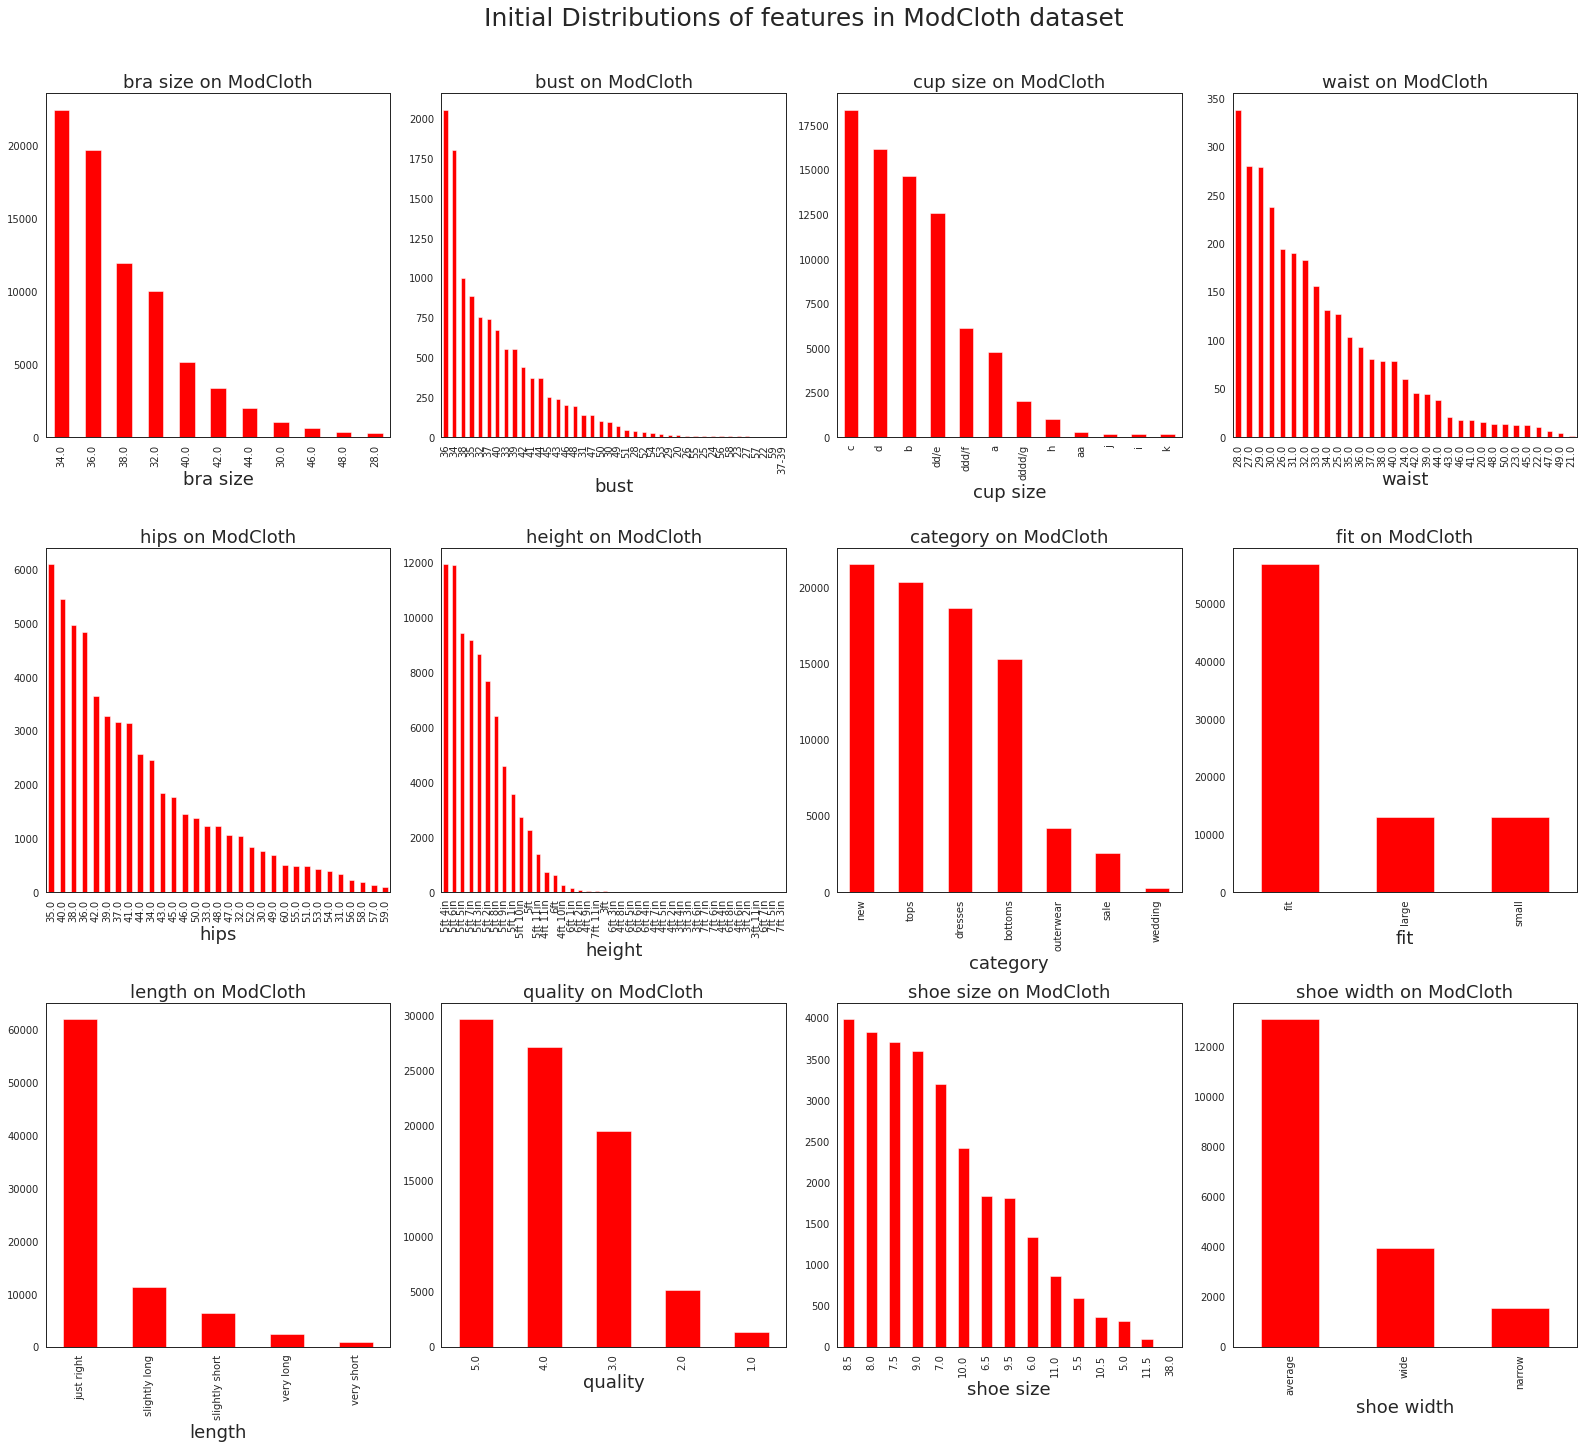

In [ ]:
f, ax = plt.subplots(3,4, figsize = (22,20))
f.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = ['bra size','bust','cup size','waist','hips','height','category','fit','length', 'quality','shoe size','shoe width']
k = 0
for i in range(3):
    for j in range(4):
        frequencyCountByValue(data_modcloth_df, cols[k],'ModCloth',ax[i][j])
        k += 1
__ = plt.suptitle("Initial Distributions of features in ModCloth dataset", fontsize= 25)

# **Reading [RentTheRunWay](https://www.renttherunway.com/) Data**

RentTheRunWay provides a unique platform for women to rent clothes for various occasions. The collected data contains items from several categories.

In [ ]:
# There is one JSON object per line, and there are multiple lines, so reading entire file as one object per line
data_renttherunway_df=pd.read_json('/content/drive/My Drive/CMPE256_CourseProjectShortcut/CMPE256_CourseProject/Datasets/renttherunway.json', lines=True)
data_renttherunway_df.head()

fit  user_id bust size  item_id  ... height  size    age         review_date
0  fit   420272       34d  2260466  ...  5' 8"    14   28.0      April 20, 2016
1  fit   273551       34b   153475  ...  5' 6"    12   36.0       June 18, 2013
2  fit   360448       NaN  1063761  ...  5' 4"     4  116.0   December 14, 2015
3  fit   909926       34c   126335  ...  5' 5"     8   34.0   February 12, 2014
4  fit   151944       34b   616682  ...  5' 9"    12   27.0  September 26, 2016

[5 rows x 15 columns]

In [ ]:
# dataframe.describe gives information of numerical variables of dataframe
data_renttherunway_df.describe()

user_id       item_id         rating           size            age
count  192544.000000  1.925440e+05  192462.000000  192544.000000  191584.000000
mean   499494.100149  1.045684e+06       9.092371      12.245175      33.871017
std    289059.719328  8.053148e+05       1.430044       8.494877       8.058083
min         9.000000  1.233730e+05       2.000000       0.000000       0.000000
25%    250654.250000  1.950760e+05       8.000000       8.000000      29.000000
50%    499419.000000  9.483960e+05      10.000000      12.000000      32.000000
75%    750974.000000  1.678888e+06      10.000000      16.000000      37.000000
max    999997.000000  2.966087e+06      10.000000      58.000000     117.000000

In [ ]:
# dataframe.info gives information about column type and non null count
data_renttherunway_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   fit             192544 non-null  object 
 1   user_id         192544 non-null  int64  
 2   bust size       174133 non-null  object 
 3   item_id         192544 non-null  int64  
 4   weight          162562 non-null  object 
 5   rating          192462 non-null  float64
 6   rented for      192534 non-null  object 
 7   review_text     192544 non-null  object 
 8   body type       177907 non-null  object 
 9   review_summary  192544 non-null  object 
 10  category        192544 non-null  object 
 11  height          191867 non-null  object 
 12  size            192544 non-null  int64  
 13  age             191584 non-null  float64
 14  review_date     192544 non-null  object 
dtypes: float64(2), int64(3), object(10)
memory usage: 22.0+ MB


In [ ]:
data_renttherunway_df.shape[0]

192544

In [ ]:
findPercentageOfDataMissingInEachColumnOfDataframe(data_renttherunway_df, data_renttherunway_df.shape[0])

                numberOfCellsMissingValues  percentageMissing
weight                               29982          15.571506
bust size                            18411           9.561970
body type                            14637           7.601899
age                                    960           0.498587
height                                 677           0.351608
rating                                  82           0.042588
rented for                              10           0.005194
fit                                      0           0.000000
user_id                                  0           0.000000
item_id                                  0           0.000000
review_text                              0           0.000000
review_summary                           0           0.000000
category                                 0           0.000000
size                                     0           0.000000
review_date                              0           0.000000


### Initial frequency distribution of features in RentTheRunWay dataset

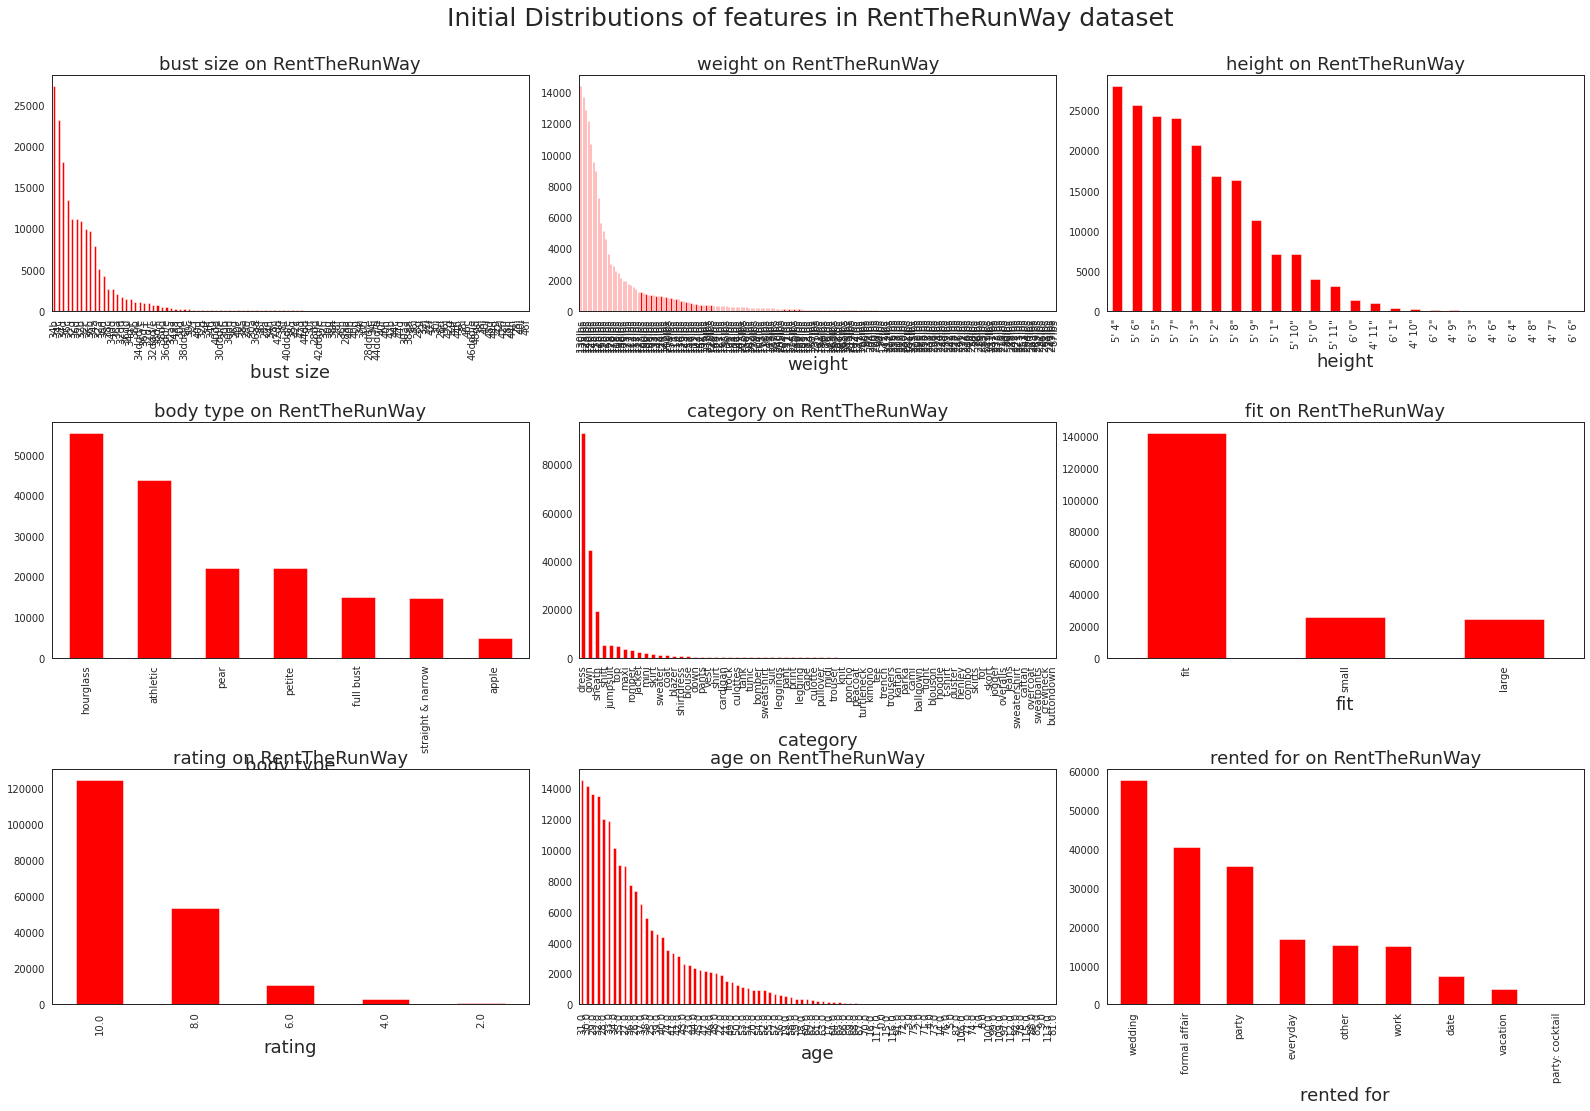

In [ ]:
f, ax = plt.subplots(3,3, figsize = (22,15))
f.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])
cols = ['bust size','weight','height','body type','category','fit','rating','age','rented for']
k = 0
for i in range(3):
    for j in range(3):
        frequencyCountByValue(data_renttherunway_df, cols[k],'RentTheRunWay',ax[i][j])
        k += 1
__ = plt.suptitle("Initial Distributions of features in RentTheRunWay dataset", fontsize= 25)

# **Data processing**

## **Height visualizations and processing**

#### ModCloth

In [ ]:
data_modcloth_df['height'] = data_modcloth_df['height'].apply(convertHeightIntoCm)

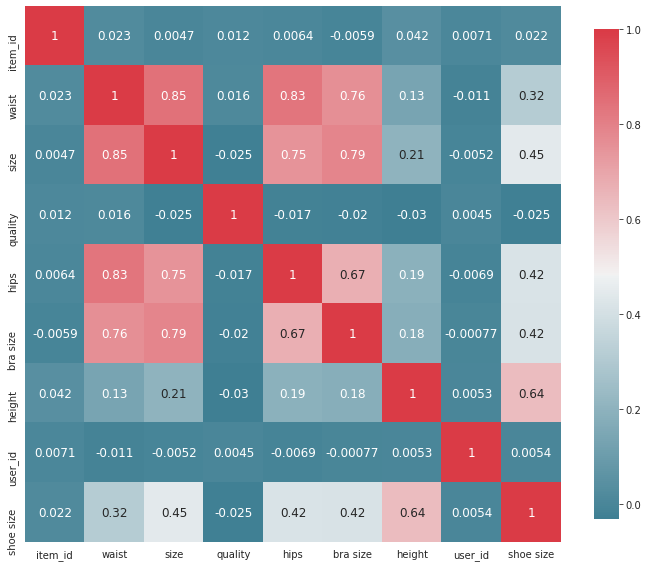

In [ ]:
plot_correlation_map(data_modcloth_df)

In [ ]:
data_modcloth_df[data_modcloth_df.height.isnull()].shape[0]

1107

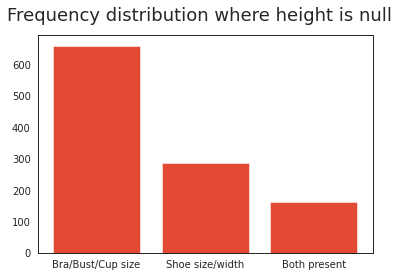

In [ ]:
heightNullCount = data_modcloth_df[data_modcloth_df.height.isnull()].shape[0]
heightNull_braBustCupNotNullCount = data_modcloth_df[data_modcloth_df.height.isnull() & (data_modcloth_df['bra size'].notnull() | data_modcloth_df['cup size'].notnull() | data_modcloth_df['bust'].notnull()) & (data_modcloth_df['shoe size'].isnull() & data_modcloth_df['shoe width'].isnull())].shape[0]
heightNull_shoeSizeWidthNotNullCount = data_modcloth_df[data_modcloth_df.height.isnull() & (data_modcloth_df['bra size'].isnull() & data_modcloth_df['cup size'].isnull() & data_modcloth_df['bust'].isnull()) & (data_modcloth_df['shoe size'].notnull() | data_modcloth_df['shoe width'].notnull())].shape[0]
heightNull_braBustCupShoeSizeWidthNotNullCount = heightNullCount - heightNull_braBustCupNotNullCount - heightNull_shoeSizeWidthNotNullCount

counts = [heightNull_braBustCupNotNullCount, heightNull_shoeSizeWidthNotNullCount, heightNull_braBustCupShoeSizeWidthNotNullCount]
barNames = ['Bra/Bust/Cup size', 'Shoe size/width', 'Both present']
y_pos = np.arange(len(barNames))
plt.bar(y_pos, counts)
plt.xticks(y_pos, barNames)
plt.suptitle("Frequency distribution where height is null", fontsize= 18)
plt.show()

Seeing the above graph, we have 1107 rows where height is null. 

- 659 rows has values for bust measurements and not for shoe, thus implying those were items shopped for lingerie. 
- 287 rows has values for shoe measurements and not for bust, thus implying those were items shopped for shoes.
- 161 rows has values for either bust or shoes or both. So those items could be anything.

In [ ]:
data_modcloth_df = imputeHeightForModCloth(data_modcloth_df)
data_modcloth_df = data_modcloth_df.round({'imputed_height':2})

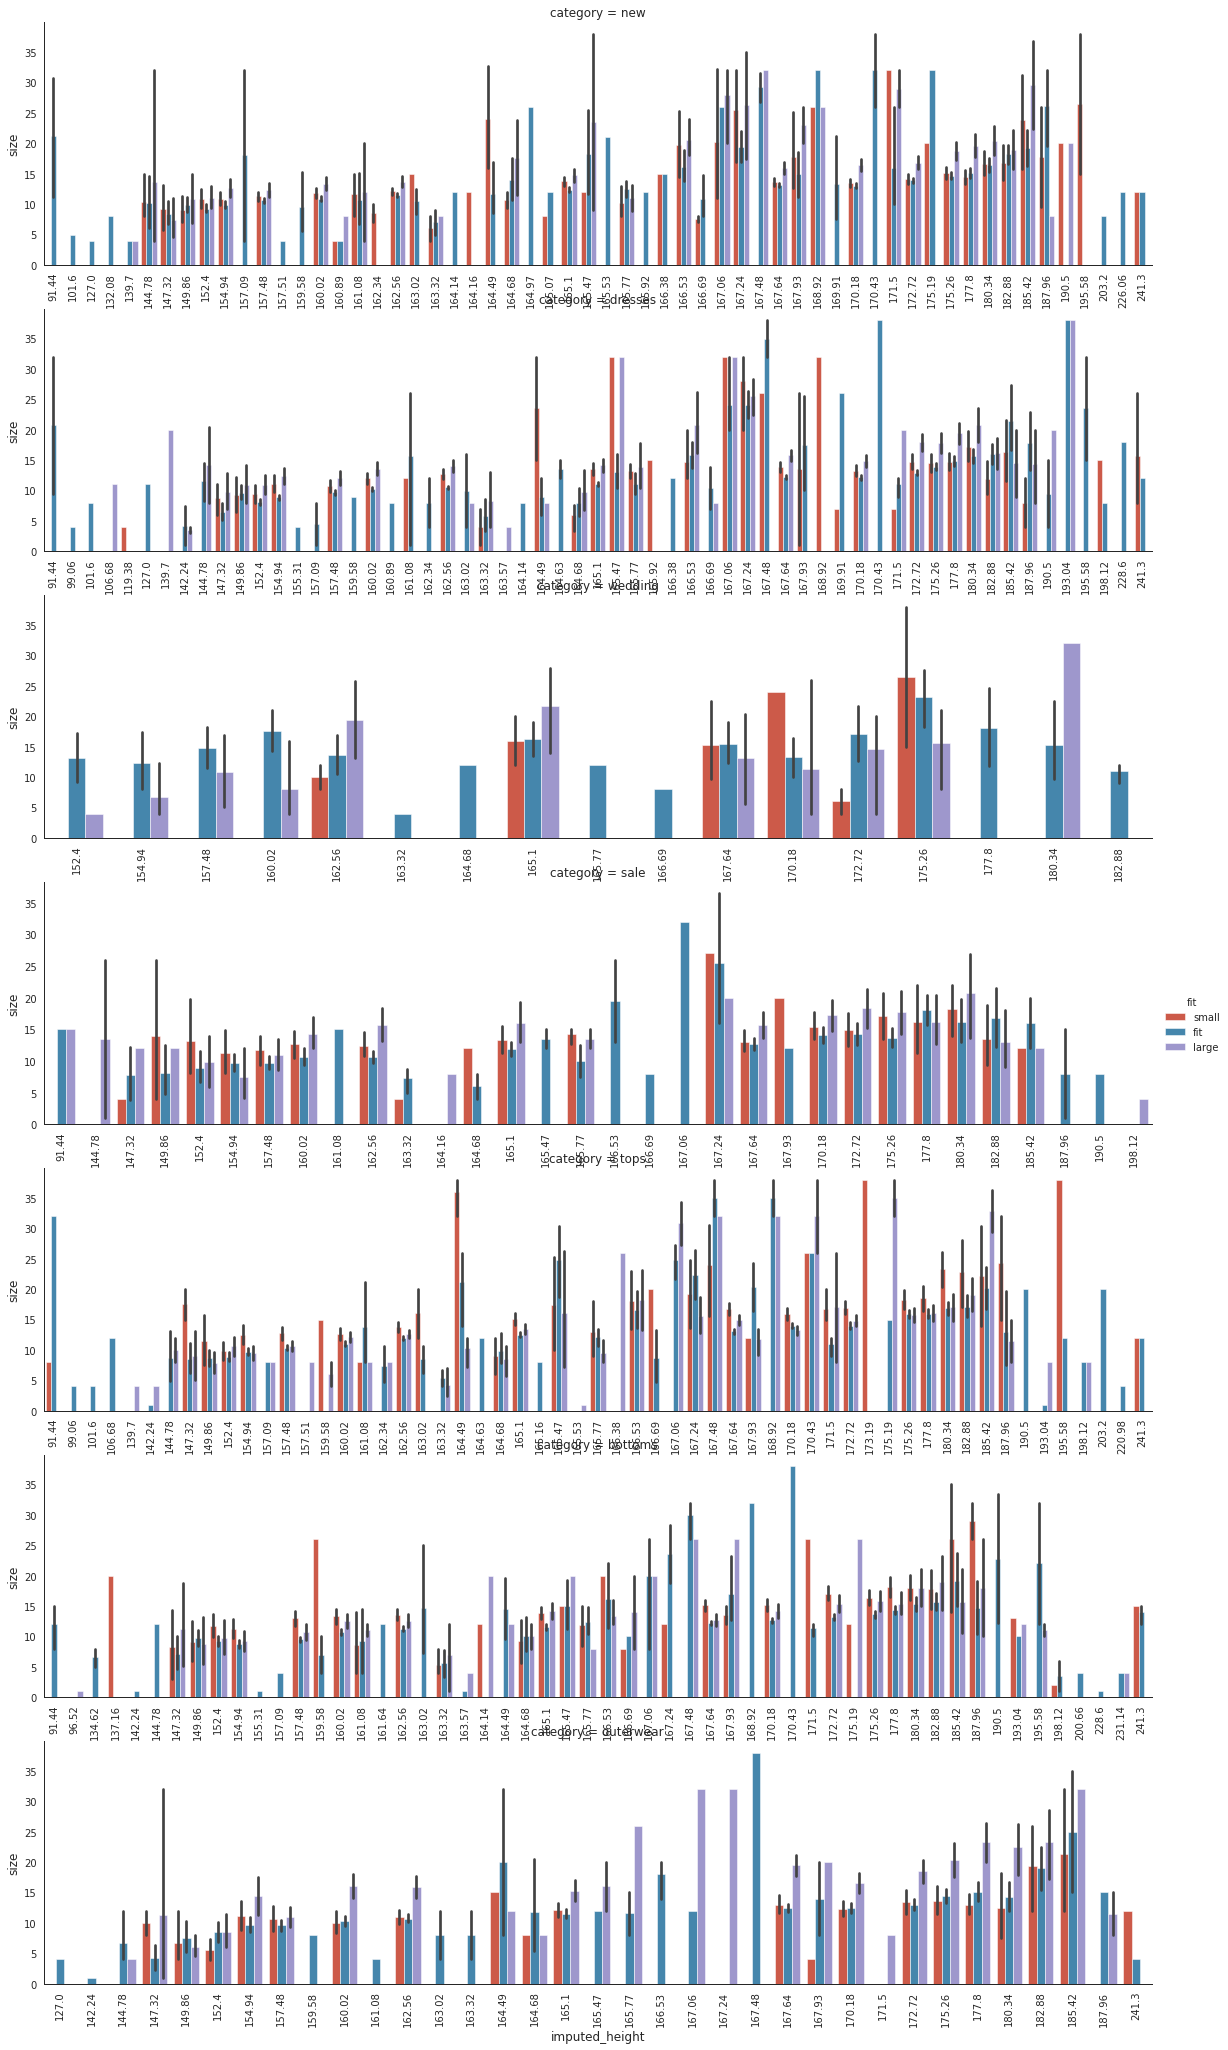

In [ ]:
# only considering heights which have data in all categories.
# Relationship between height, size, category and fit feedback
# plot_categories( data_modcloth_df , cat = 'imputed_height' , target = 'size', row = 'category', hue='fit' )
g = sns.catplot(data=data_modcloth_df, x='imputed_height', y='size', kind='bar', row='category', hue='fit', height=4, aspect=4, sharey=False, sharex=False)
g.set_xticklabels(rotation=90)

Looking into the above graphs for **user's height, category, fit feedback and ordered size**, we can make following observations for users in their height category according to their given fit feedback:

- Users buy large size as seen in all categories.
- Outerwear, dresses, new and tops have users in their height group ordering large sizes in majority.
- In sale, tops & bottoms, in their respective height scale, as height increases, users size purchases are "small" as compared to other fit categories.

#### RentTheRunWay

In [ ]:
data_renttherunway_df['height'] = data_renttherunway_df['height'].apply(convertHeightIntoCm)
data_renttherunway_df.head()

fit  user_id bust size  item_id  ...  height  size    age         review_date
0  fit   420272       34d  2260466  ...  172.72    14   28.0      April 20, 2016
1  fit   273551       34b   153475  ...  167.64    12   36.0       June 18, 2013
2  fit   360448       NaN  1063761  ...  162.56     4  116.0   December 14, 2015
3  fit   909926       34c   126335  ...  165.10     8   34.0   February 12, 2014
4  fit   151944       34b   616682  ...  175.26    12   27.0  September 26, 2016

[5 rows x 15 columns]

Removing lbs from weight column and making it float type

In [ ]:
data_renttherunway_df['weight'] = data_renttherunway_df['weight'].apply(removeLBSfromWeight)
data_renttherunway_df['weight'] = data_renttherunway_df['weight'].astype(float)

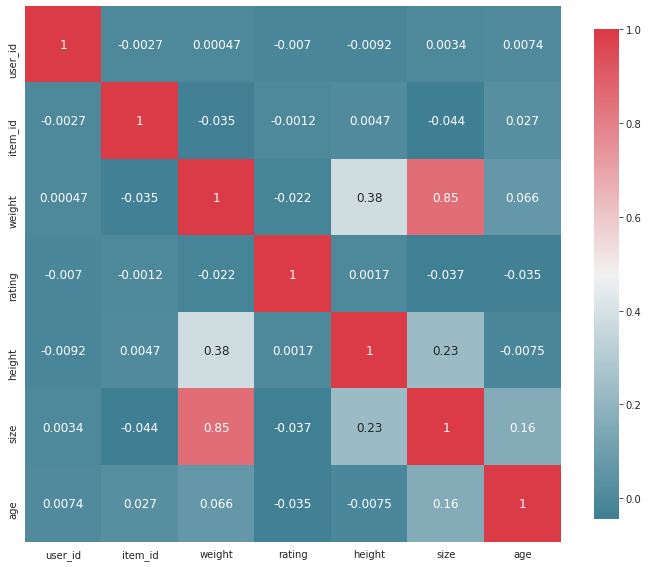

In [ ]:
# There is 0.38 correlation between height and weight
plot_correlation_map(data_renttherunway_df)

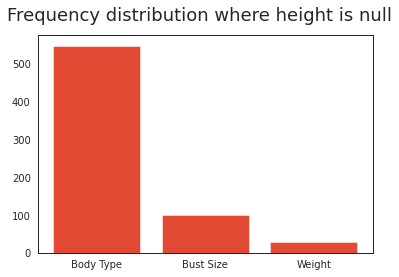

In [ ]:
heightNullCount = data_renttherunway_df[data_renttherunway_df.height.isnull()].shape[0]
heightNull_bodyTypeNotNullCount = data_renttherunway_df[data_renttherunway_df.height.isnull() & data_renttherunway_df['body type'].notnull()].shape[0]
heightNull_bustSizeNotNullCount = data_renttherunway_df[data_renttherunway_df.height.isnull() & data_renttherunway_df['body type'].isnull() & data_renttherunway_df['bust size'].notnull()].shape[0]
heightNull_weightNotNullCount = data_renttherunway_df[data_renttherunway_df.height.isnull() & data_renttherunway_df['body type'].isnull() & data_renttherunway_df['bust size'].isnull() & data_renttherunway_df['weight'].notnull()].shape[0]

counts = [heightNull_bodyTypeNotNullCount, heightNull_bustSizeNotNullCount, heightNull_weightNotNullCount]
barNames = ['Body Type', 'Bust Size', 'Weight']
y_pos = np.arange(len(barNames))
plt.bar(y_pos, counts)
plt.xticks(y_pos, barNames)
plt.suptitle("Frequency distribution where height is null", fontsize= 18)
plt.show()

Seeing the above graph, we have 677 rows where height is null.

- 548 rows has values for body type.
- 100 rows has values for bust size and not for body type.
- 29 rows has values for weight and not for body type and bust size.

In [ ]:
# imputing values for height using other user body measurements - body type, bust size & weight - in inc. order of missing percentage
data_renttherunway_df = imputeHeightForRentTheRunWay(data_renttherunway_df)
data_renttherunway_df = data_renttherunway_df.round({'imputed_height':2})

In [ ]:
temp_df = data_renttherunway_df.groupby('imputed_height')['category'].value_counts().unstack(fill_value=0).stack()

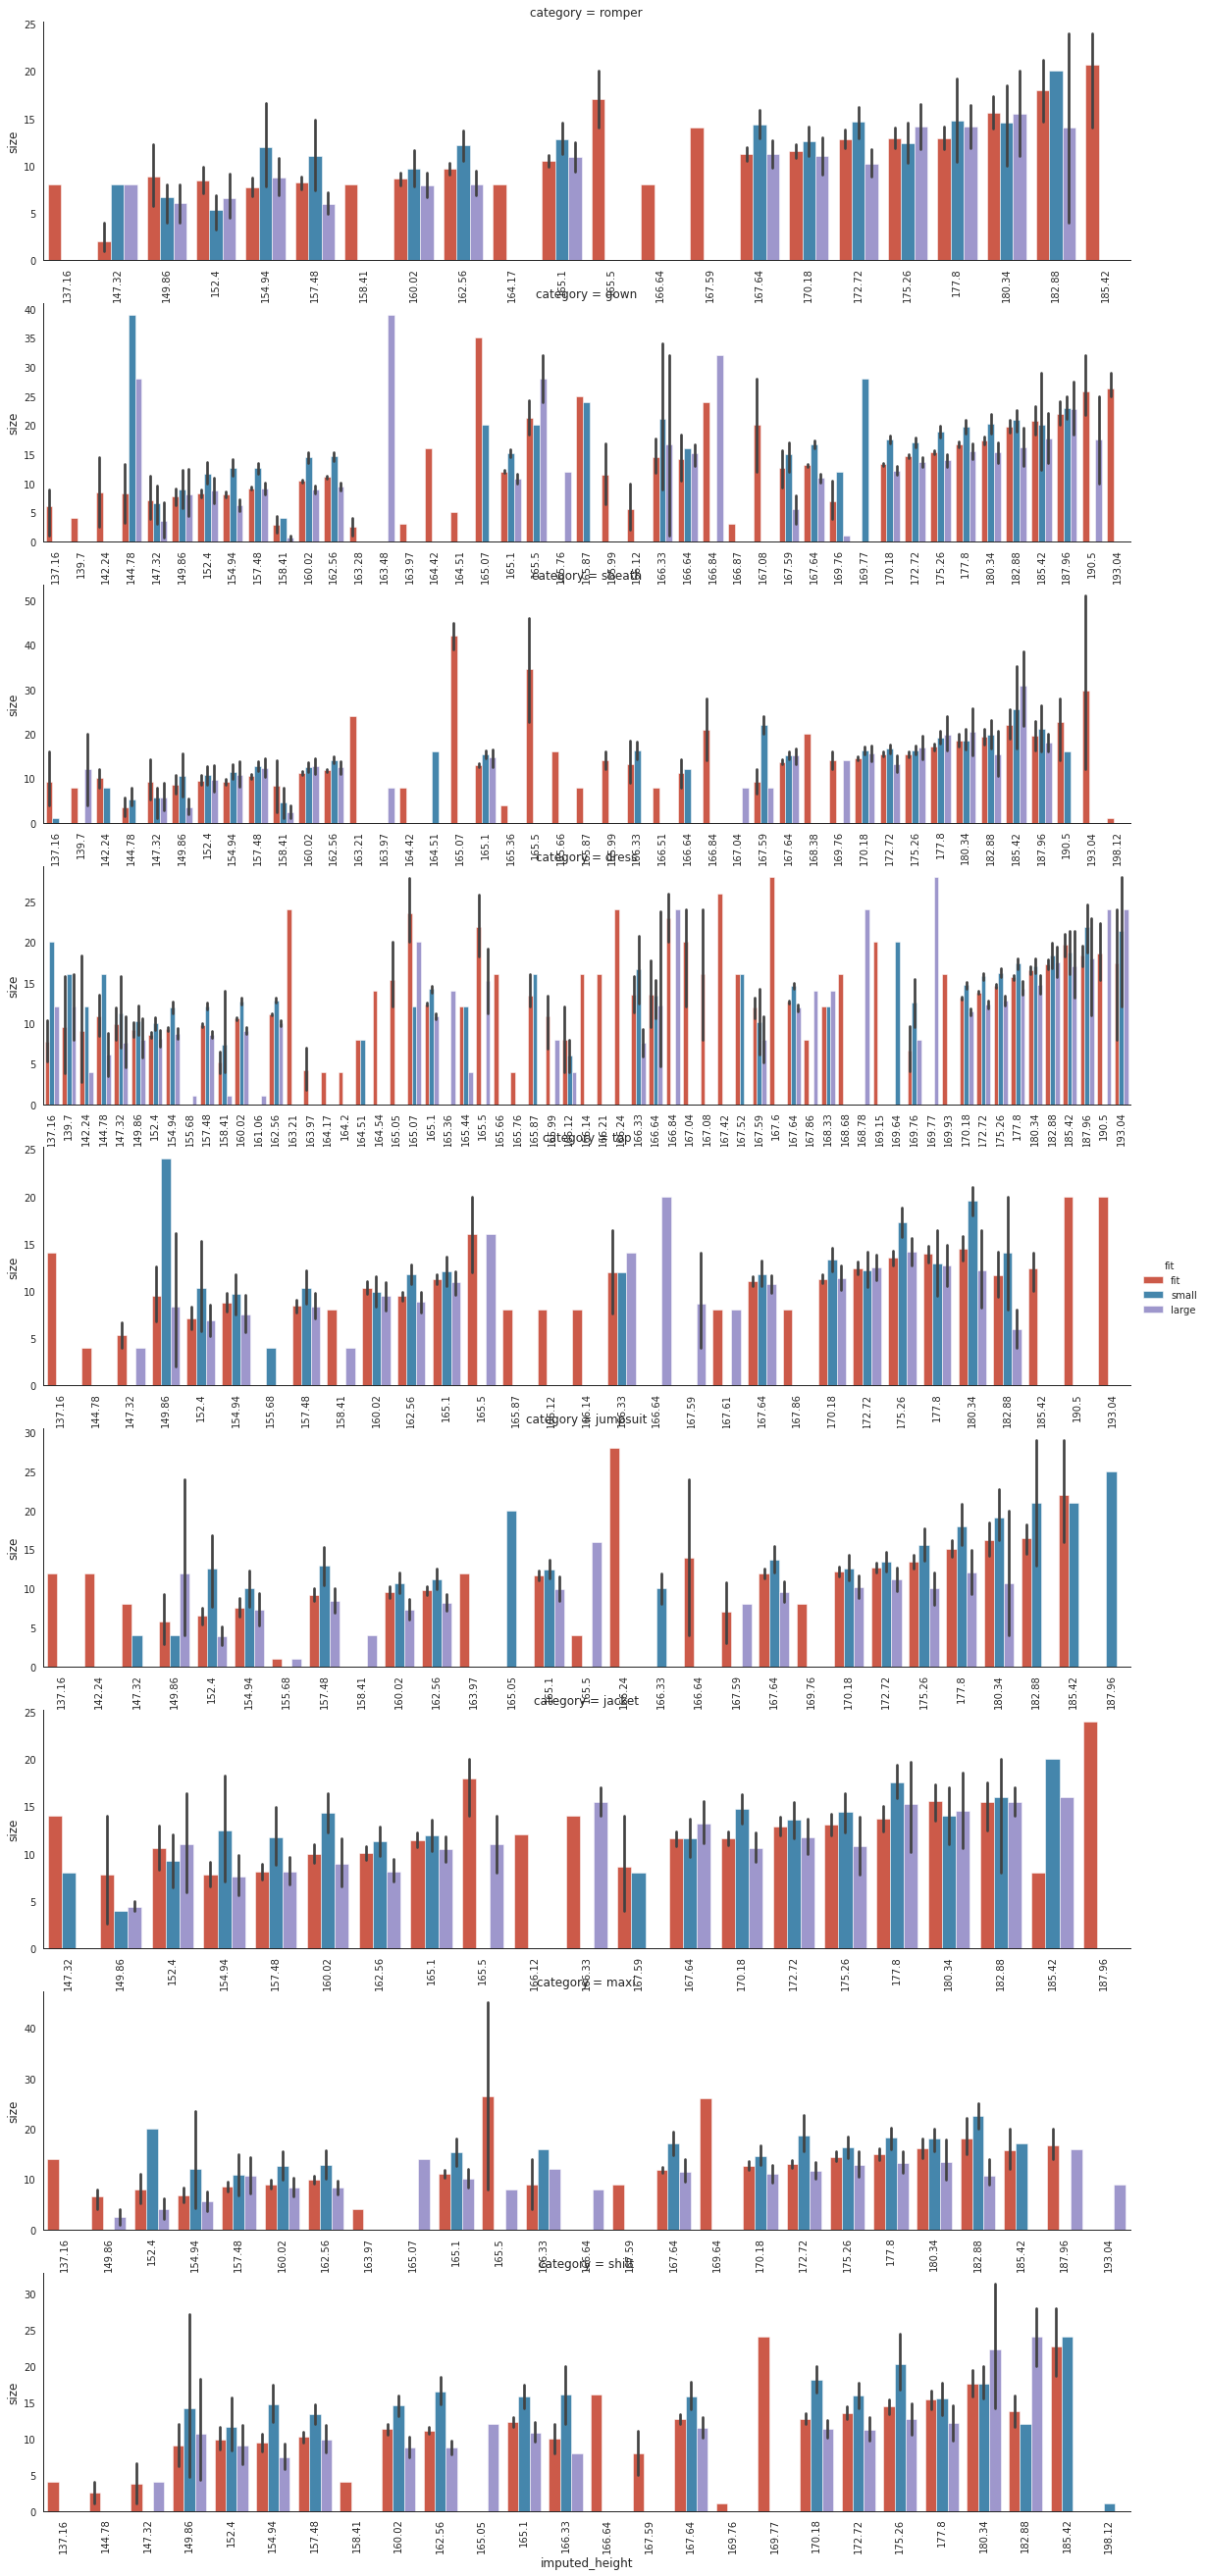

In [ ]:
# only considering heights which have data in all categories.
# look at temp_df, for each height, most of categories have 0 count.
# Only considering majority populated categories for inference and in ML models too.
filterCategoriesWithMostData = data_renttherunway_df[((data_renttherunway_df['category'] == 'dress') | (data_renttherunway_df['category'] == 'gown') | (data_renttherunway_df['category'] == 'sheath') | (data_renttherunway_df['category'] == 'top') | (data_renttherunway_df['category'] == 'jumpsuit') | (data_renttherunway_df['category'] == 'romper') | (data_renttherunway_df['category'] == 'jacket') | (data_renttherunway_df['category'] == 'maxi') | (data_renttherunway_df['category'] == 'shift'))] 
g = sns.catplot(data=filterCategoriesWithMostData, x='imputed_height', y='size', kind='bar', row='category', hue='fit', height=4, aspect=4, sharey=False, sharex=False)
g.set_xticklabels(rotation=90)

Looking into the above graphs for **user's height, category, fit feedback and ordered size**, we can make following observations for users in their height category according to their given fit feedback:

- For every height range in romper, users tend to buy smaller sizes.
- Within height range of each category respectively, smaller and larger height people, tend to buy smaller sizes.
- In mid height range within each category, "fit" size is ordered in majority.

## **Shoe Size and Width visualizations and processing**

### ModCloth

Nearly **66.3%** data is missing for shoe size and **77.5%** data is missing for shoe width. To impute these values, lets look into relationship between shoe size and other user body measurements such as height, waist, bust etc. Looking at the correlation map, we can observe the following: 

- **0.64** correlation between height and shoe size. After imputing height, we can smartly group by height and fill in missing shoe sizes with mean of shoe size according to their height.
- **0.42** correlation between hips and shoe size. 
- **0.42** correlation between bra size and shoe size. 

#### Shoe Size & Height | Hips | Bra Size Correlation



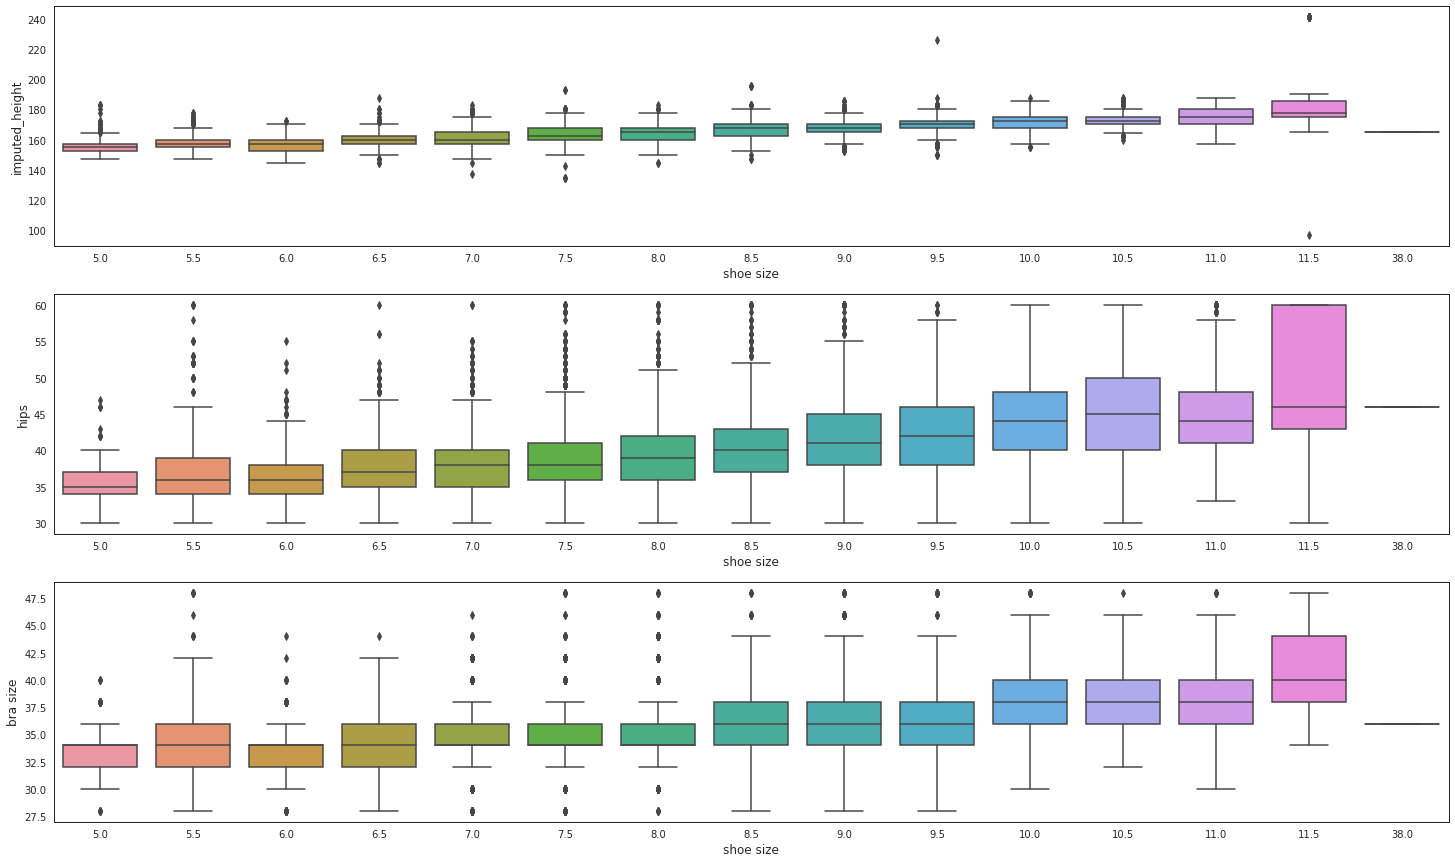

In [ ]:
f, axes = plt.subplots(3,1,figsize=(25,15))
sns.boxplot(x="shoe size", y="imputed_height", data=data_modcloth_df, orient='v', ax=axes[0])
sns.boxplot(x="shoe size", y="hips", data=data_modcloth_df, orient='v', ax=axes[1])
sns.boxplot(x="shoe size", y="bra size", data=data_modcloth_df, orient='v', ax=axes[2])

Looking at the above boxplot graph, we are able to see a **somewhat linear relationship** between shoe sizes and height, hips & bra size. Thus it makes sense to impute values for shoe sizes, by grouping each user based on their height, taking mean of shoe sizes in those groups and filling the mean value according to user's height. Similar procedure for hips and bra size to be followed. Finally, imputing with mean values of shoe size.

#### Handling outlier & Imputation

In [ ]:
#Handling shoe size outlier. We have one record which has shoe size as 38. We replace it with nan before imputing unknown shoe size values
# inspired from Aditya Agarwal Kaggle Notebook
data_modcloth_df['shoe size'][data_modcloth_df['shoe size'] == 38] = float('nan')

In [ ]:
data_modcloth_df = imputeShoeSizeForModCloth(data_modcloth_df)

In [ ]:
# Grouping by imputed shoe size and taking mode of shoe width in each group. Then checking user's imputed size and filling in the moded shoe width
data_modcloth_df = imputeShoeWidthForModCloth(data_modcloth_df)

#### Shoe Size with Size, Fit feedback and Category relationship

Referred to ModCloth website shoe category to get range of [shoe size](https://www.modcloth.com/shop/shoes) to limit items having size in above range. Additionally only categories such as new and sale could consist of shoe items, thus inference is made only for these two categories.

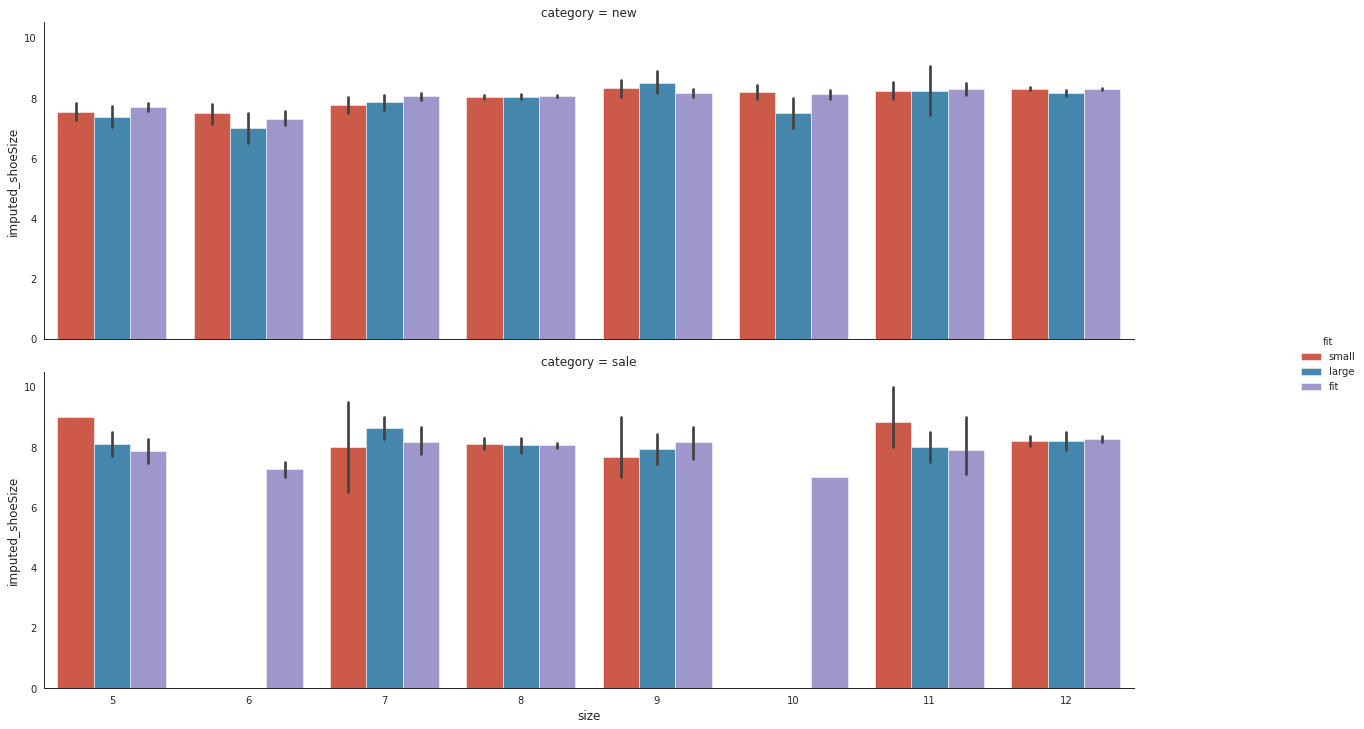

In [ ]:
g = sns.catplot(data=data_modcloth_df[(data_modcloth_df['size'] >= 5) & (data_modcloth_df['size'] <= 12) & ((data_modcloth_df['category'] == 'new') | (data_modcloth_df['category'] == 'sale'))], x='size', y='imputed_shoeSize', hue='fit', row='category', kind='bar')
g.fig.set_figwidth(20)
g.fig.set_figheight(10)

Looking at above graphs for the **new and sale** category having item sizes between **5 and 12**, inclusive, following things are noticed:
- In category new, for size **9**, oversize item is ordered.
- In category sale, for size **5, 11** undersized item is ordered.
- In category sale, for size **7** oversize item is ordered.

## **Hips Feature Imputation**


We can plot the correlation map in mod cloth dataset and see what features are hips most correlated with.

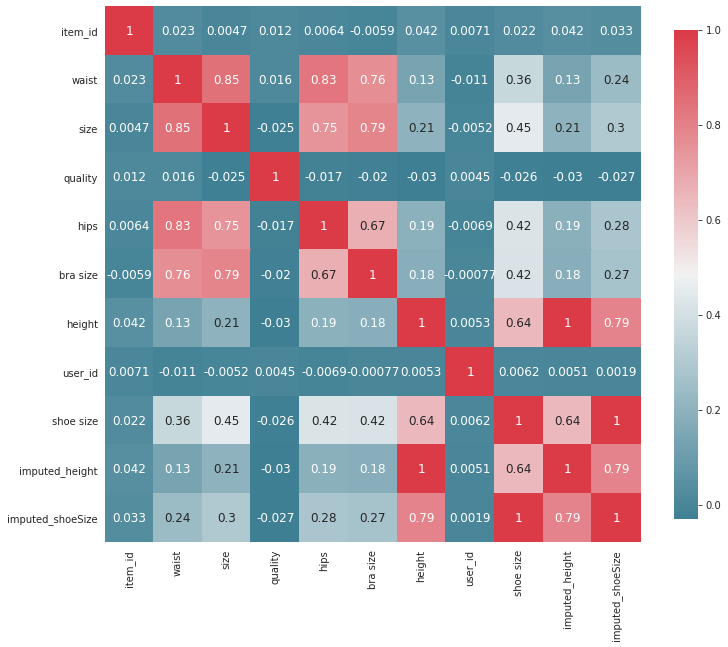

In [ ]:
plot_correlation_map(data_modcloth_df)

- We can see that hips are most related to waist, then size and then bra size. As most of the data for waist feature is missing, so probably we won't use it. 
-Next comes size, as we have all the data present for this feature, we can impute the missing values for hips by taking the mean of corresponding values for size.
- Although we can take into account bra size as well, but its data is also missing, which in future will be imputed. So, it is better to take only size values.

- Also, we can check for outliers in hips feature.

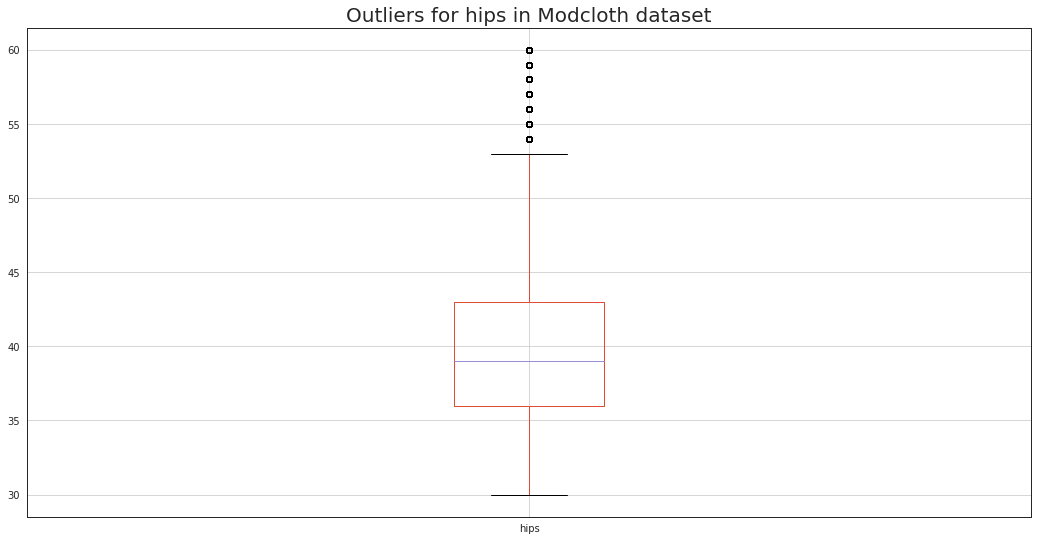

In [ ]:
num_cols = ['hips']
plt.figure(figsize=(18,9))
data_modcloth_df[num_cols].boxplot()
plt.title("Outliers for hips in Modcloth dataset", fontsize=20)
plt.show()

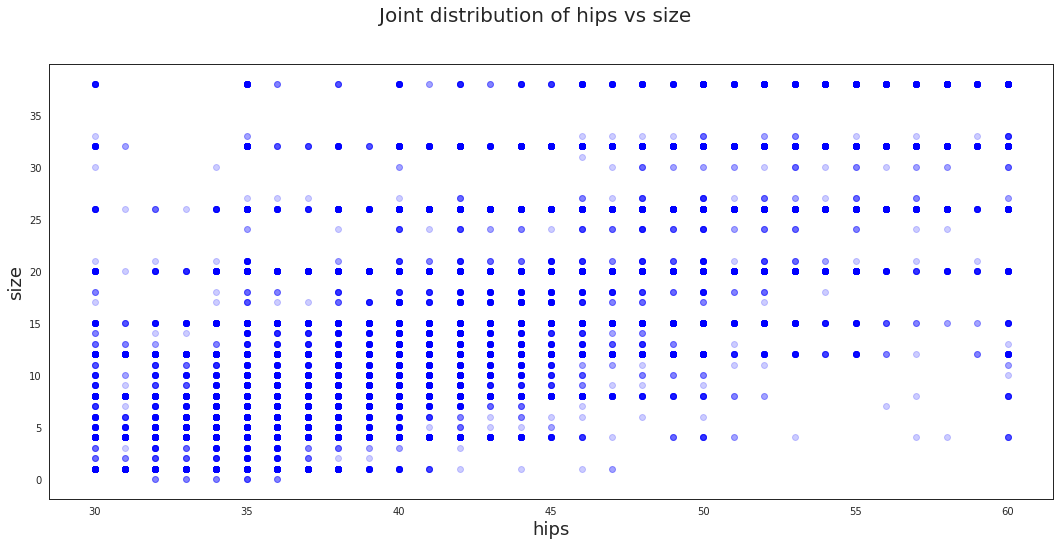

In [ ]:
plt.figure(figsize=(18,8))
plt.xlabel("hips", fontsize=18)
plt.ylabel("size", fontsize=18)
plt.suptitle("Joint distribution of hips vs size", fontsize= 20)
plt.plot(data_modcloth_df.hips, data_modcloth_df['size'], 'bo', alpha=0.2)
plt.show()

- For hips and size, I do not see any significant deviation from usual behaviour for hips, so probably the so called outliers will behave properly.
- So, I will impute the missing hip values with mean of respective size value

In [ ]:
data_modcloth_df = imputeHipsForModCloth(data_modcloth_df)
data_modcloth_df = data_modcloth_df.round({'imputed_hips':2})

In [ ]:
findPercentageOfDataMissingInEachColumnOfDataframe(data_modcloth_df, data_modcloth_df.shape[0])

                   numberOfCellsMissingValues  percentageMissing
waist                                   79908          96.518903
bust                                    70936          85.681846
shoe width                              64183          77.525063
shoe size                               54876          66.283368
hips                                    26726          32.281677
review_text                              6725           8.122962
review_summary                           6725           8.122962
cup size                                 6255           7.555260
bra size                                 6018           7.268994
height                                   1107           1.337118
quality                                    68           0.082136
length                                     35           0.042276
imputed_hips                                1           0.001208
user_id                                     0           0.000000
fit                      

- Lets consider only hips which have data in all categories.
- Relationship between hips, size, category and fit feedback

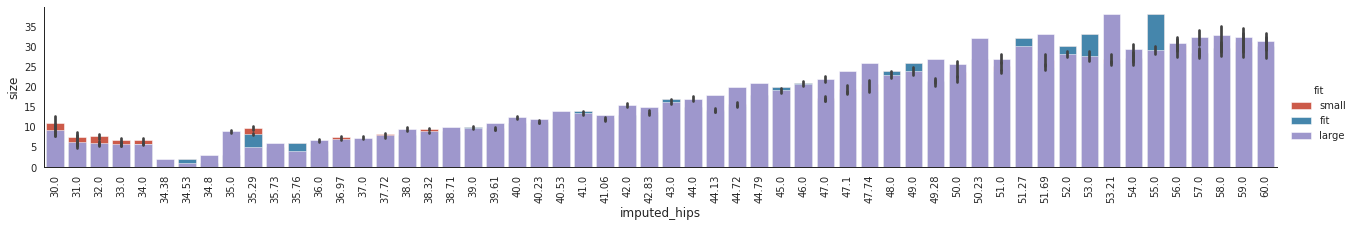

In [ ]:
plot_categories( data_modcloth_df , cat = 'imputed_hips' , target = 'size', hue='fit' )

- The above plot shows that almost all the time large clothes have been ordered. Let us try to split this plot by categories and see if we can find something out.

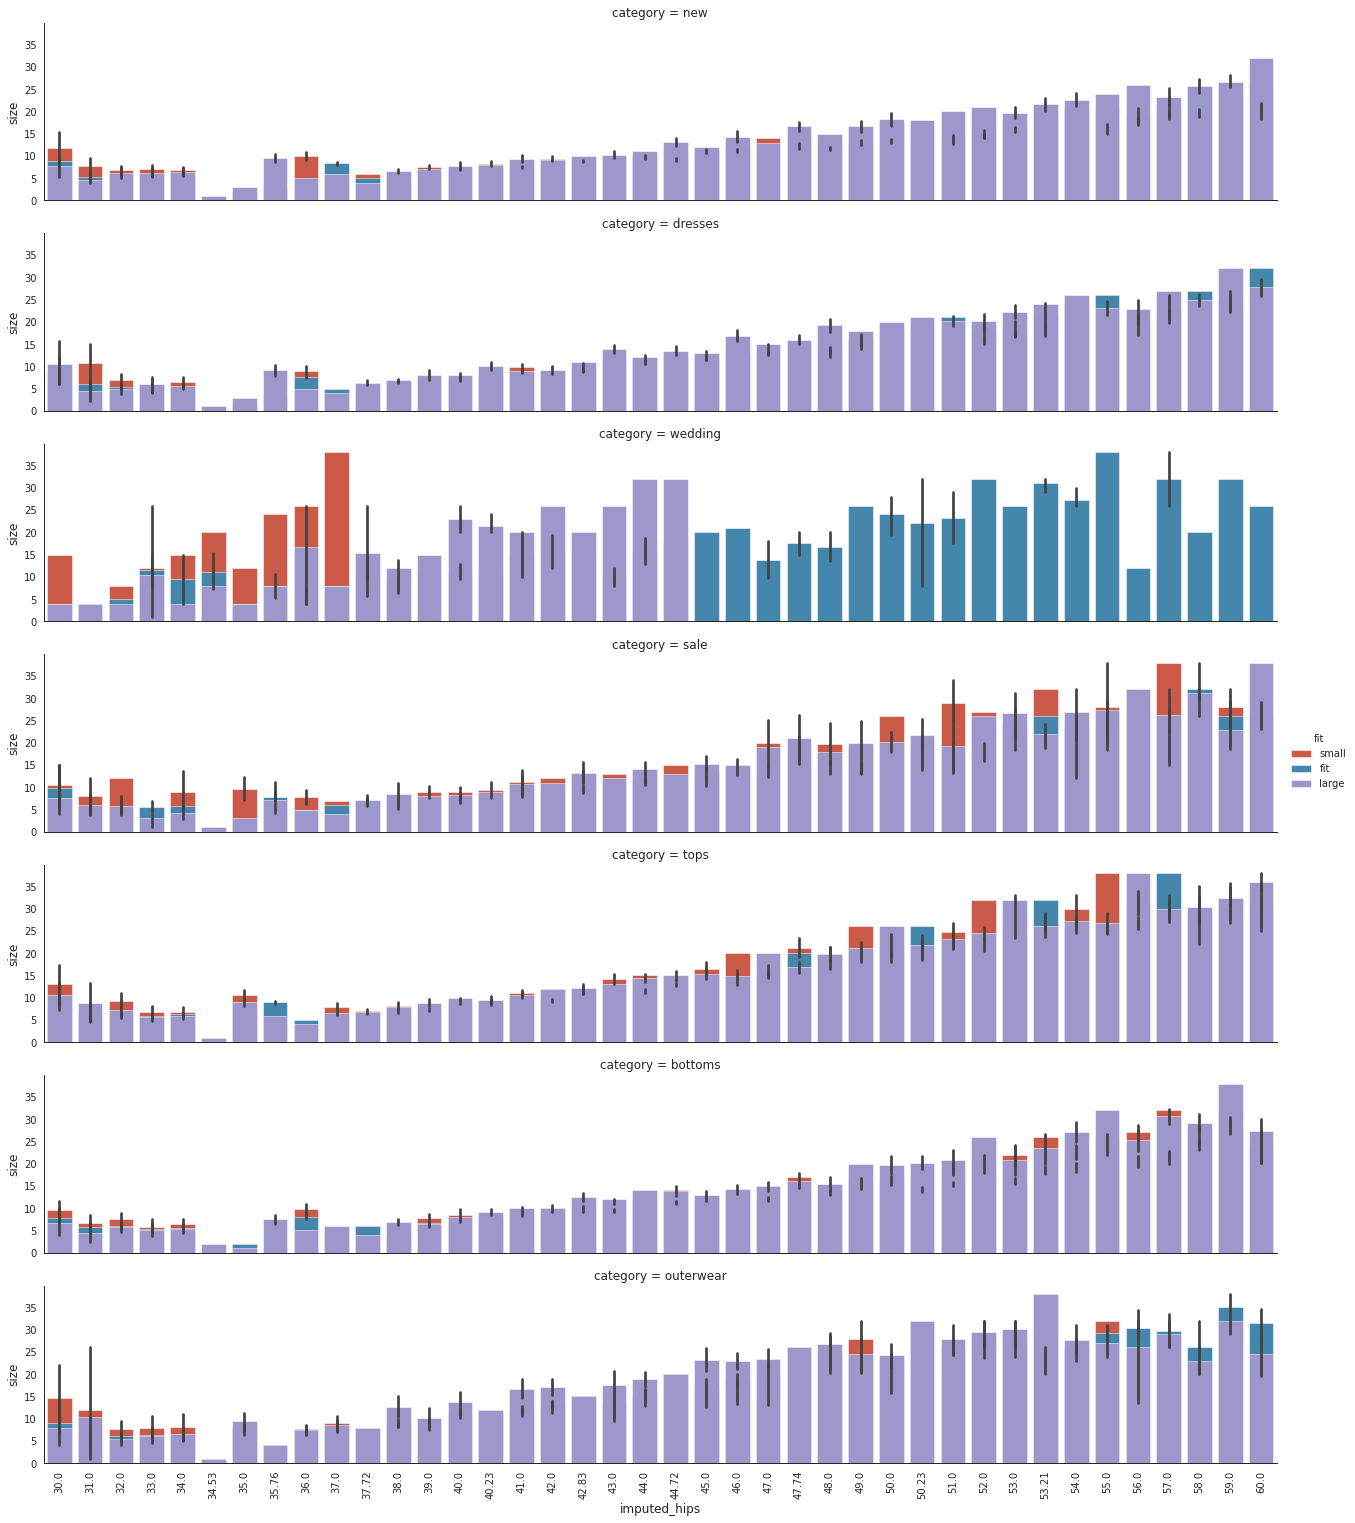

In [ ]:
plot_categories( data_modcloth_df , cat = 'imputed_hips' , target = 'size', row = 'category', hue='fit' )

- We can infer that mostly people buy oversized clothes except for the wedding dresses. In that plot we can see most people buying fit dresses, otherwise loose dresses around the hips will not look good 
- Some buy small sized, maybe because of being apperhensive

## **Category**
There is no data missing, so no imputations required. We will change its dtype to 'category'

In [ ]:
data_modcloth_df.category = data_modcloth_df.category.astype('category')

- Now let's see some correlation between 'category' and some other features like fit, quality etc.
- We can find out what the major reasons for return are, if we normalize the counts and then have a look at the distribution. 

**Category and Fit**

In [ ]:
g_by_category = data_modcloth_df.groupby('category')
cat_fit = g_by_category['fit'].value_counts()
cat_fit = cat_fit.unstack()
cat_fit_norm = norm_counts(cat_fit)
cat_fit_norm.drop(['fit'], axis=1, inplace=True)

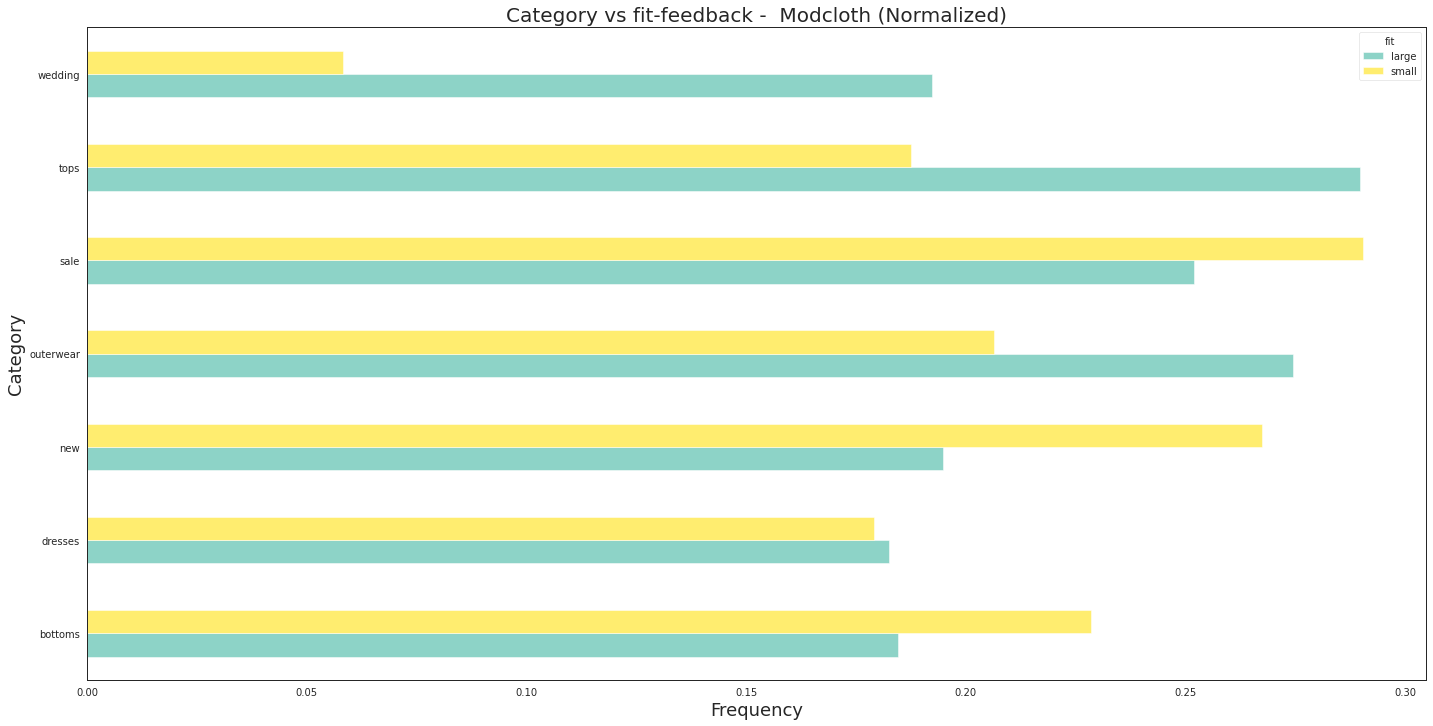

In [ ]:
plot_barh(cat_fit_norm, 'fit', norm=1, cmap='Set3')

- From the above graph, we can infer that in case there are more returns in wedding dresses, tops and outerwear, it is mostly because people buy the larger fit and then return it.
- Similarly, for bottoms, new, and the products in sale, people buy smaller size by mistake and then return it.


**Category and length**

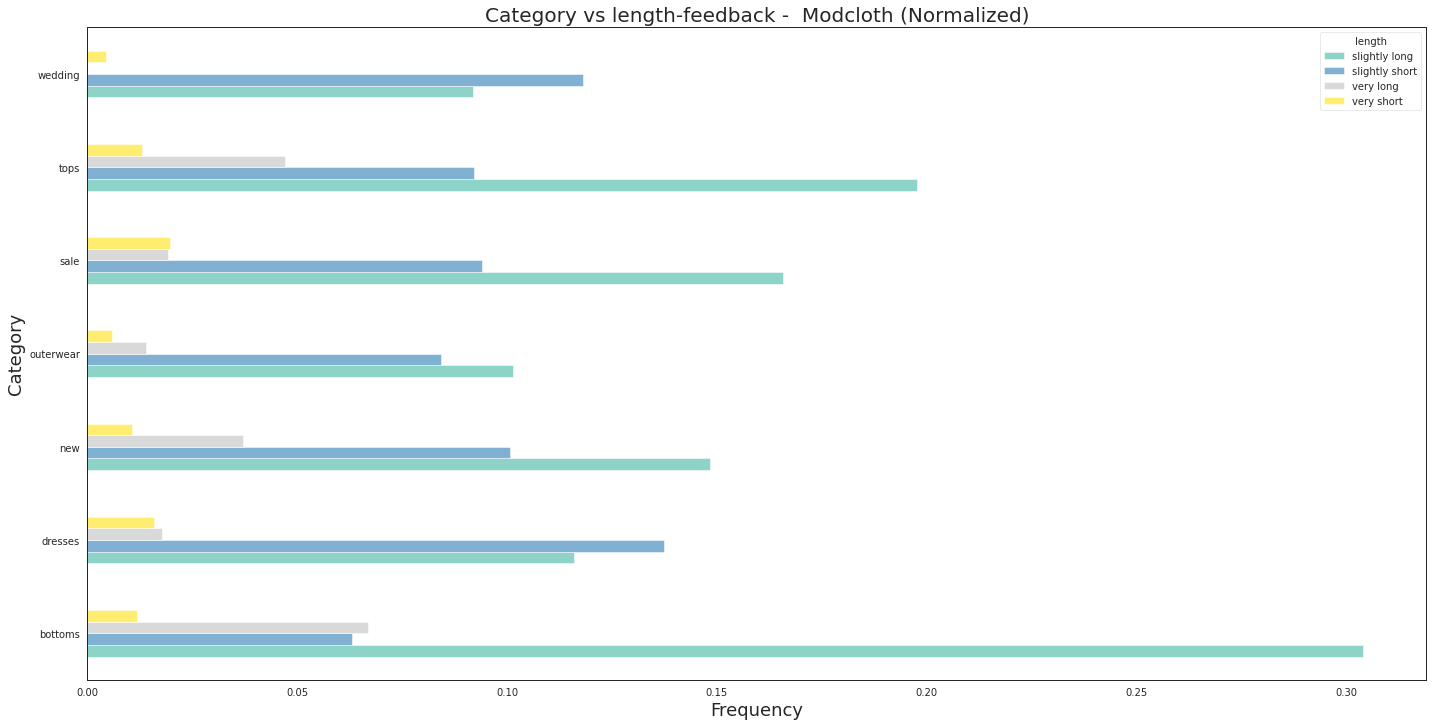

In [ ]:
cat_len = g_by_category['length'].value_counts()
cat_len = cat_len.unstack()
cat_len_norm = norm_counts(cat_len)
cat_len_norm.drop(['just right'], axis = 1, inplace=True)
plot_barh(cat_len_norm, 'length', cmap='Set3', norm=1)

- By studying the above plot, we understand that their are return requests due to length reason as well.
- For bottoms, tops, sale and new categories, people tend to buy 'slightly long' length.
- For dresses and wedding category, people people usually buy 'slightly short' and then return it.


***Category and Quality***

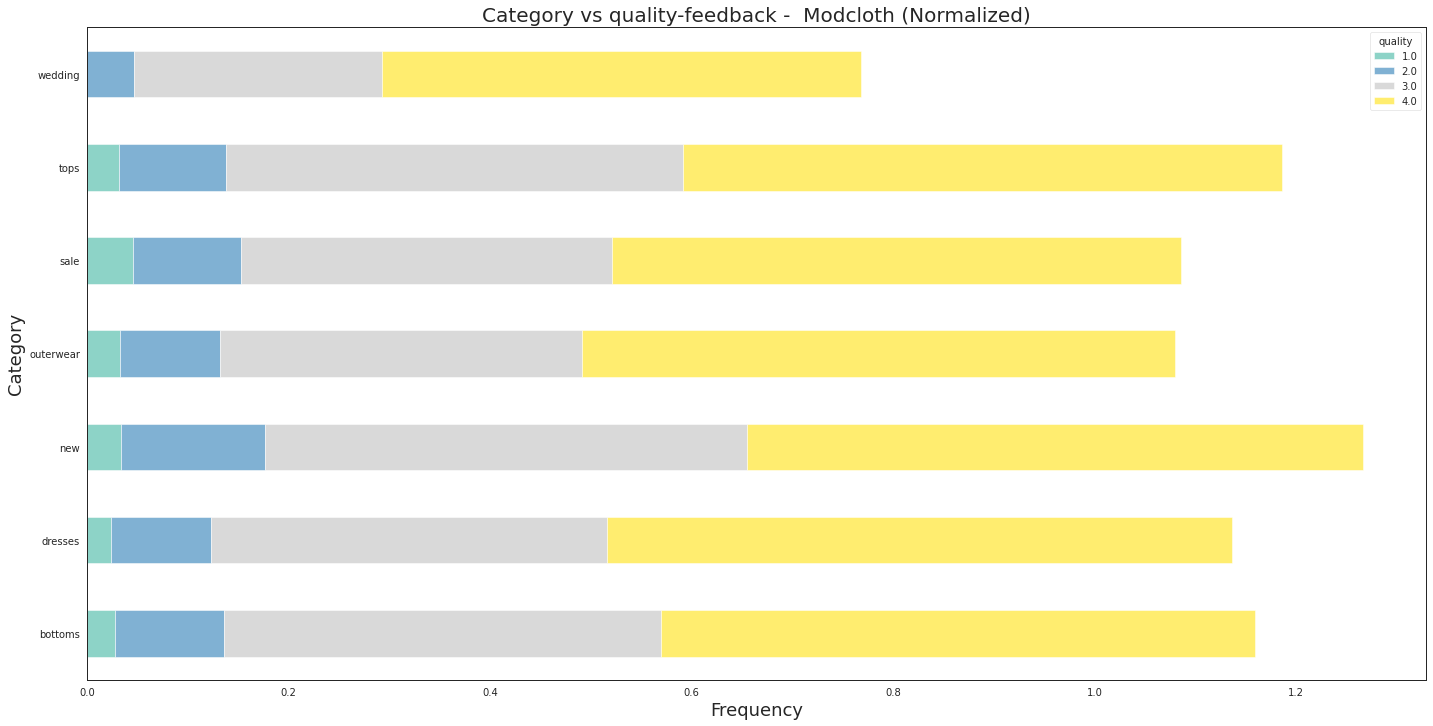

In [ ]:
cat_quality = g_by_category['quality'].value_counts()
cat_quality = cat_quality.unstack()
cat_quality_norm = norm_counts(cat_quality)
cat_quality_norm.drop([5.0], axis = 1, inplace=True)
plot_barh(cat_quality_norm, 'quality', 'Set3', stacked=1, norm=1)


- Here, mostly all the categories have equal share of ratings.



## **Bra Size, Cup Size and Bust Size**

#### ModCloth

In modcloth dataset, we have bra size (for eg. 34) and cup size (for eg. d) separately. Whereas, in RentTheRunWay dataset, it is a combined column (for eg. 34d).
So, we will first be imputing the missing values for bra size and cup size and then combine the columns to create a new column that is similar to the one present in RentTheRunWay dataset.

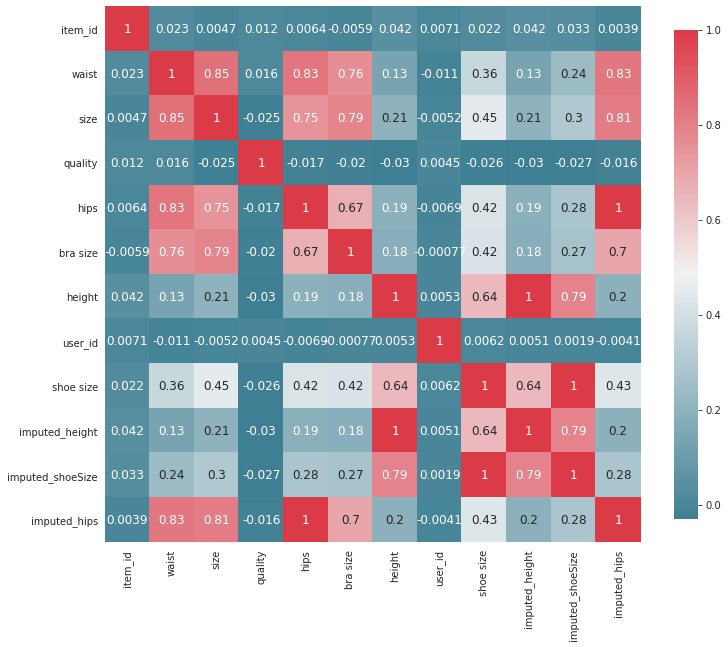

In [ ]:
plot_correlation_map(data_modcloth_df)

* As we can see in the above correlation map that bra size is mostly correlated to size, waist and imputed_hips. As waist has more than 95% missing values, we will be removing that column and we will just use size and imputed_hips to impute the missing bra sizes that account to around **7.26%**.



In [ ]:
data_modcloth_df = imputeBraSizeForModCloth(data_modcloth_df) #imputing bra sizes
data_modcloth_df = data_modcloth_df.round({'imputed_brasize':0}) #rounding off the imputed values
data_modcloth_df = roundToEvenBraSize(data_modcloth_df) #convert odd bra sizes to even by adding 1 as suggested in referred material
data_modcloth_df.imputed_brasize=data_modcloth_df.imputed_brasize.astype(int) #converting from float to int
data_modcloth_df.imputed_brasize=data_modcloth_df.imputed_brasize.astype(str) #converting to dtype object

After imputing the bra size column, let's have a look at cup size column. Cup size has around **7.5%** missing values and because it is a categorical variable, we can't see the correlation through correlation map. We will impute cup size using mode of imputed bra sizes. After imputing the cup sizes, we will combine both the imputed bra size column and imputed cup size column to form a new bust size column.

In [ ]:
 #groupedByBraSizeCupSizeCount = data_modcloth_df.groupby('imputed_brasize')['cup size'].value_counts()
 #print(data_modcloth_df['imputed_brasize'].unique()) #print unique imputed bra sizes
 #with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
 #    print(groupedByBraSizeCupSizeCount) #print combinations of brasizes and cup sizes as available.
data_modcloth_df = imputeCupSizeForModCloth(data_modcloth_df) #impute cupsize
data_modcloth_df = combineBustSizeForModCloth(data_modcloth_df) #combine brasize and cupsize to form new column
#data_modcloth_df.info()

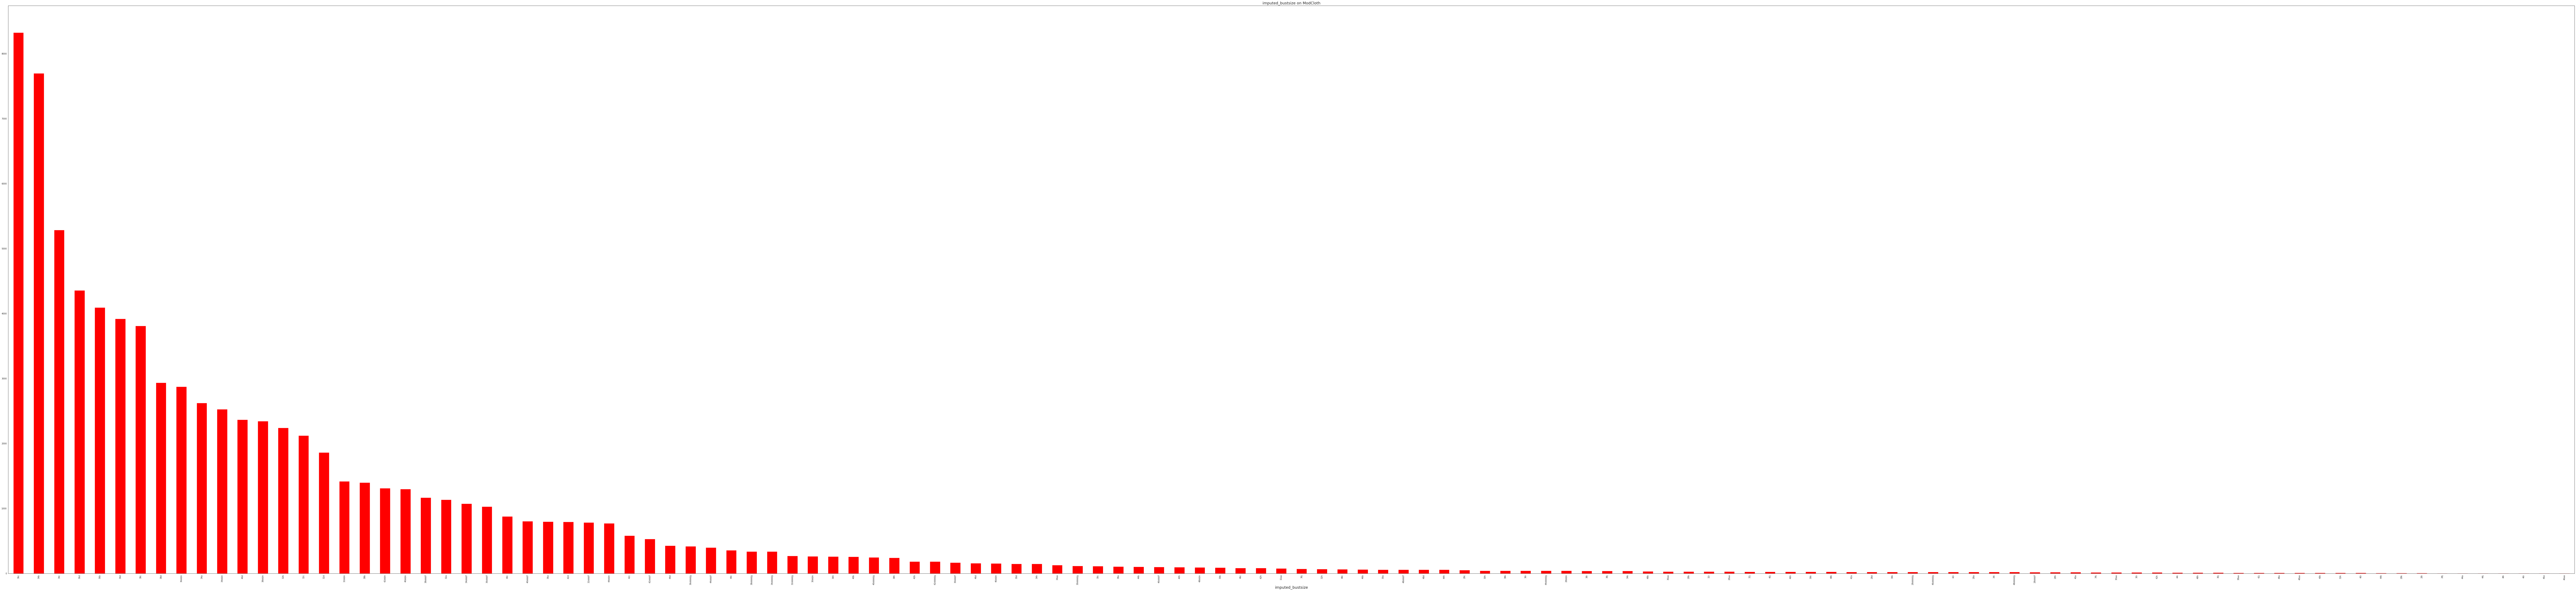

In [ ]:
fig, ax = plt.subplots(figsize = (220,50))
cols = ['imputed_bustsize']
frequencyCountByValue(data_modcloth_df, cols[0],'ModCloth',ax)


#### RentTheRunWay

Now, let's plot bust size column from RentTheRunWay and see the distribution.

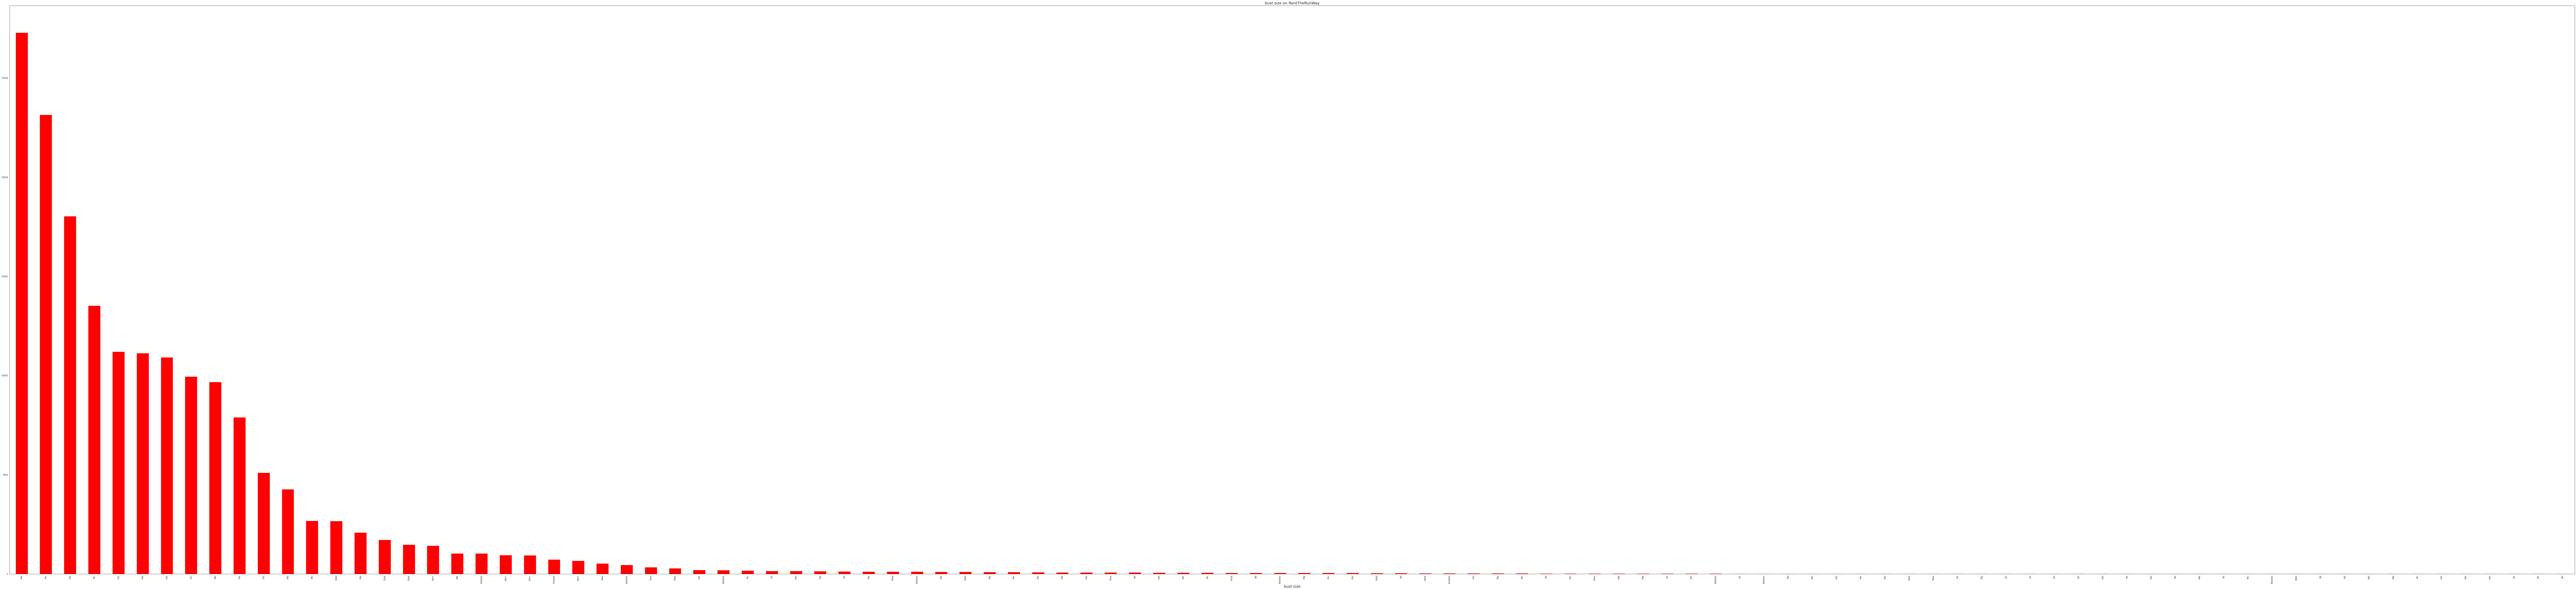

In [ ]:
fig, ax = plt.subplots(figsize = (220,50))
cols = ['bust size']
frequencyCountByValue(data_renttherunway_df, cols[0],'RentTheRunWay',ax)


As we see, there is a lot of inconsistency in this data.
There are different sizes like d+, dd, dd/e, ddd/e etc. But according to a universal cup size chart, the sizes are different. So, we will convert the sizes accordingly to make it universal.


We will be converting as follows:


*   d+ -> dd/e
*   dd -> dd/e
*   ddd/e -> ddd/f
*   f -> ddd/f

First, we will impute missing values of the bust size column which are around 9.56%.





In [ ]:
data_renttherunway_df = imputeBustSizeForRentTheRunWay(data_renttherunway_df) #imputed missing bust sizes based on grouping category column and taking mode

In [ ]:
data_renttherunway_df = convertBustSizeForRentTheRunWay(data_renttherunway_df) #converting inconsistent sizes

Now, after all the imputation is done, we will convert these categorical bust sizes for both datasets to numerical ones (in inches) by passing to the same function.

In [ ]:
data_modcloth_df=convertBustSizeToInches(data_modcloth_df) #convert bust sizes to inches

In [ ]:
data_renttherunway_df=convertBustSizeToInches(data_renttherunway_df) #convert bust sizes to inches

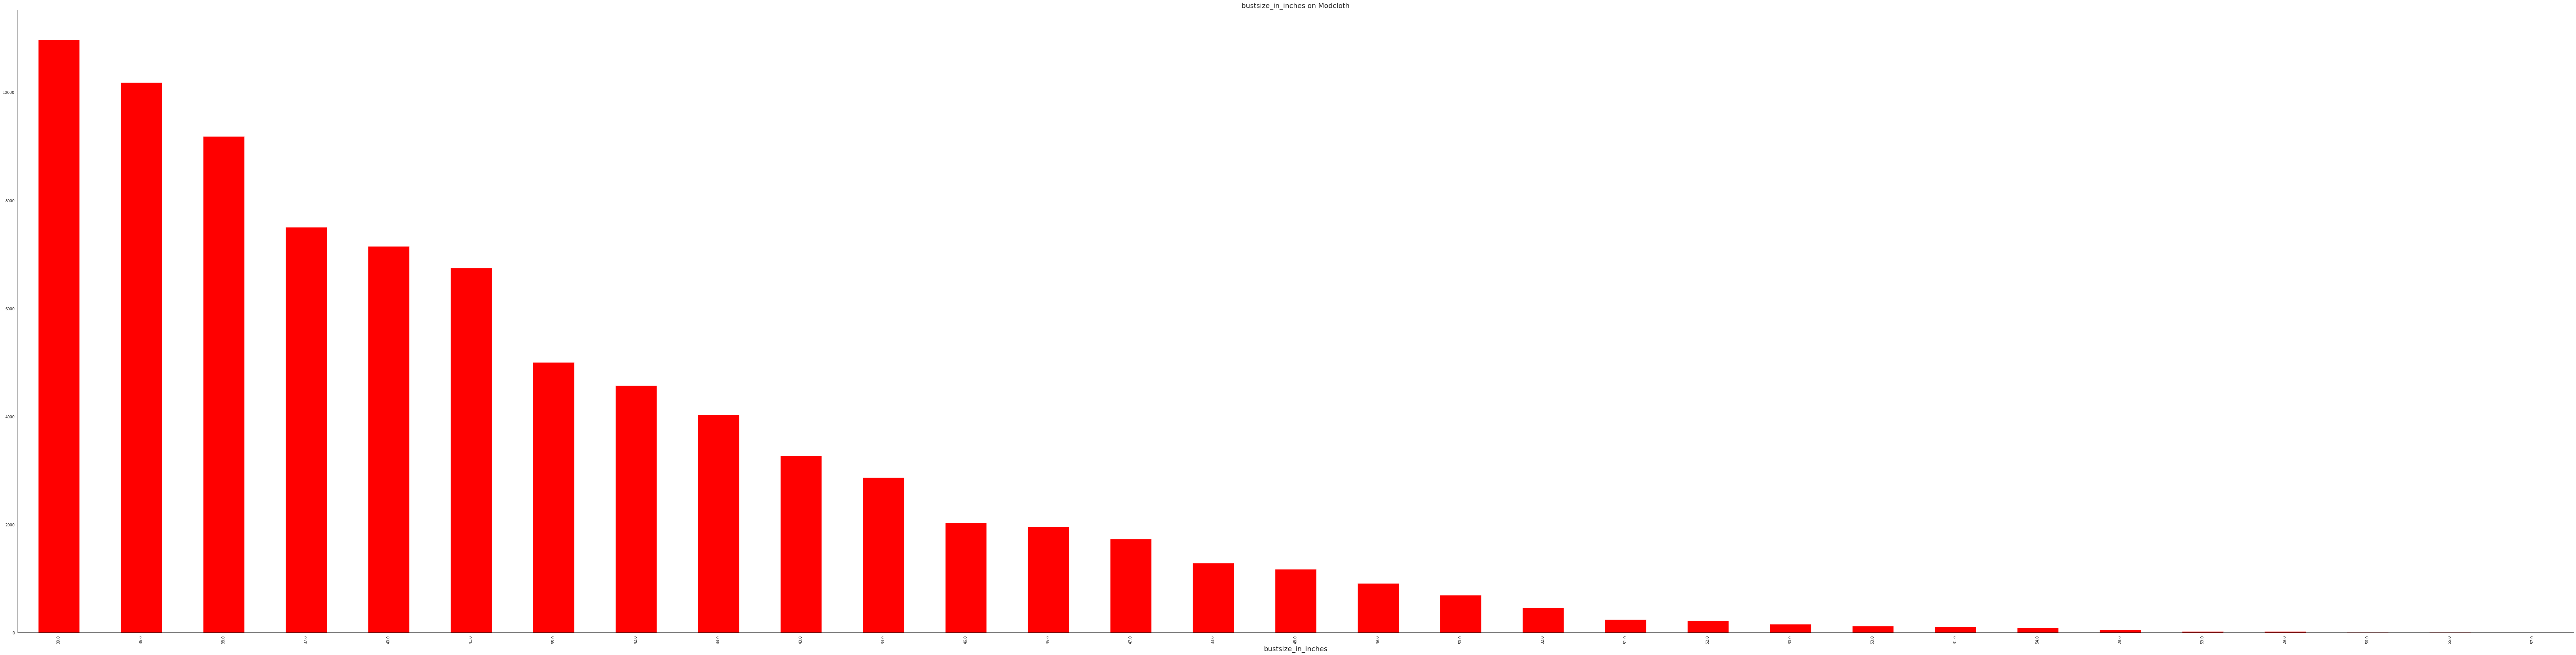

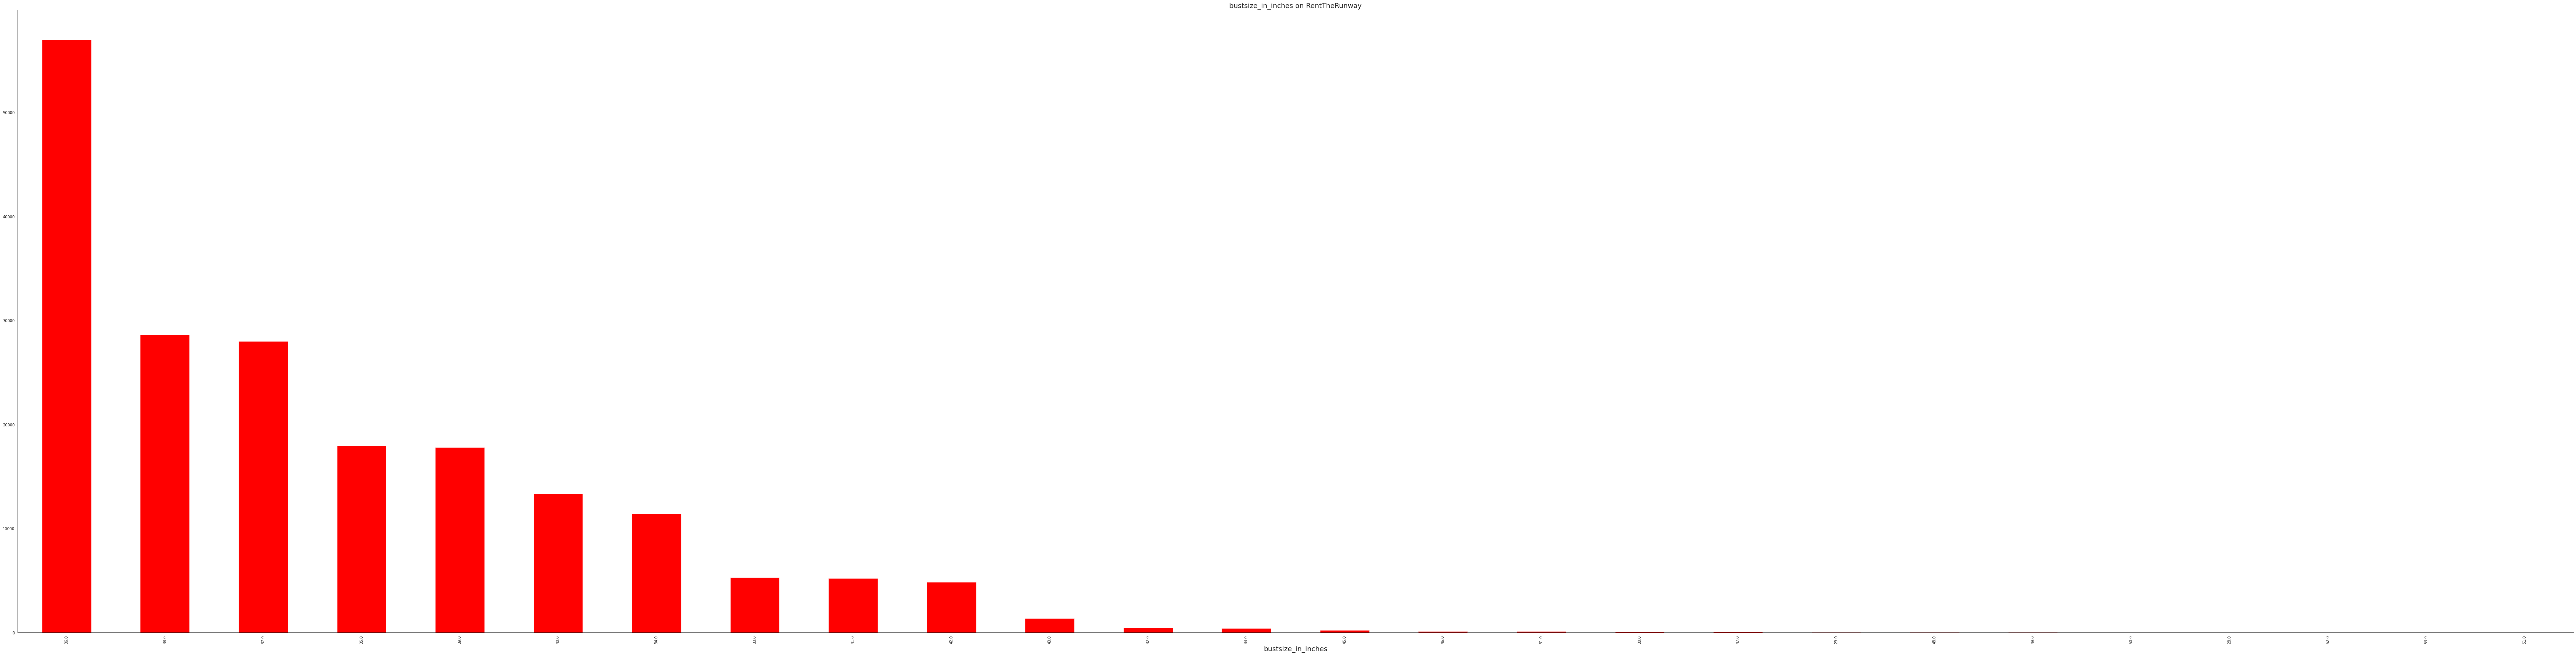

In [ ]:
fig, ax = plt.subplots(figsize = (120,30))
cols = ['bustsize_in_inches']
frequencyCountByValue(data_modcloth_df, cols[0],'Modcloth',ax)
fig, bx = plt.subplots(figsize = (120,30))
cols = ['bustsize_in_inches']
frequencyCountByValue(data_renttherunway_df, cols[0],'RentTheRunway',bx)

Let's look at box plot analysis for both the datasets.

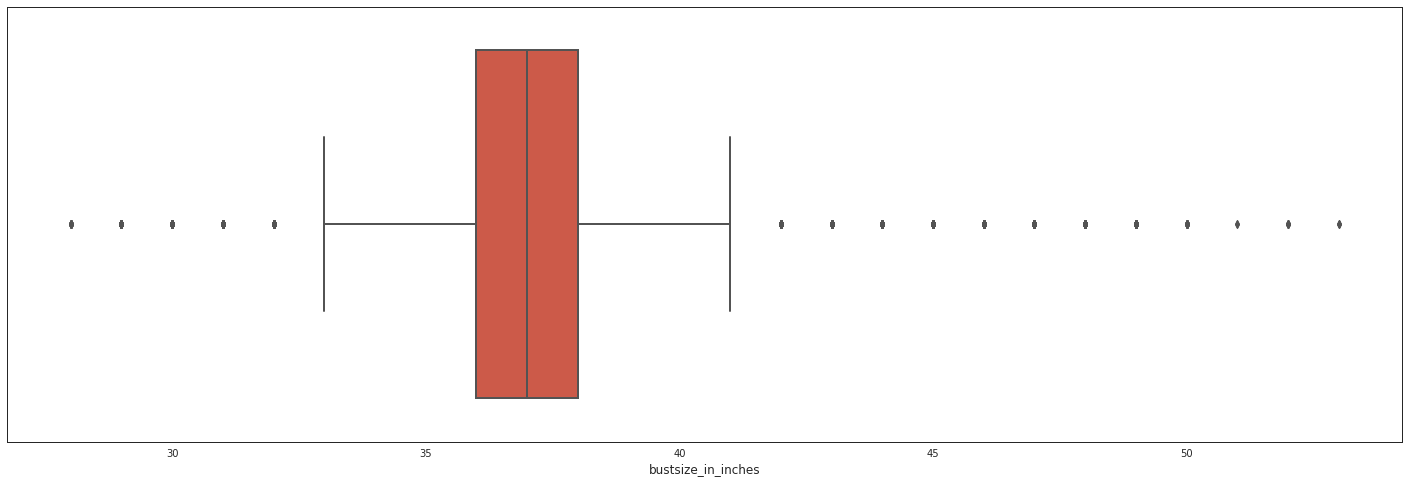

In [ ]:
fig = plt.figure(figsize=(25,8))
sns.boxplot(x=data_renttherunway_df['bustsize_in_inches'], linewidth=2)

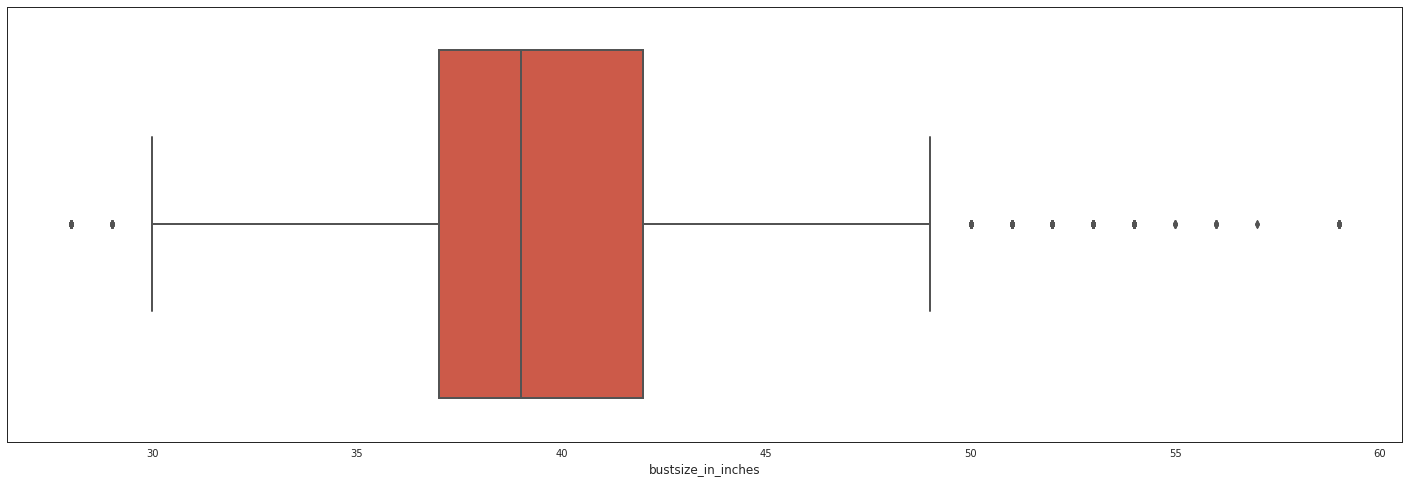

In [ ]:
fig = plt.figure(figsize=(25,8))
sns.boxplot(x=data_modcloth_df['bustsize_in_inches'], linewidth=2)

We can see that in both the datasets, the mean of bust sizes lies between 35 to 40 inches. But we won't be removing the outliers because imputing mean values for the outliers might bring inconsistency through the data and our prediction model won't be able to support sizes which do no lie in the range 33-42.

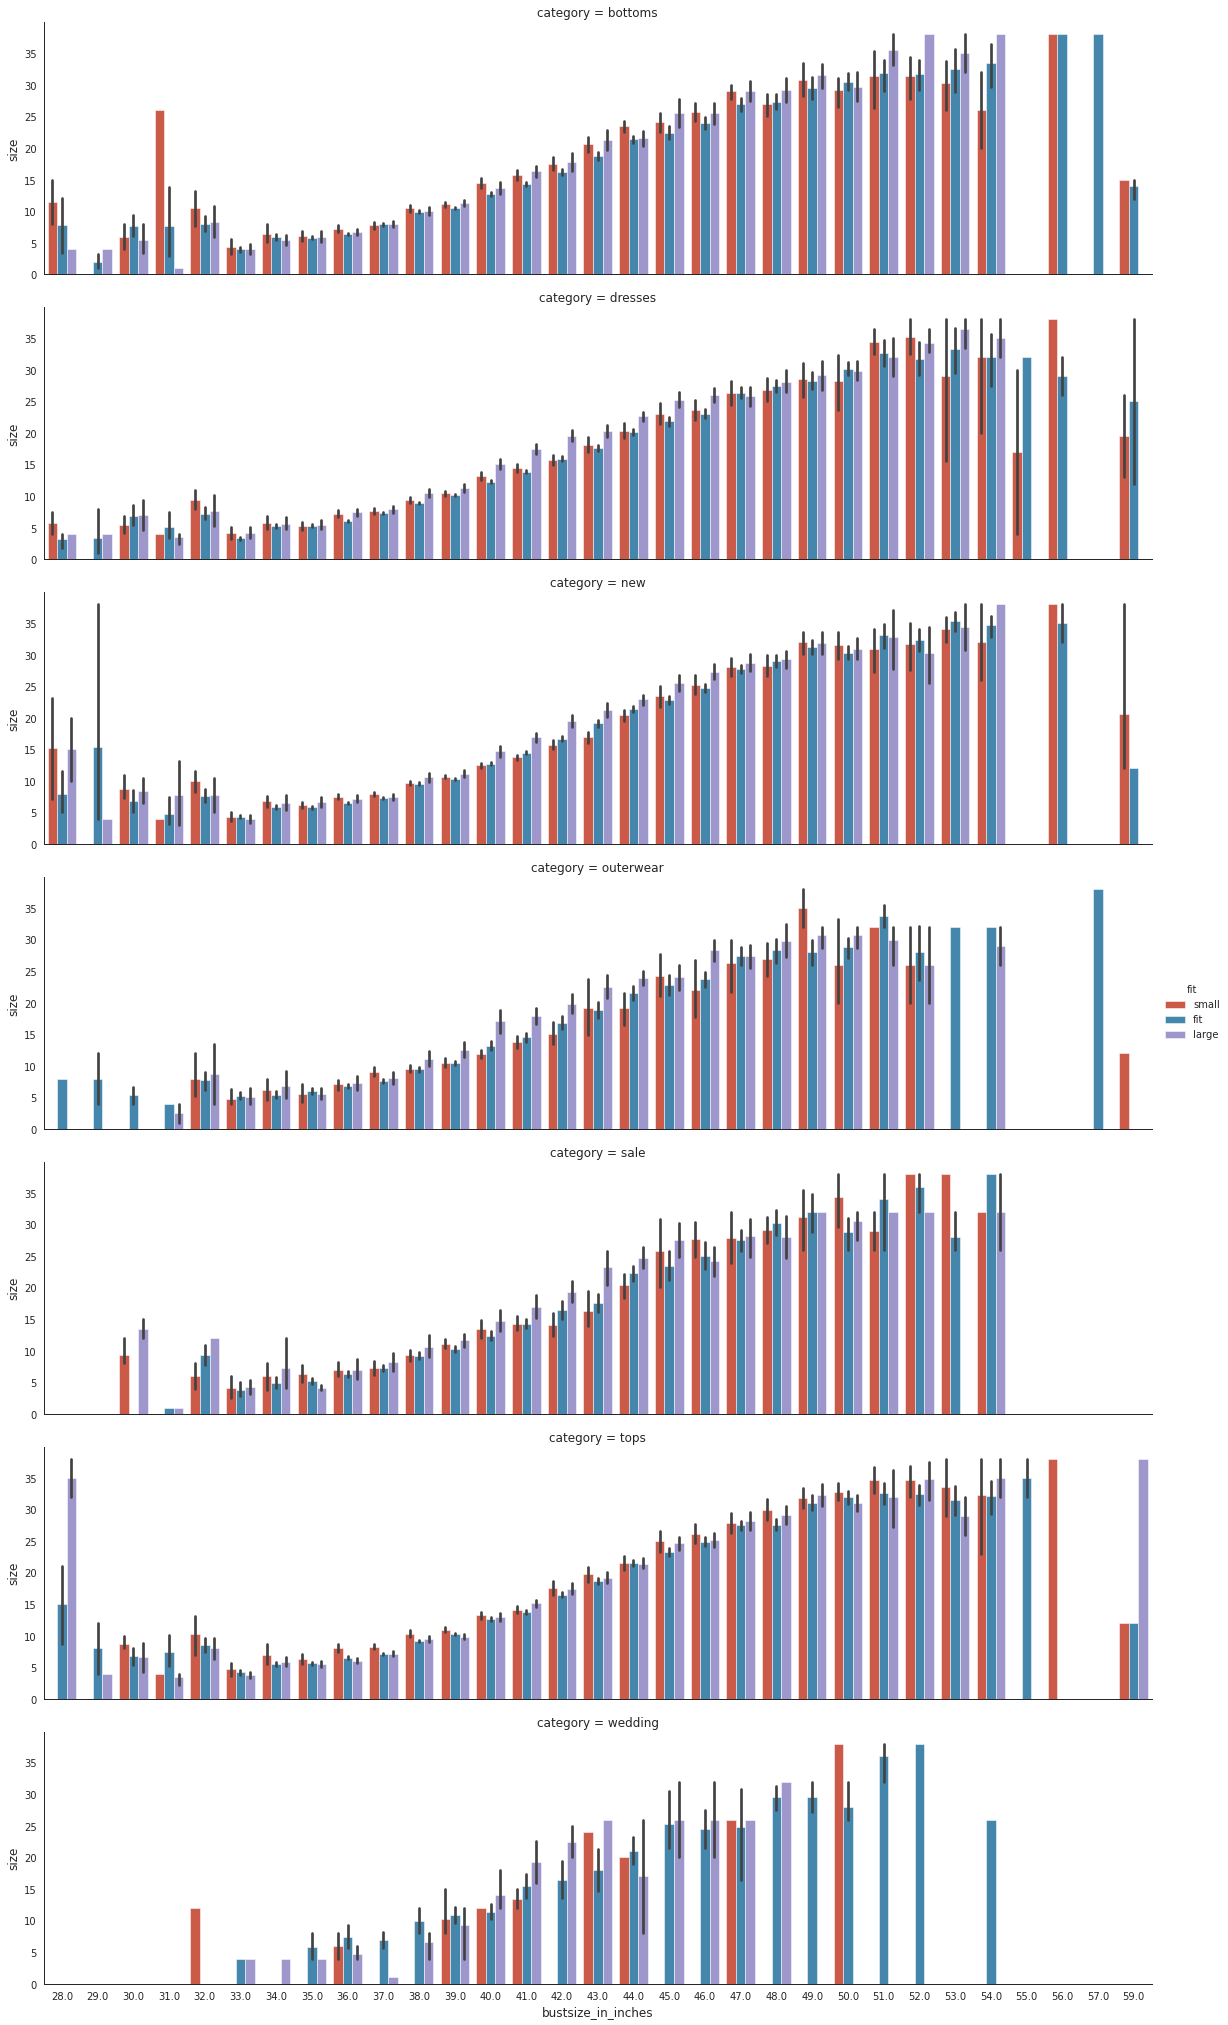

In [ ]:
g = sns.catplot(data=data_modcloth_df, x='bustsize_in_inches', y='size', hue='fit', row='category', kind='bar', height=4, aspect=4)

From the above plot, following can be inferred:


1.   For bust sizes between 28 to 31, there is high fluctuation in fit feedback.
2.   For wedding category, most people with bust size over 44 have classified the product as fit, and most people with bust size between 40 and 43 have classified the product as large.
3. Many of the fit feedbacks for different categories and same bust sizes is almost similar (almost same amount of small, fit and large)



## **Weight Processing and Visualization**

#### RentTheRunWay

Nearly **15.8%** data is missing for weight in RentTheRunWay Dataset. To impute these values, lets look into relationship between weight and other user body measurements such as height, waist, bust etc. Looking at the correlation map, we can observe the following: 

- **0.85** correlation between weight and item size.
- **0.38** correlation between weight and height. 

In [ ]:
print(data_renttherunway_df[data_renttherunway_df.weight.isnull()].shape[0])
data_renttherunway_df = imputeWeightForRentTheRunWay(data_renttherunway_df)
print(data_renttherunway_df[data_renttherunway_df.imputed_weight.isnull()].shape[0])

29982
0


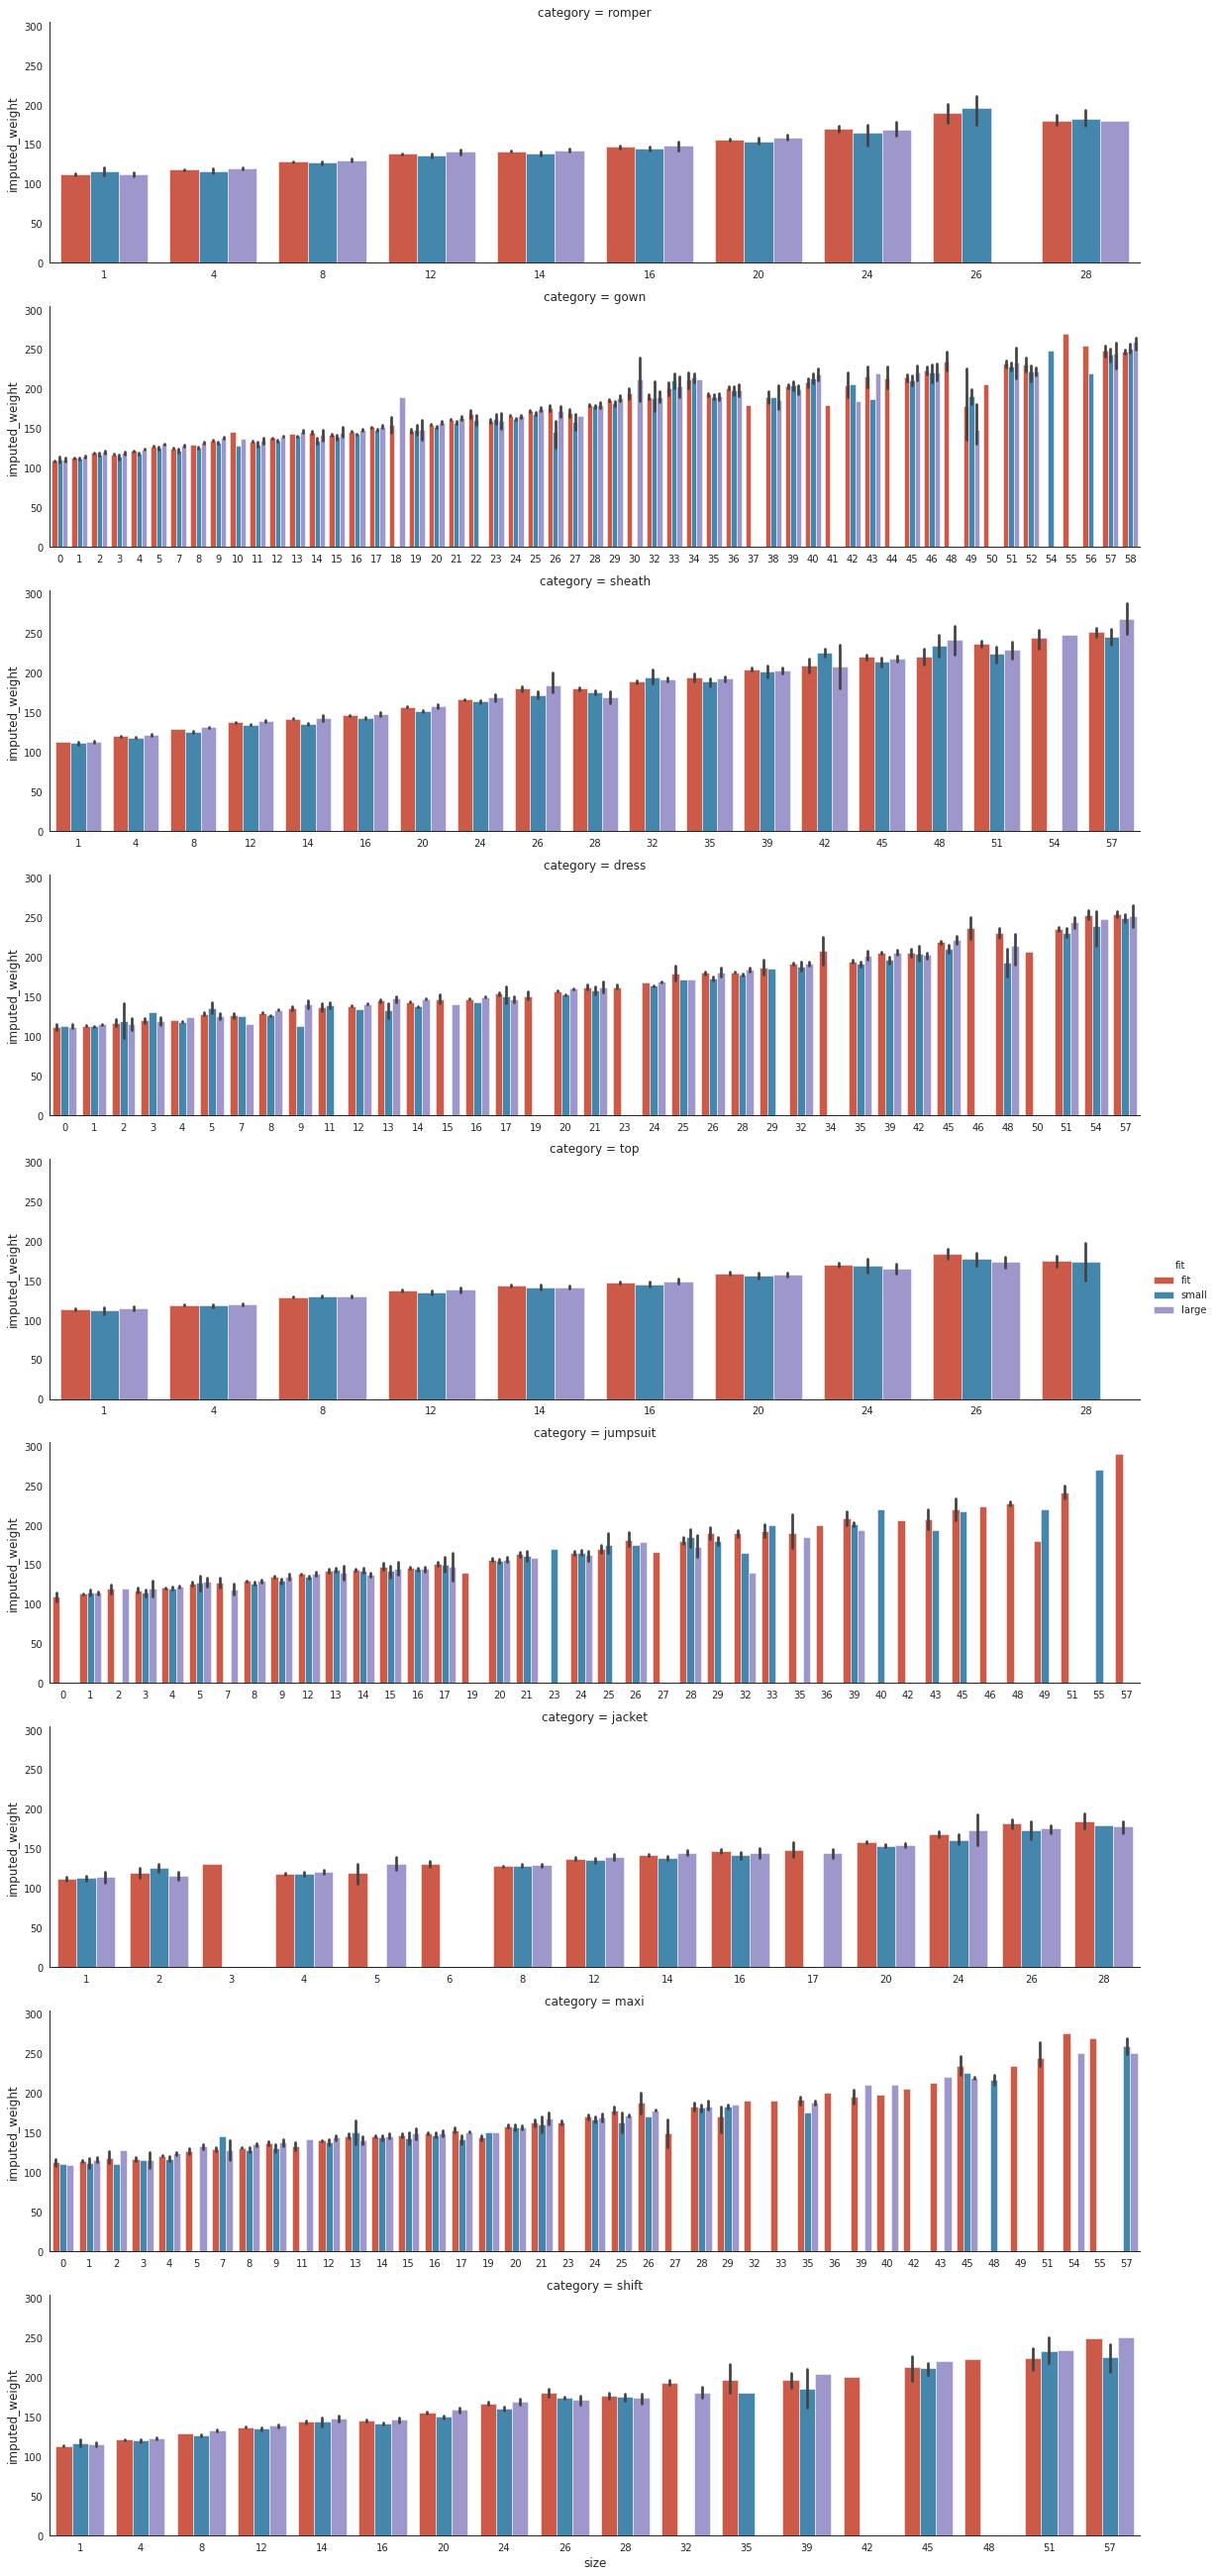

In [ ]:
# Only considering majority populated categories for inference and in ML models too.
filterCategoriesWithMostData = data_renttherunway_df[((data_renttherunway_df['category'] == 'dress') | (data_renttherunway_df['category'] == 'gown') | (data_renttherunway_df['category'] == 'sheath') | (data_renttherunway_df['category'] == 'top') | (data_renttherunway_df['category'] == 'jumpsuit') | (data_renttherunway_df['category'] == 'romper') | (data_renttherunway_df['category'] == 'jacket') | (data_renttherunway_df['category'] == 'maxi') | (data_renttherunway_df['category'] == 'shift'))]
g = sns.catplot(data=filterCategoriesWithMostData, x='size', y='imputed_weight', hue='fit', row='category', kind='bar', height=4, aspect=4, sharex=False)

Looking into the above graphs for **user's weight, category, fit feedback and item size ordered**, we can make following observations for user's behavior while ordering particular item size.

- There is a linear relationship with increasing item size and weight.
- Larger sizes generally see fit feedback for most of the categories.
- Romper, top, jacket see purchases till size 28 with weight lying around 110 lbs.
- Other categories see size going till 57, with weights around 250 lbs. Large sizes are generally fit to high weighted users.

## **Age Processing and Visualization**

#### RentTheRunWay

Nearly **0.50%** data is missing for age in RentTheRunWay Dataset. To impute these values, lets look into relationship between weight and other user body measurements such as height, waist, bust etc. Looking at the correlation map, we can observe the following: 

- **0.16** correlation with size
- Not significant or negative correlation with other parameters.

So, instead of using size, we are here going to impute age by grouping by size and filling remainder with normal mean.

In [ ]:
data_renttherunway_df = imputeAgeForRentTheRunWay(data_renttherunway_df)

##### **Handling Outliers via Boxplot**


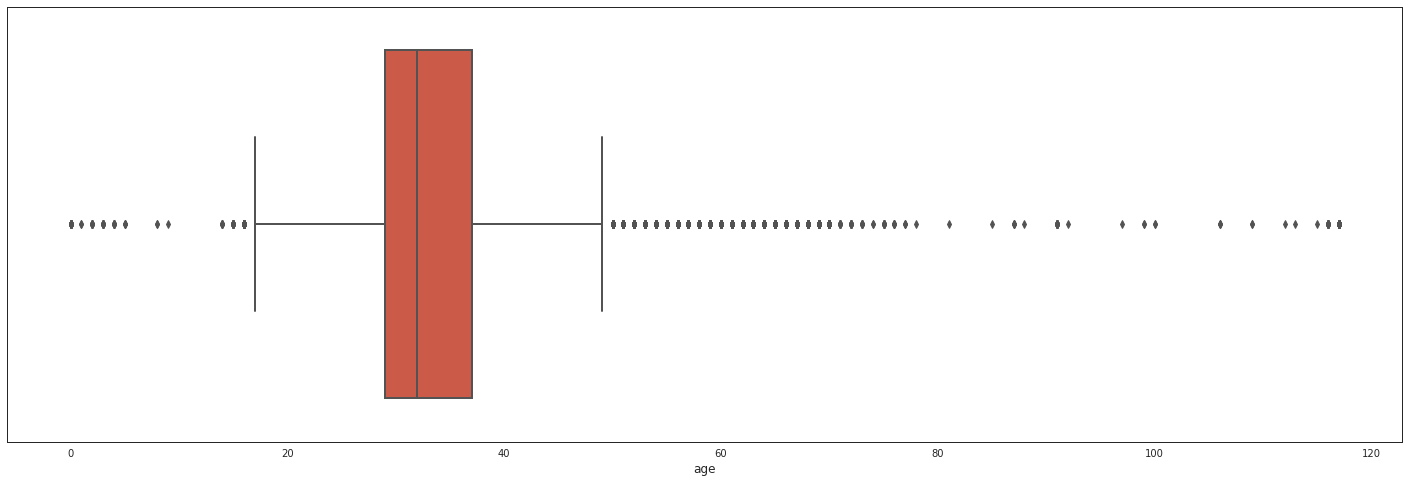

In [ ]:
fig = plt.figure(figsize=(25,8))
sns.boxplot(x=data_renttherunway_df['age'], linewidth=2)

As we can see above, we have maximum age as **117** and minimum as **0**. According to Google, average age of human is approximately is **79**. So, we are going to giving some slack to this average age, and cut short the age to **90 years** and fill anything above that with mean (**34** was the mean).

In [ ]:
ageOutliersCount = data_renttherunway_df.loc[((data_renttherunway_df['age'] == 0) | (data_renttherunway_df['age'] > 90), 'age')].shape[0]
ageOutliersCount

111

In [ ]:
ageMeanValueRounded = round(data_renttherunway_df['age'].mean())
ageMeanValueRounded

34

In [ ]:
data_renttherunway_df.loc[((data_renttherunway_df['age'] == 0) | (data_renttherunway_df['age'] > 90), 'age')] = ageMeanValueRounded

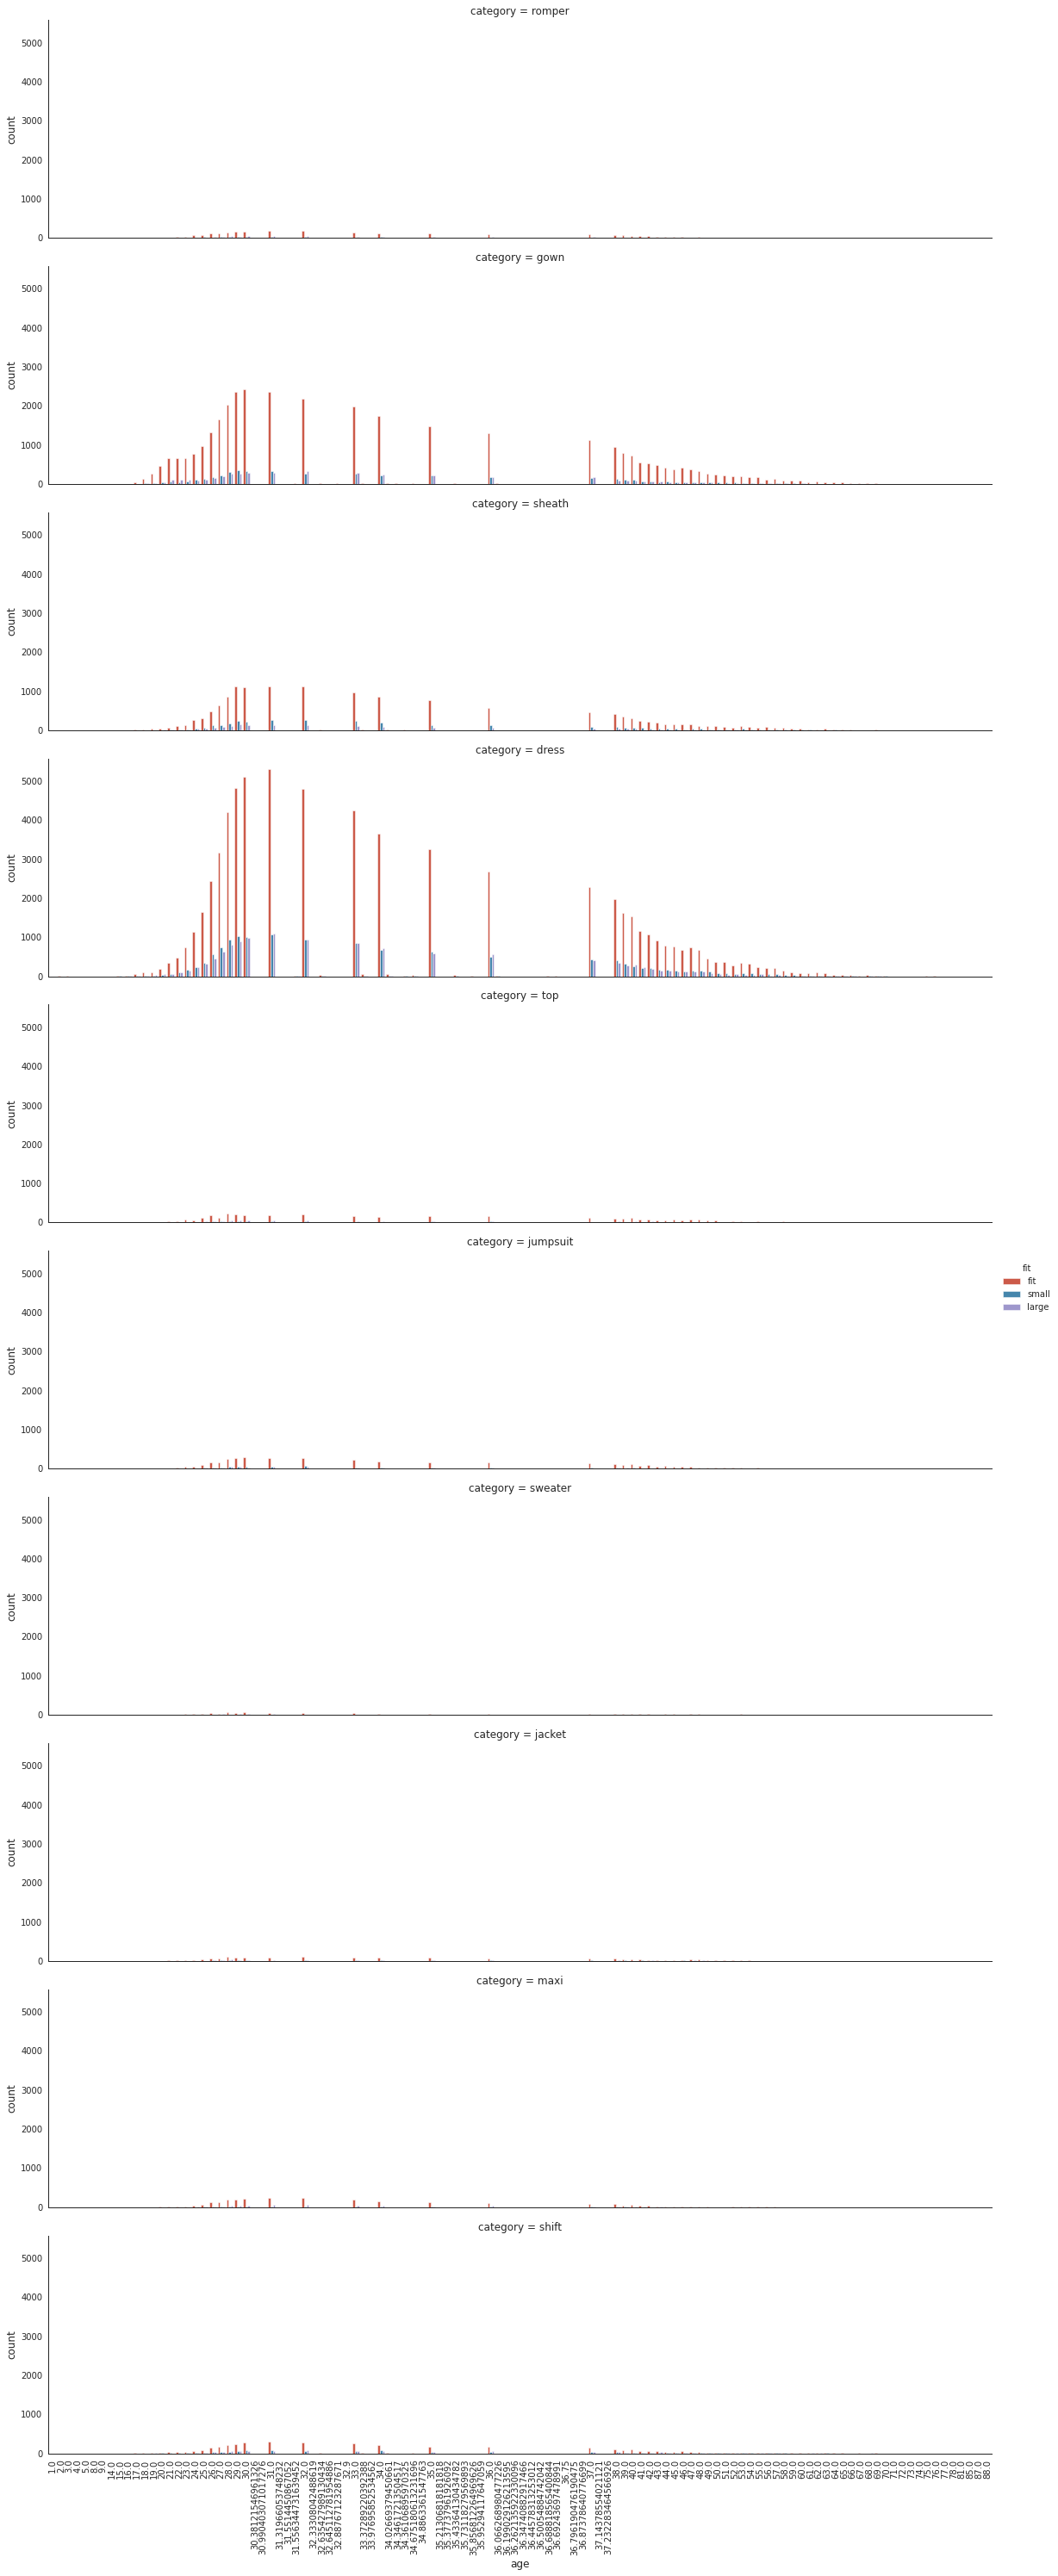

In [ ]:
#filtered categories with most data
filterCategoriesWithMostData = data_renttherunway_df[((data_renttherunway_df['category'] == 'dress') | (data_renttherunway_df['category'] == 'gown') | (data_renttherunway_df['category'] == 'sheath') | (data_renttherunway_df['category'] == 'top') | (data_renttherunway_df['category'] == 'jumpsuit') | (data_renttherunway_df['category'] == 'romper') | (data_renttherunway_df['category'] == 'jacket') | (data_renttherunway_df['category'] == 'sweater') | (data_renttherunway_df['category'] == 'maxi') | (data_renttherunway_df['category'] == 'shift'))]
g = sns.catplot(data=filterCategoriesWithMostData, x='age',kind='count', hue='fit', row='category', height=4, aspect=4)
g.set_xticklabels(rotation=90)

Looking at the above graph, we can make some of the following observations:

-  Between age 29 to 40, for categories **gown, sheath & dress** there are fit feedback in majority but the count of small and large reported items for the same categories are also large as compared to other categories.
- In categories such as romper, maxi, shift, jumpsuit & top, there is fitness in majority, but undersizing and oversizing count is not as significant.
- Also, the age range of users shopping in above criteria lies in **29 to 57**. It can be said they comprise more than **90%** of feedbacks in above plots.


## **Quality/Rating**

#### ModCloth

There are 68 records which haven't provided any quality values. This accounts for 0.082%. We are filling those missing values with mean.

In [ ]:
qualityMeanModCloth = round(data_modcloth_df['quality'].mean())
data_modcloth_df['quality'] = data_modcloth_df['quality'].fillna(qualityMeanModCloth)

category
bottoms      4.0
dresses      4.0
new          4.0
outerwear    4.0
sale         4.0
tops         4.0
wedding      5.0
Name: quality, dtype: float64


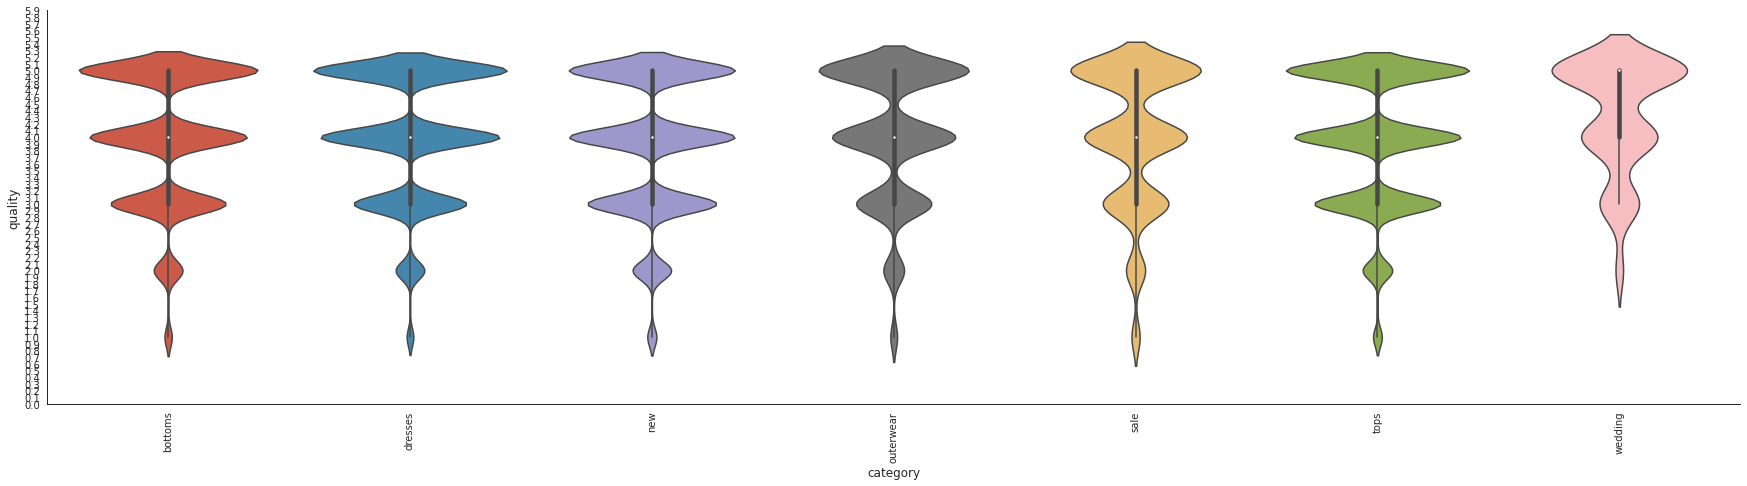

In [ ]:
print(data_modcloth_df.groupby('category')['quality'].median())
g = sns.catplot(data=data_modcloth_df, x='category', y='quality', kind='violin', height=6, aspect=4)
g.set_xticklabels(rotation=90)
g.set(yticks = np.arange(0, 6, step=0.1))

For visualizing quality ratings against categories for ModCloth Dataset, we opt for violin plots. This is because in addition to showing statistics about Median, Interquartile ranges like boxplots, we get to see distribution of data and as can be seen clearly, we can see that each category has rating distribution with multiple peaks. 

- For all categories, majority distribution of quality ratings lies where the peaks are in that categories' violin plot i.e. for Quality 3, 4 & 5.
- Medians for all categories are 4 with wedding as exception, 5. That could be because of relatively less number of ratings/transactions with that category and majority of them being 5.

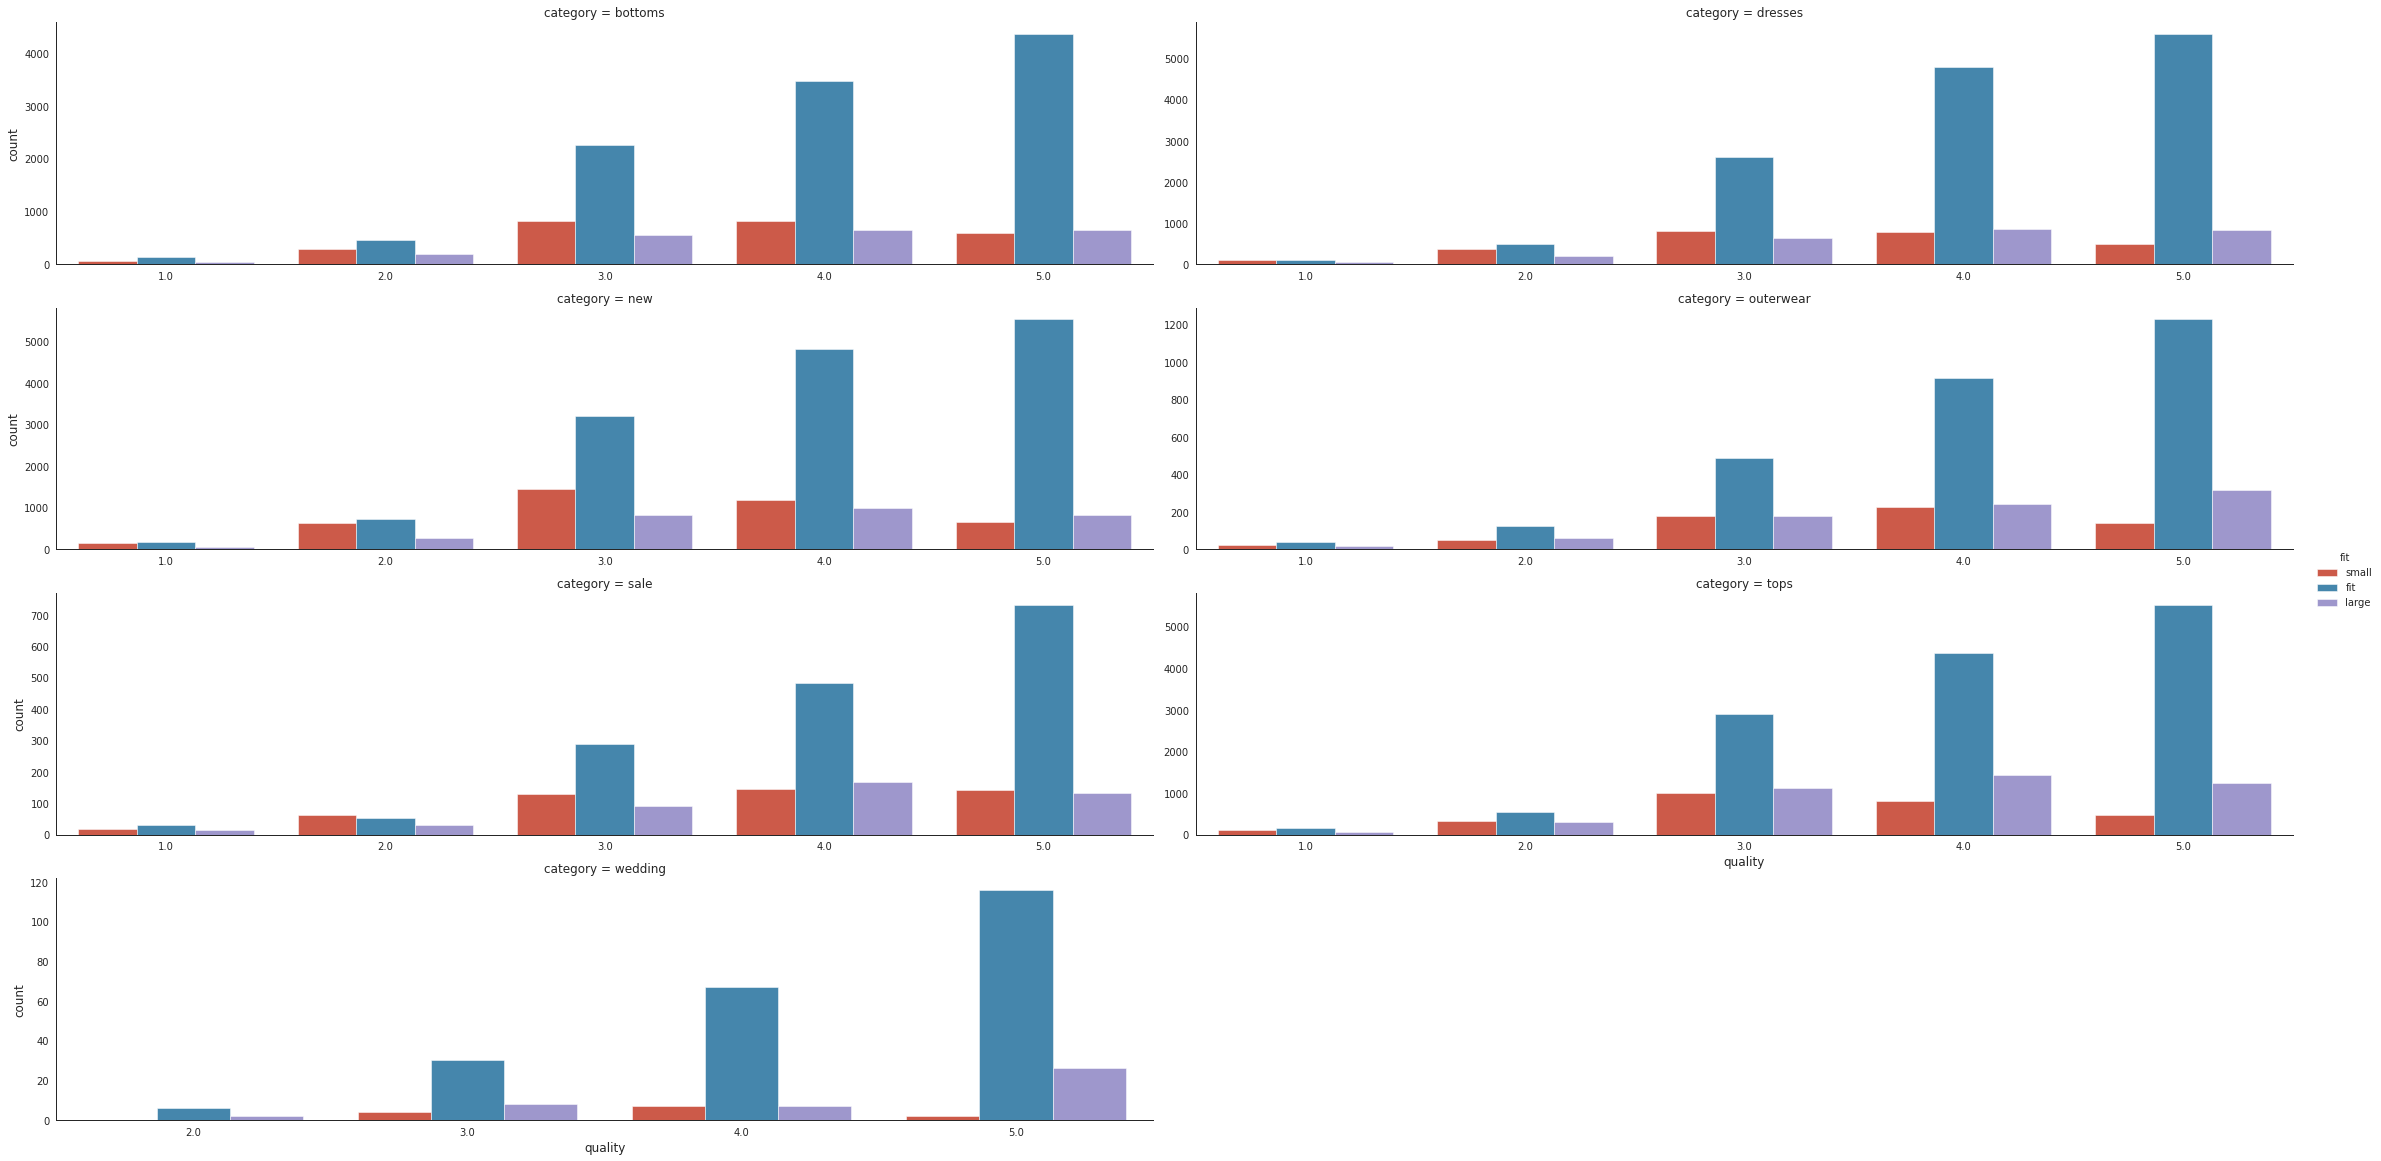

In [ ]:
g = sns.catplot(data=data_modcloth_df, x='quality',kind='count', hue='fit', col='category', height=4, aspect=4, col_wrap=2, sharey=False, sharex=False)

From above plot we can see that in all categories of ModCloth dataset, there is "Fit" feedback in majority associated with all ratings. To nitpick, we can observe the following:

- New, tops & dresses have users who have rated fitness as small. The count for them is approximately more than 1 thousand.
- Tops, new & dresses also have items with fitness as large and their count are also close to 1 thousand.

#### RentTheRunWay

There are 82 records which haven't provided any quality values. This accounts for 0.043%. We are filling those missing values with mean. Additionally, to match rating scale with ModCloth, we are dividing the ratings by 2 and rounding them.

In [ ]:
qualityMeanRentTheRunWay = round(data_renttherunway_df['rating'].mean())
data_renttherunway_df['imputedRating'] = data_renttherunway_df['rating'].fillna(qualityMeanRentTheRunWay)
data_renttherunway_df['imputedRating'] = data_renttherunway_df['imputedRating'].div(2).round()

In [ ]:
# data_renttherunway_df.groupby('category').size()
data_renttherunway_df['category'][data_renttherunway_df['category'].notnull()].value_counts(normalize=True,dropna=False).head(10)

dress       0.482404
gown        0.230498
sheath      0.100320
shift       0.027864
jumpsuit    0.026924
top         0.025610
maxi        0.017882
romper      0.015944
jacket      0.012485
mini        0.009094
Name: category, dtype: float64

From above we can see categories: **dress, gown, sheath, shift, jumpsuit, top, maxi, romper and jacket** accounts for **90%** of transactions in our data. So for visualizations below, we are going to plot for only these categories.

In [ ]:
filterCategoriesWithMostData = data_renttherunway_df[((data_renttherunway_df['category'] == 'dress') | (data_renttherunway_df['category'] == 'gown') | (data_renttherunway_df['category'] == 'sheath') | (data_renttherunway_df['category'] == 'top') | (data_renttherunway_df['category'] == 'jumpsuit') | (data_renttherunway_df['category'] == 'romper') | (data_renttherunway_df['category'] == 'jacket') | (data_renttherunway_df['category'] == 'maxi') | (data_renttherunway_df['category'] == 'shift'))]

category
dress       5.0
gown        5.0
jacket      5.0
jumpsuit    5.0
maxi        5.0
romper      5.0
sheath      5.0
shift       5.0
top         5.0
Name: imputedRating, dtype: float64


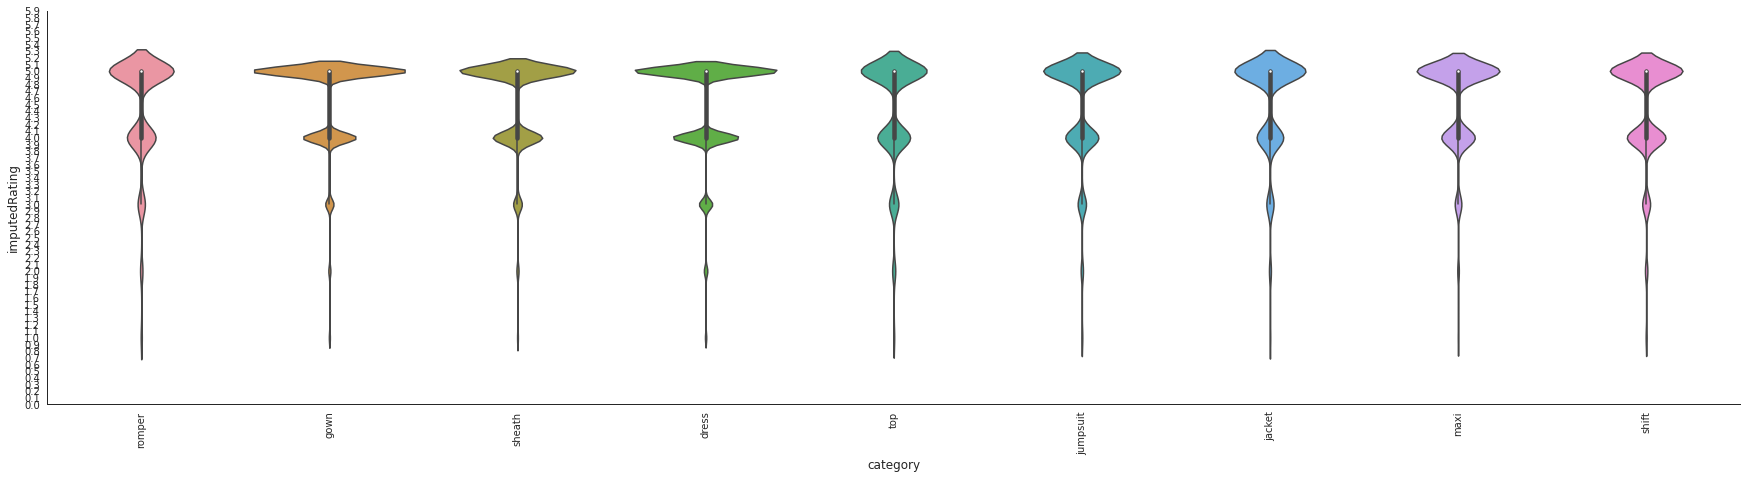

In [ ]:
print(filterCategoriesWithMostData.groupby('category')['imputedRating'].median())
g = sns.catplot(data=filterCategoriesWithMostData, x='category', y='imputedRating', kind='violin', height=6, aspect=4)
g.set_xticklabels(rotation=90)
g.set(yticks = np.arange(0, 6, step=0.1))

Upon seeing the violin plot graph for ratings against popular categories for RentTheRunWay dataset, we can make following observations:

- Gown and Dress have higher distribution at rating 5 & 4. Other categories have almost similar distribution count for these two ratings.
- There is very few transactions for all categories in the plot with ratings less than 3 and thus the violin plot has pretty flat curve around those ratings.

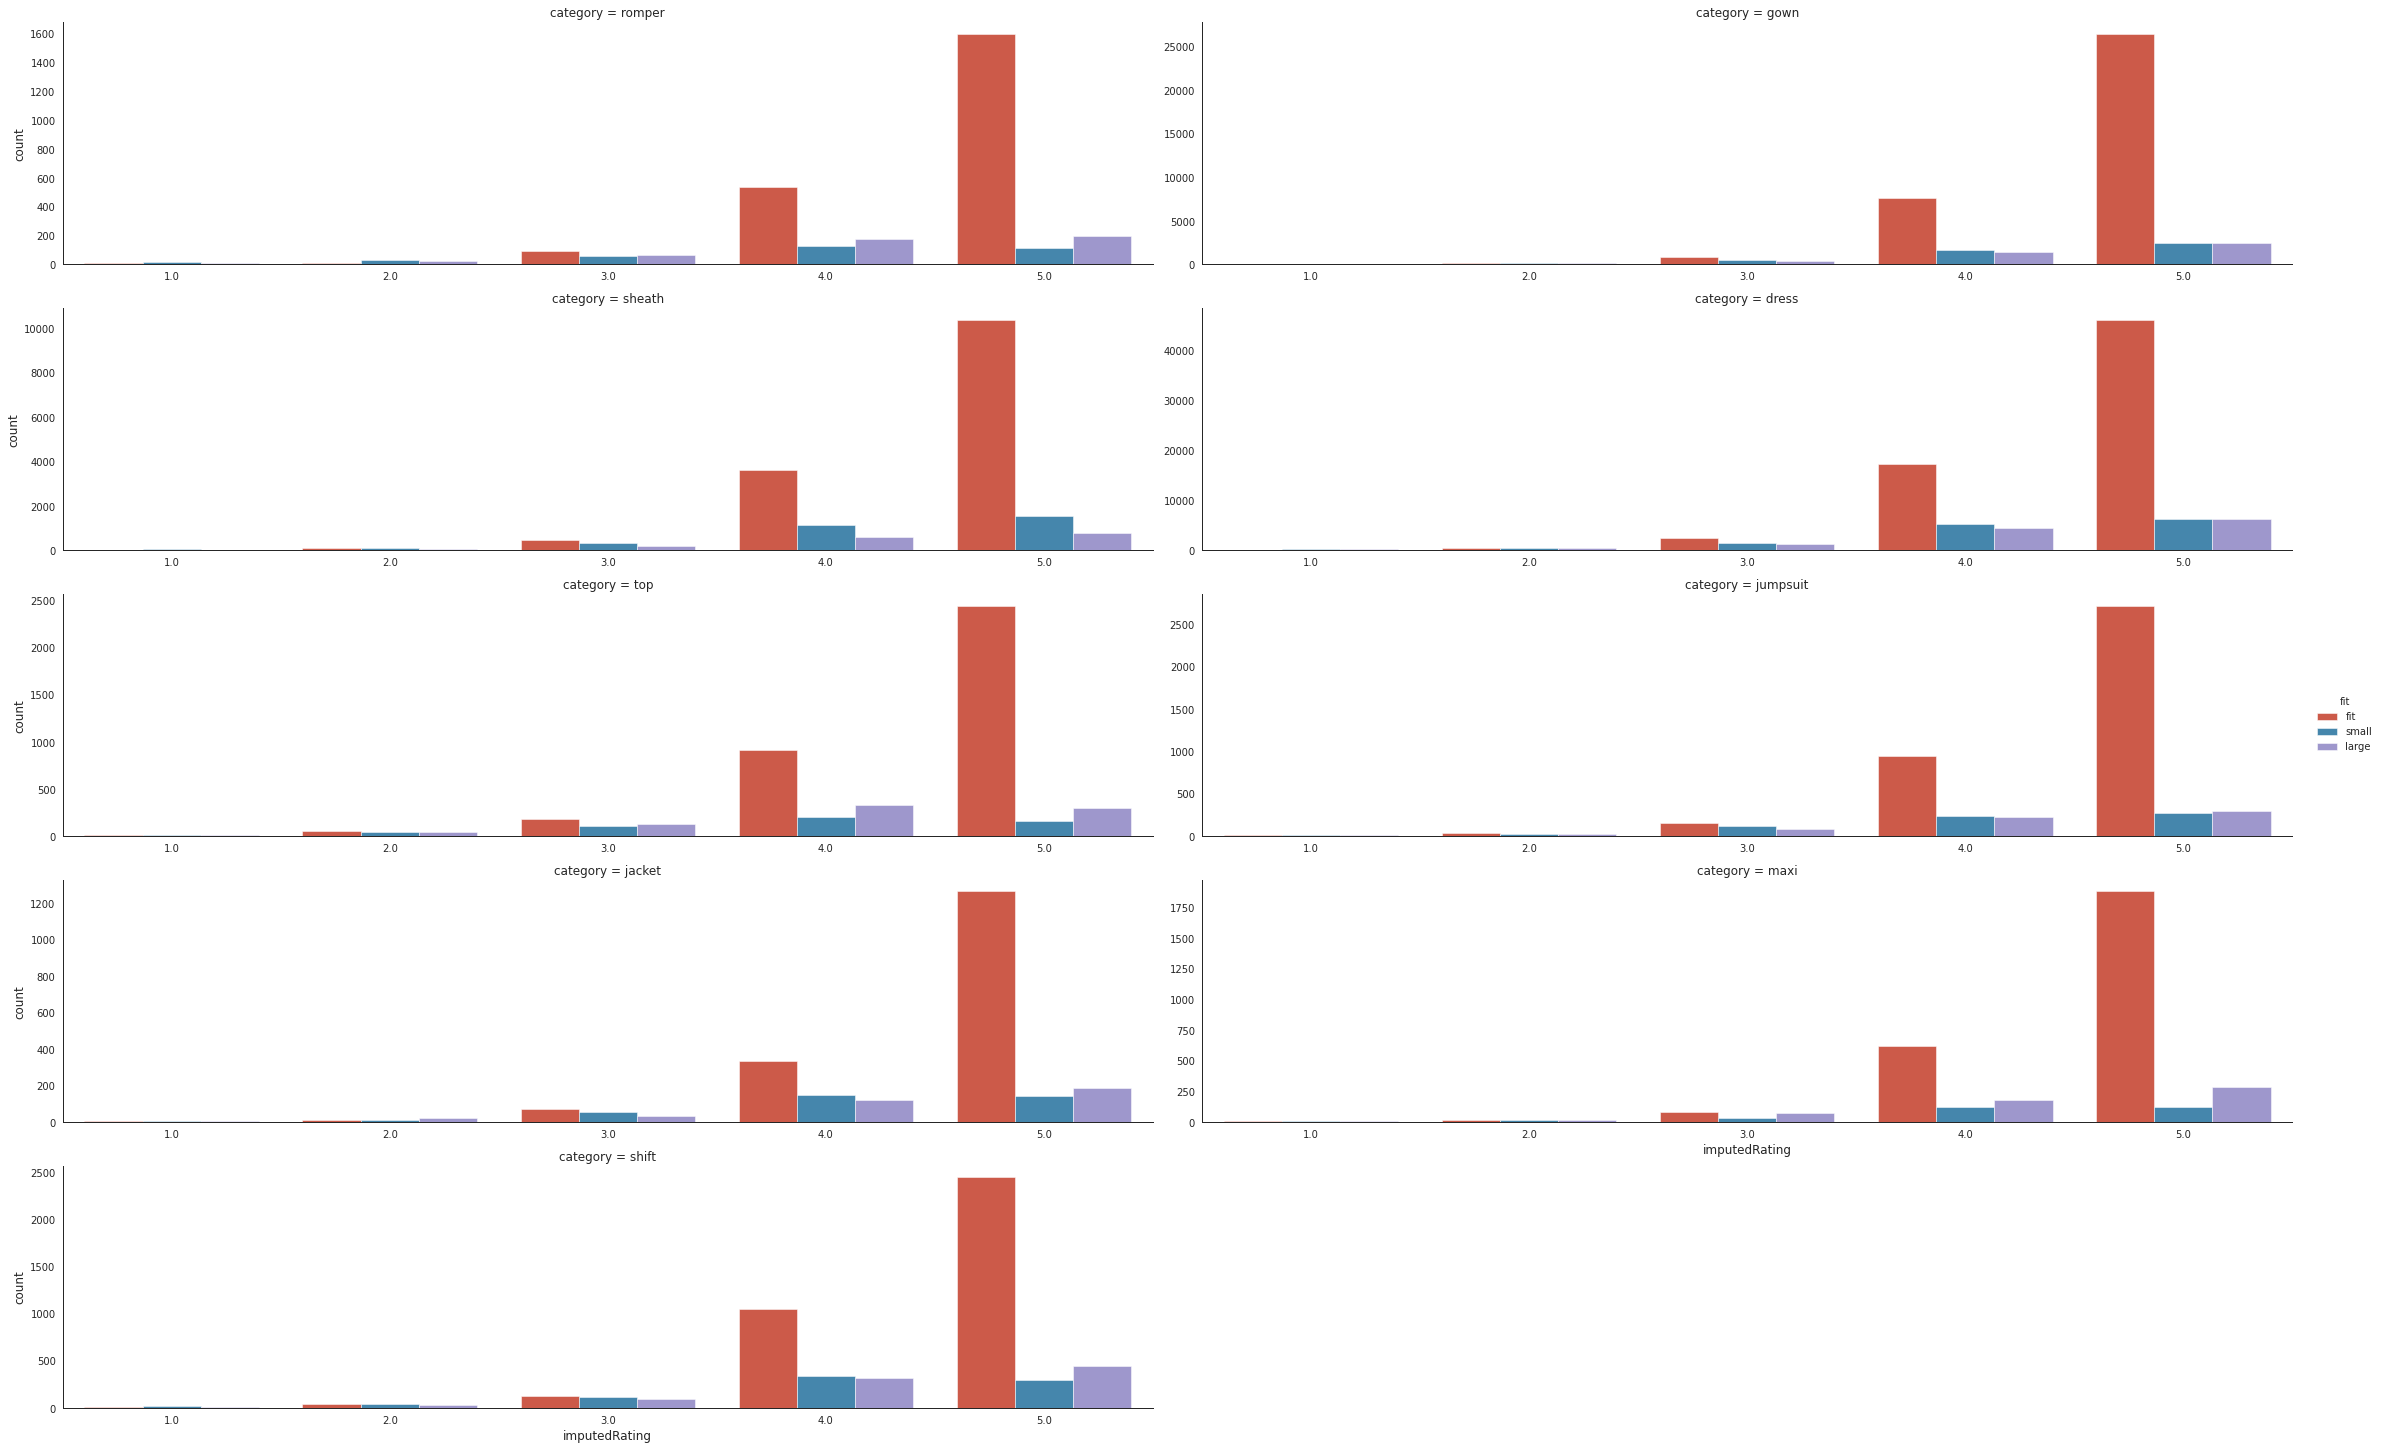

In [ ]:
g = sns.catplot(data=filterCategoriesWithMostData, x='imputedRating',kind='count', hue='fit', col='category', height=4, aspect=4, col_wrap=2, sharey=False, sharex=False)

From the above graph, following observations can be seen:

- Dress, Sheath & Gown counts for majority of items. Among them majority of returns due to improper sizing (large/small) are in **Dress followed by Gown and then followed by Sheath**.
- Inspite of huge number of wrong fittings, the ratings for the items is **>=3** for almost all transactions in our data.

## **Size**

**Modcloth**

To get hold of the data available, let's plot the size column of the Modcloth dataset. There are no missing values for size column.

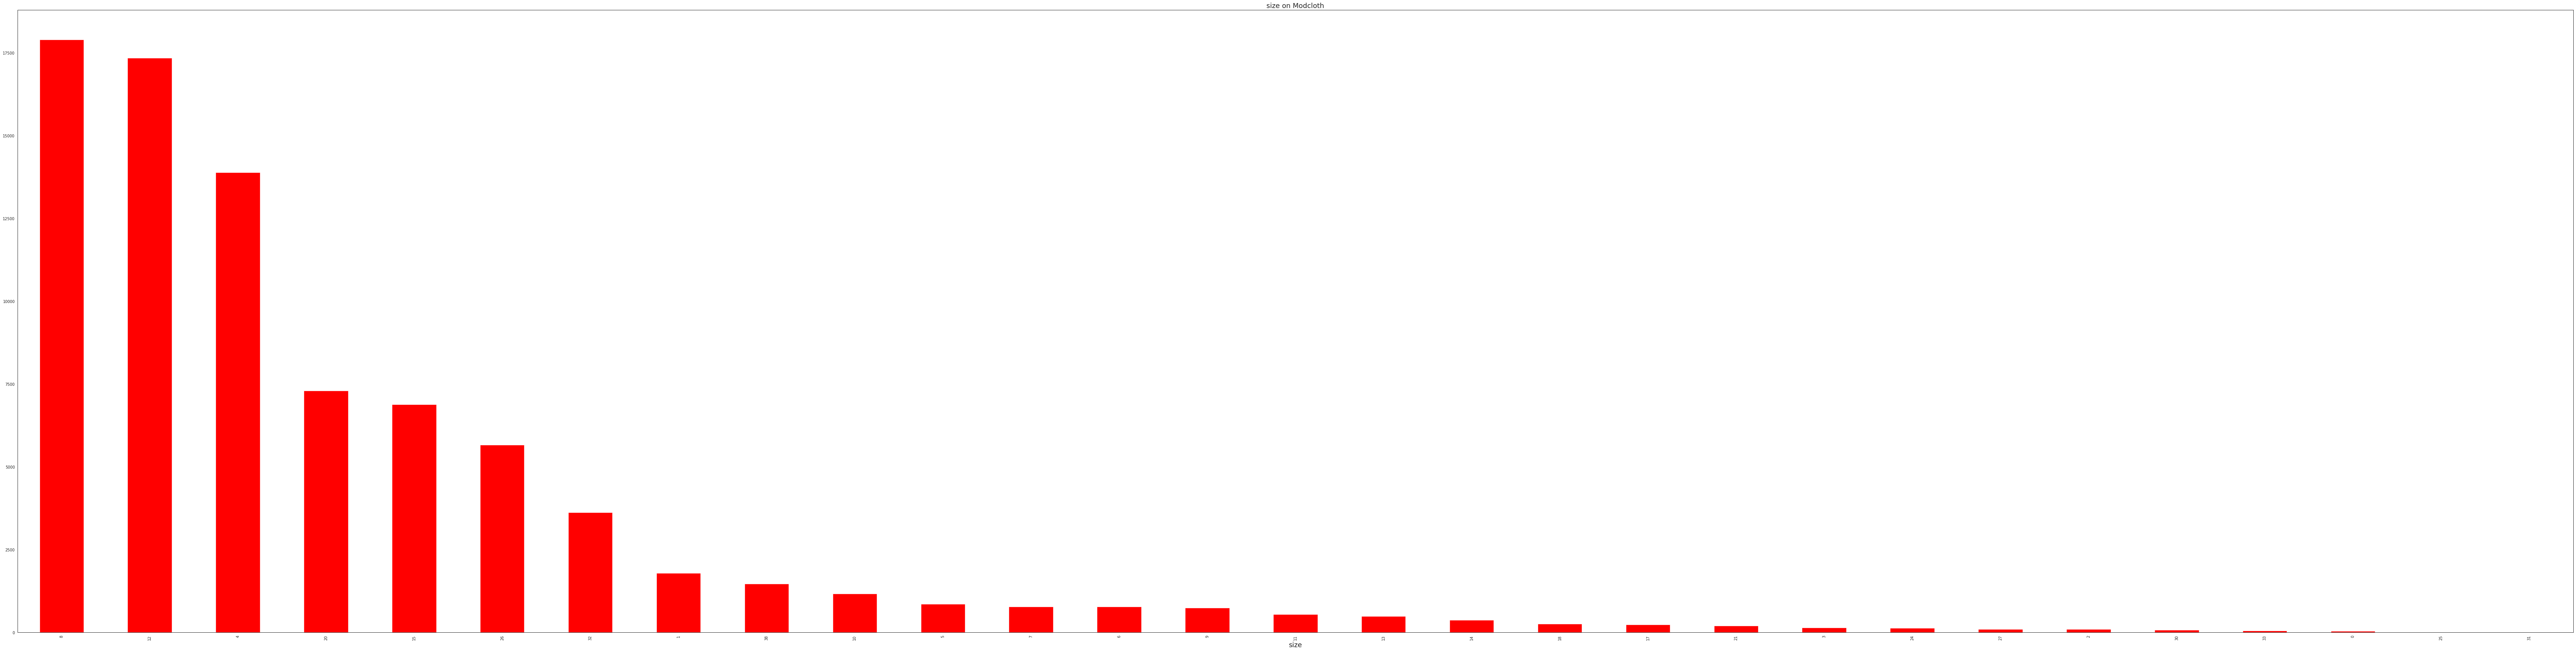

In [ ]:
fig, ax = plt.subplots(figsize = (120,30))
cols = ['size']
frequencyCountByValue(data_modcloth_df, cols[0],'Modcloth',ax)

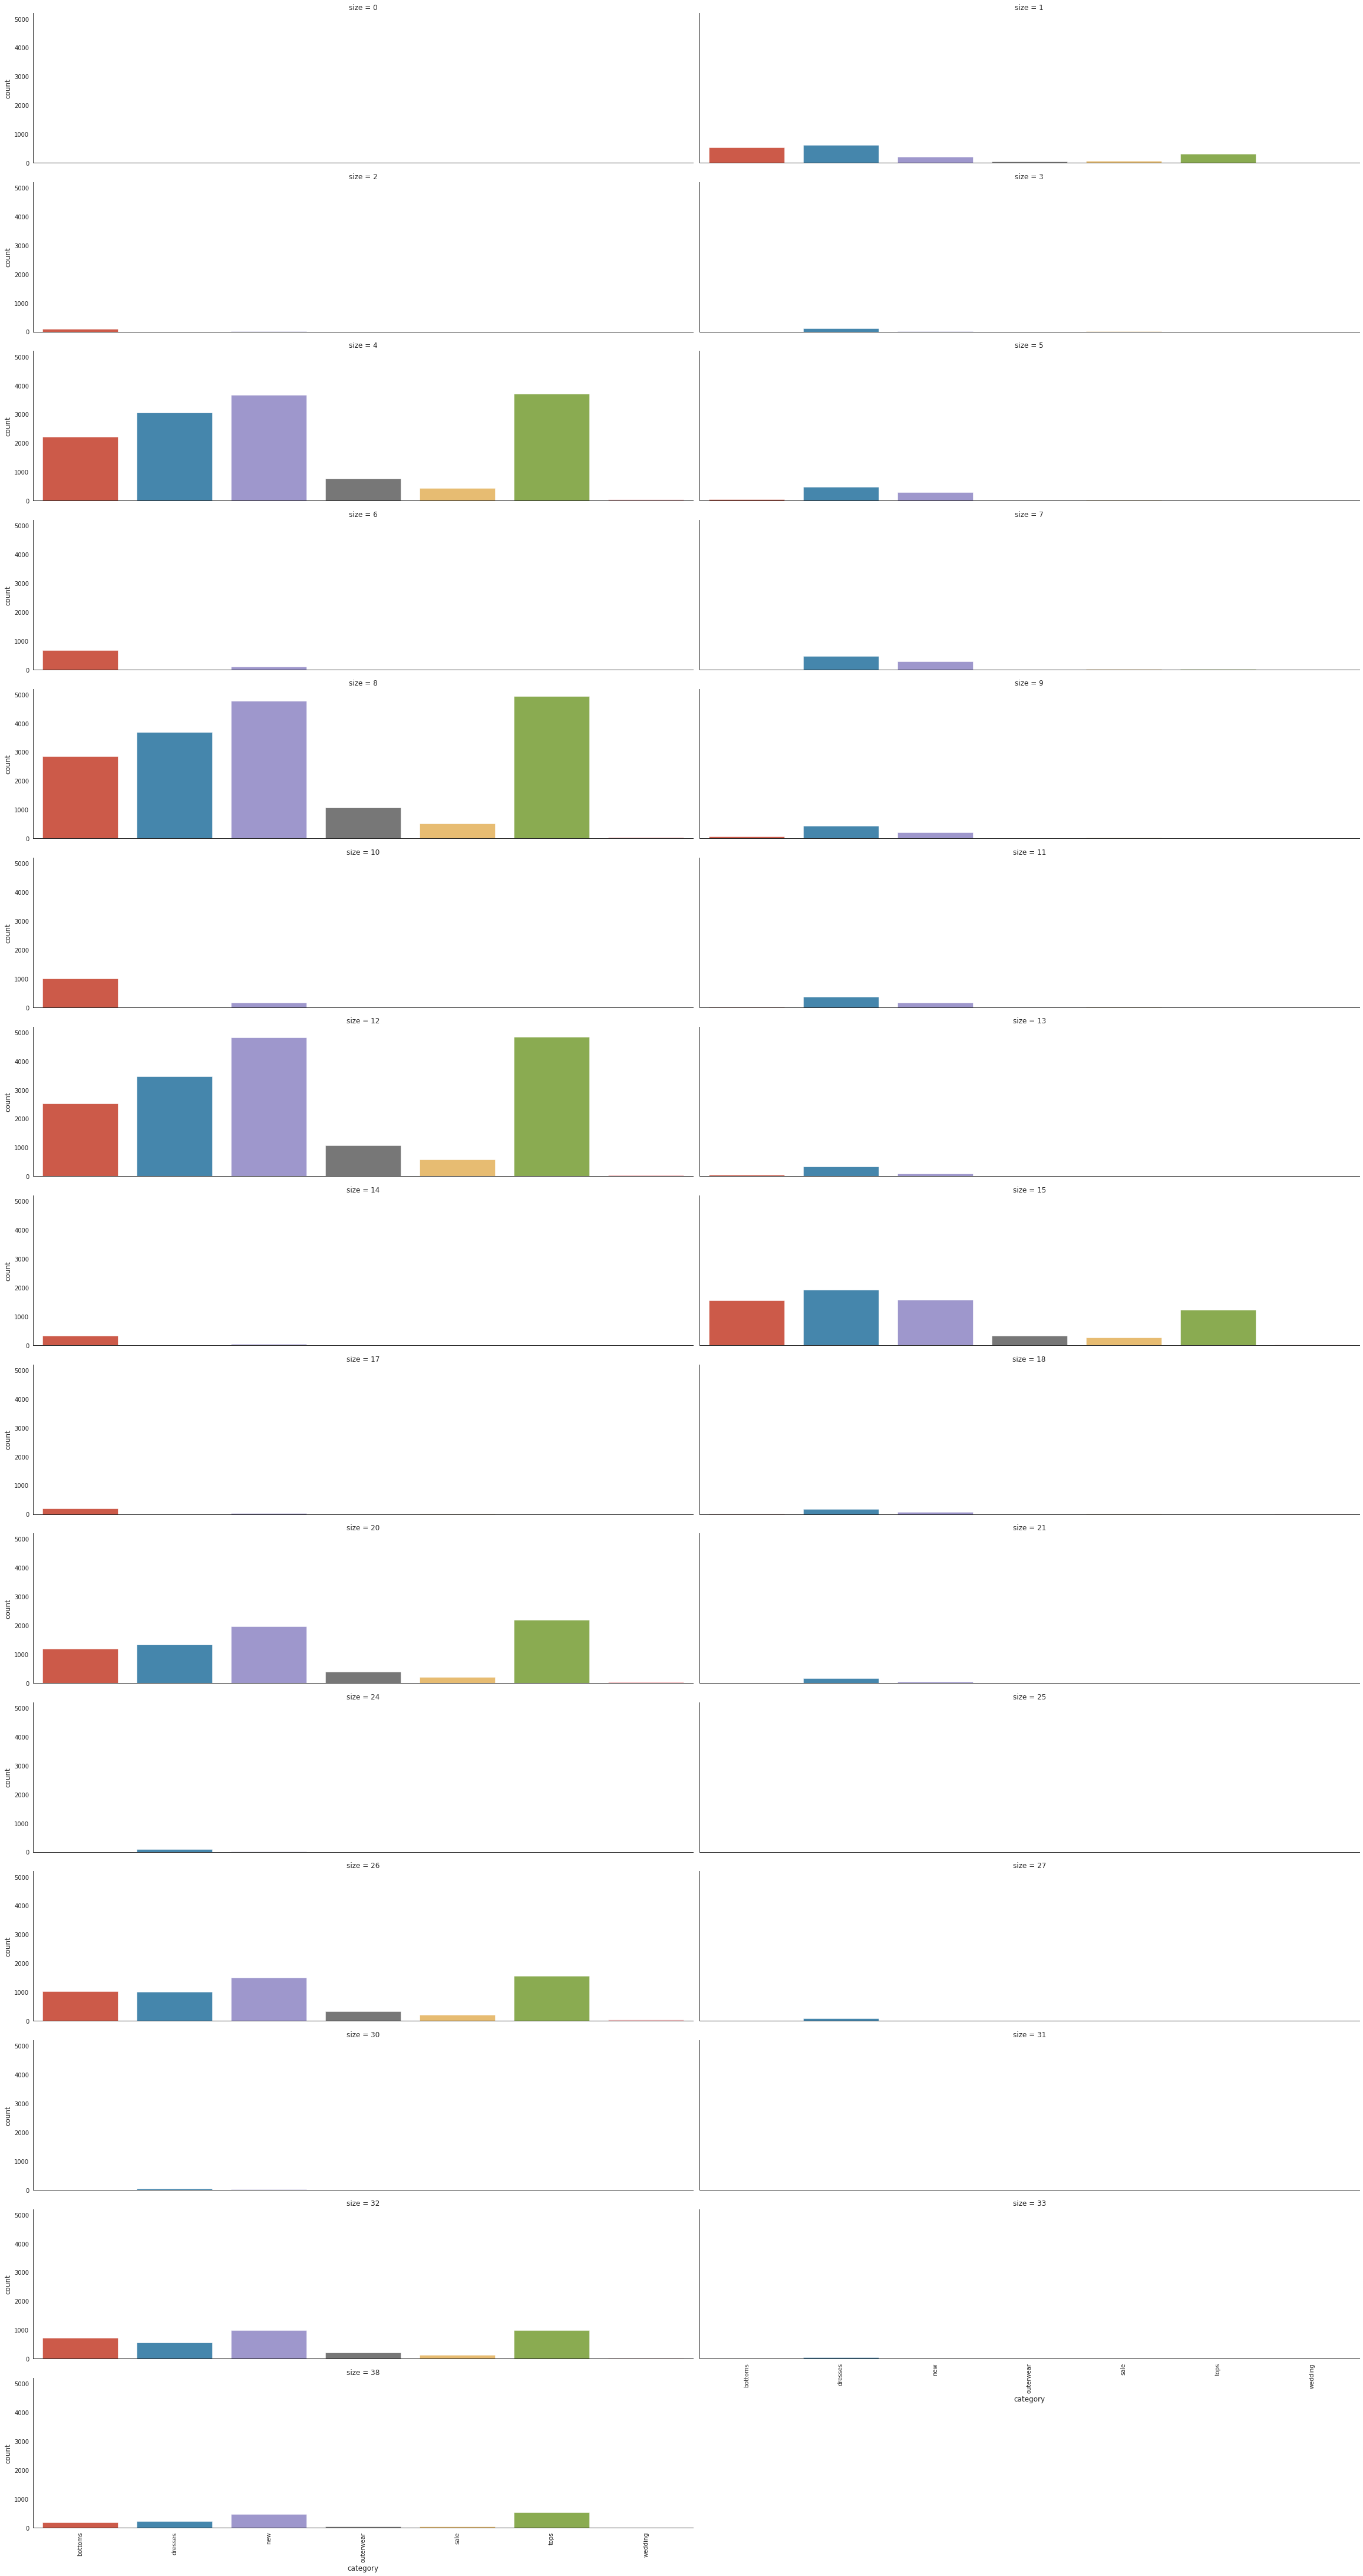

In [ ]:
g = sns.catplot(data=data_modcloth_df, x='category',kind='count', col='size', height=4, aspect=4, col_wrap=2)
g.set_xticklabels(rotation=90)

Looking at the graphs above, it is unclear about how to segregate shoe sizes and clothing sizes as it can be seen that clothing sizes range from 1 to 38 (missing few sizes in between) and there is no category for shoes in the dataset. From the computations done above for shoe size and width, it was inferred that most rows that have shoe sizes present belong to "new" category. But since, a lot of clothing items belong to the same category, there is no way for segregation. So we will have to leave sizes as it is.

**RentTheRunWay**

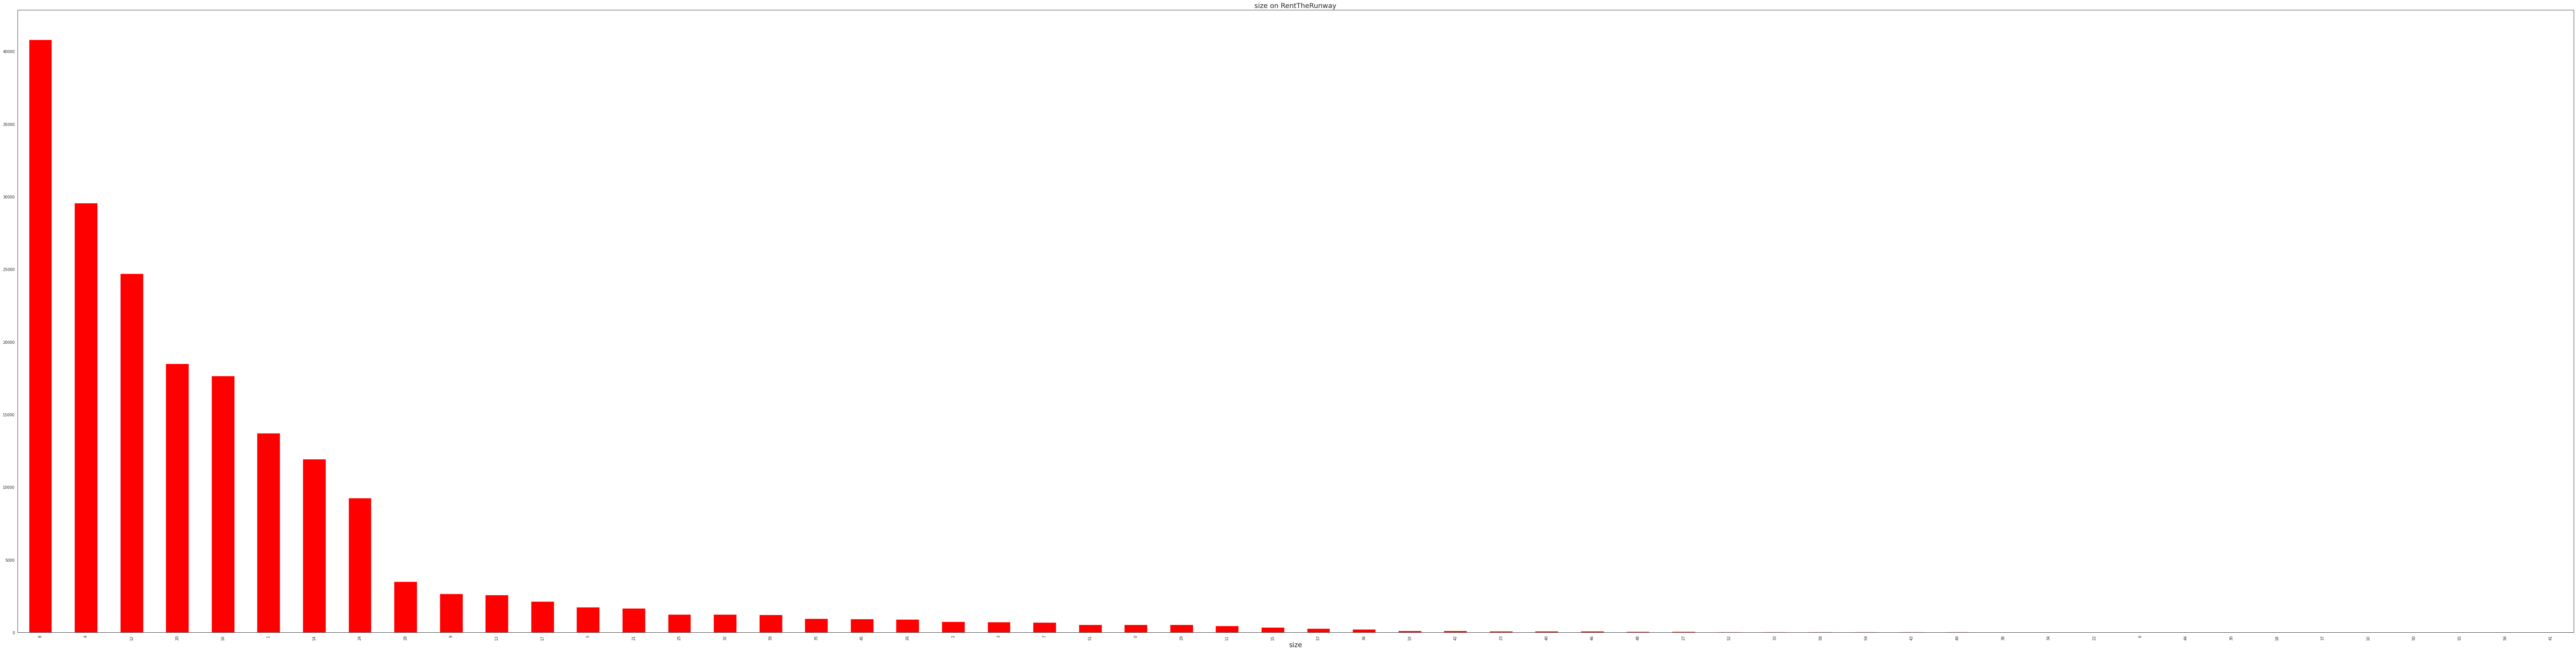

In [ ]:
fig, ax = plt.subplots(figsize = (120,30))
cols = ['size']
frequencyCountByValue(data_renttherunway_df, cols[0],'RentTheRunway',ax)

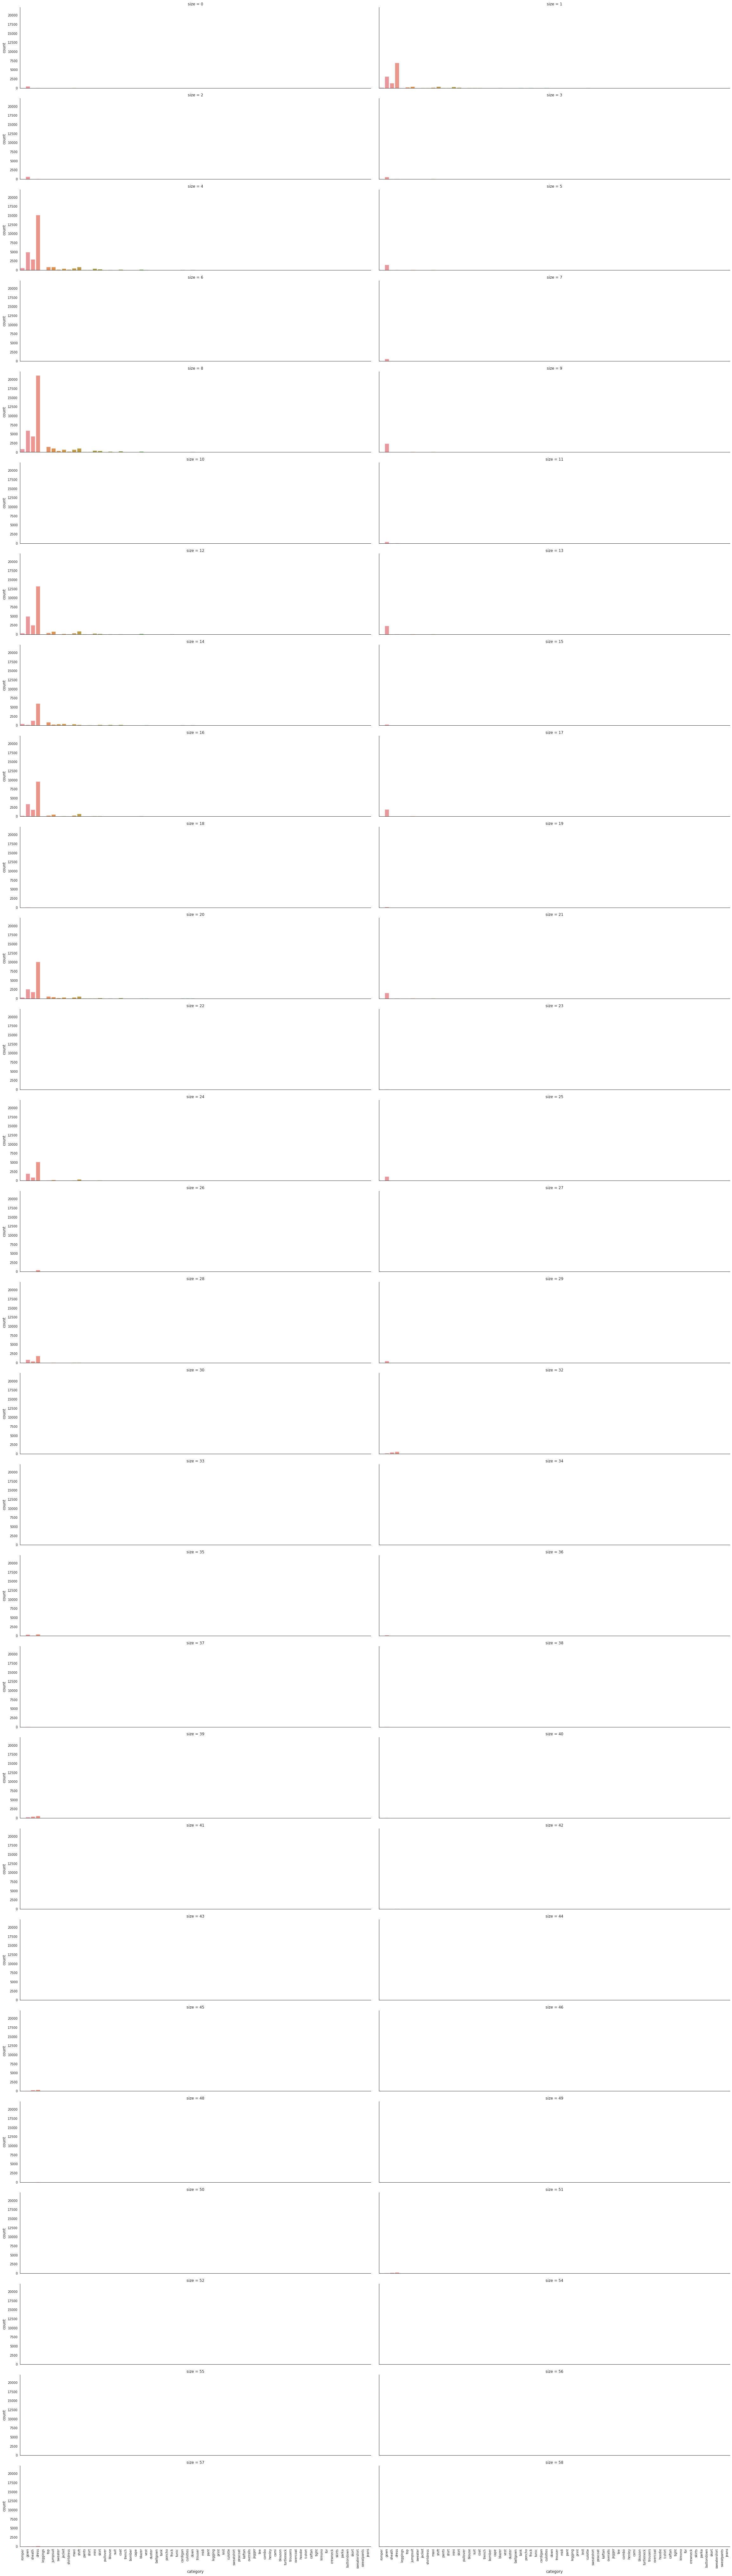

In [ ]:
g = sns.catplot(data=data_renttherunway_df, x='category',kind='count', col='size', height=4, aspect=4, col_wrap=2)
g.set_xticklabels(rotation=90)

Similarly, no inferences can be made for size column of the RentTheRunWay as the sizes lie between 1 and 48 for dress category. So, we need to remove this column.


## **Length**

ModCloth

There are 35 rows or 0.042% of transations/records/items where there is no value for length feature given. It probably could be as user did not provide feedback regarding the length of the item they purchased. By logic, length should be somehow related to the fit feedback and other feedback related features such as review text and summary. Parsing review text and summary to possibly get length would be too much for current scope and thus we will be considering fit feedback and the category to impute missing length values.

In [ ]:
# data_modcloth_df.groupby(['category','fit'])['length'].value_counts().head(30)
print(data_modcloth_df['length'].isnull().sum())
data_modcloth_df = imputeLengthForModCloth(data_modcloth_df)
print(data_modcloth_df['imputed_length'].isnull().sum())

35
0


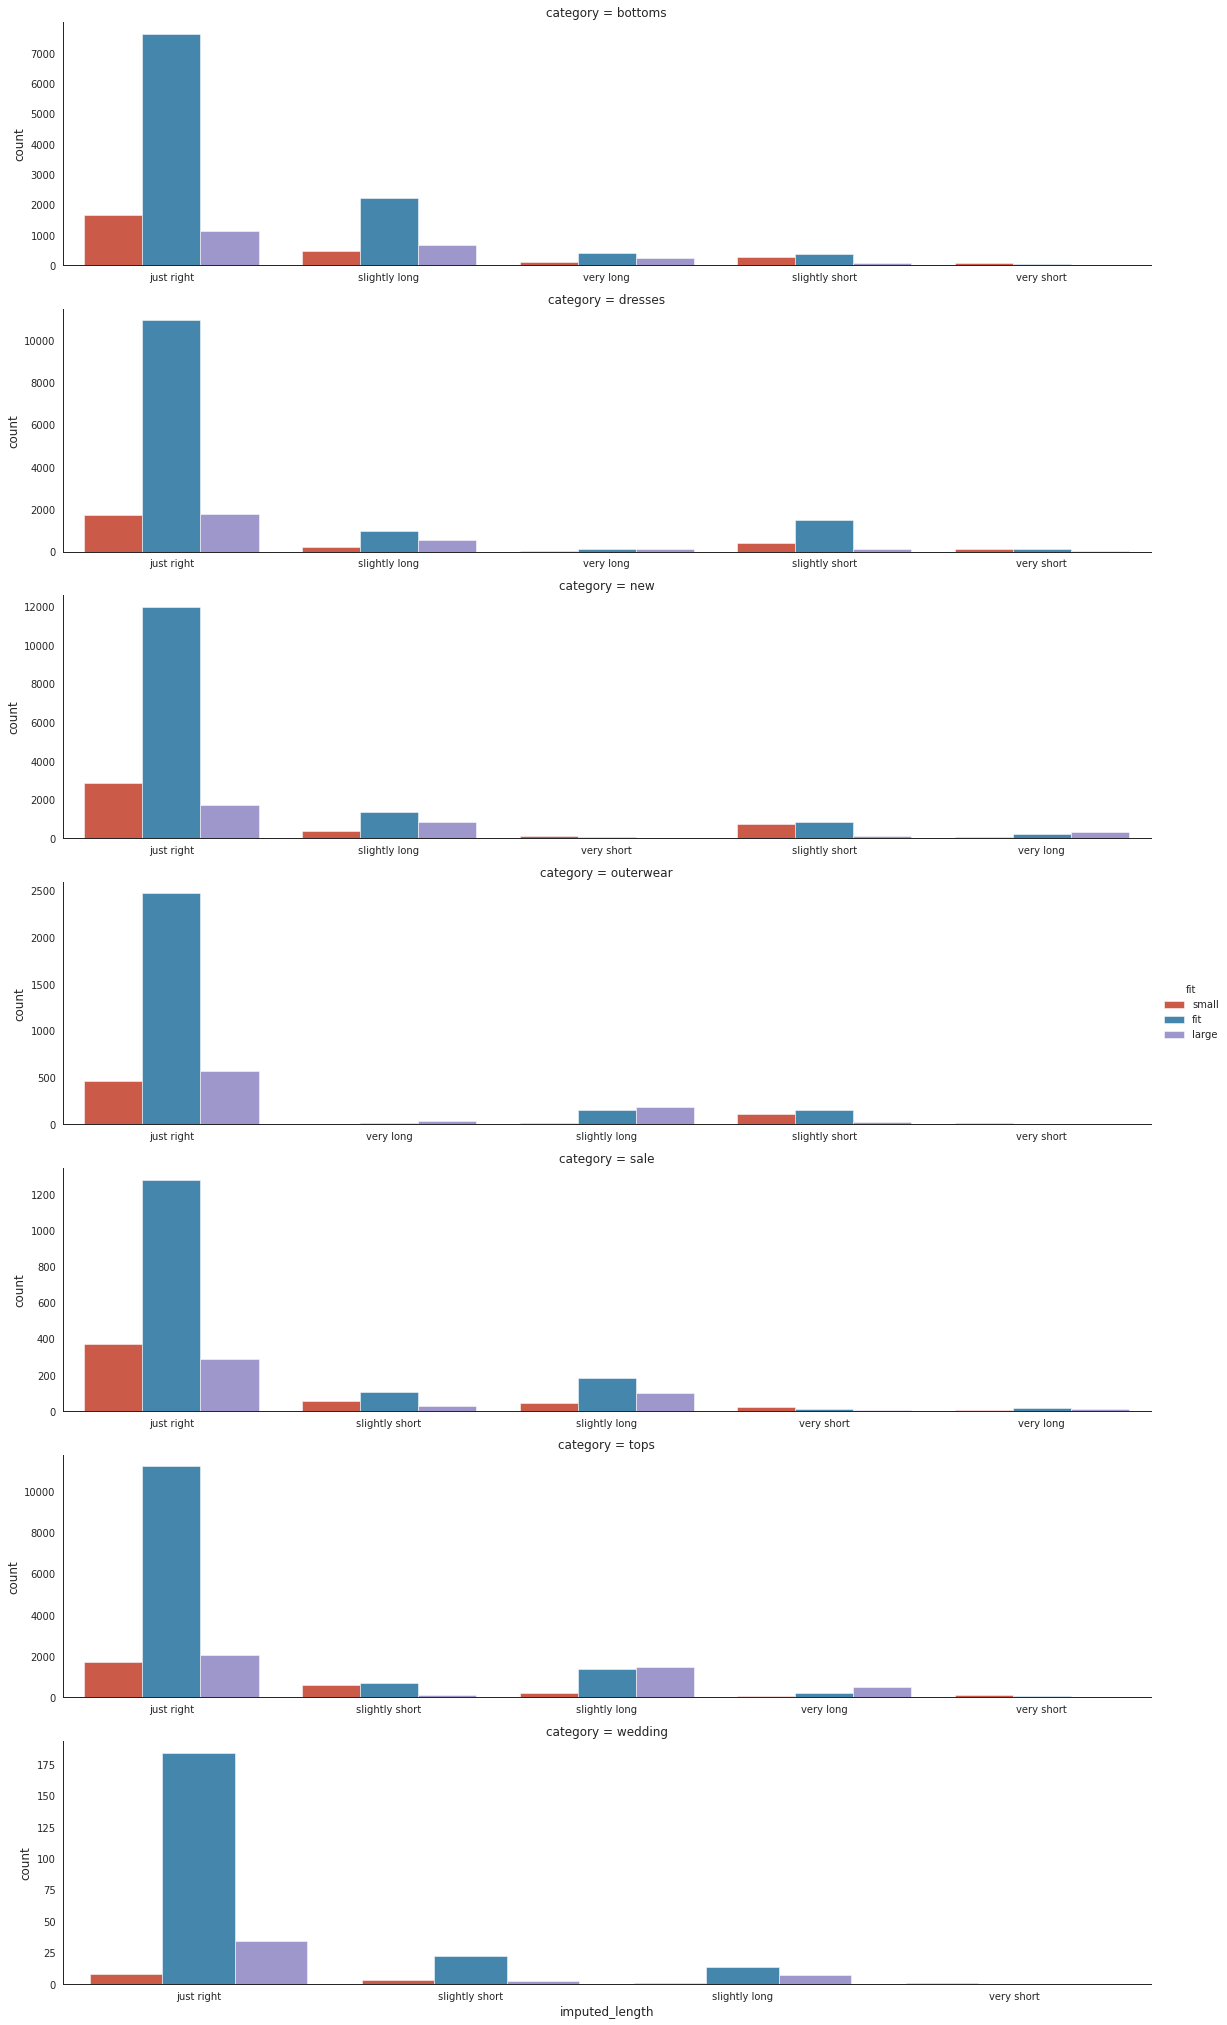

In [ ]:
g = sns.catplot(data=data_modcloth_df, x='imputed_length', kind='count', row='category', hue='fit', height=4, aspect=4, sharey=False, sharex=False)

Seeing the above graph of count of length for each category and the fit feedback we can make following observations:

- In each category, majority of users have given length feedback as right and the fit feedback is also fit. This shows that for each category majority users are able to get the fit they wanted with the size ordered. 
- In each category, even though the length is just right, approximately **20-25%** users have given the fit as either small or large, meaning the width might have been an issue.
- For users having length feedback as slightly long, or slight short, it means the length is very close to perfect length they wanted and thus we see majority of distribution of fit feedback count in those length types too.

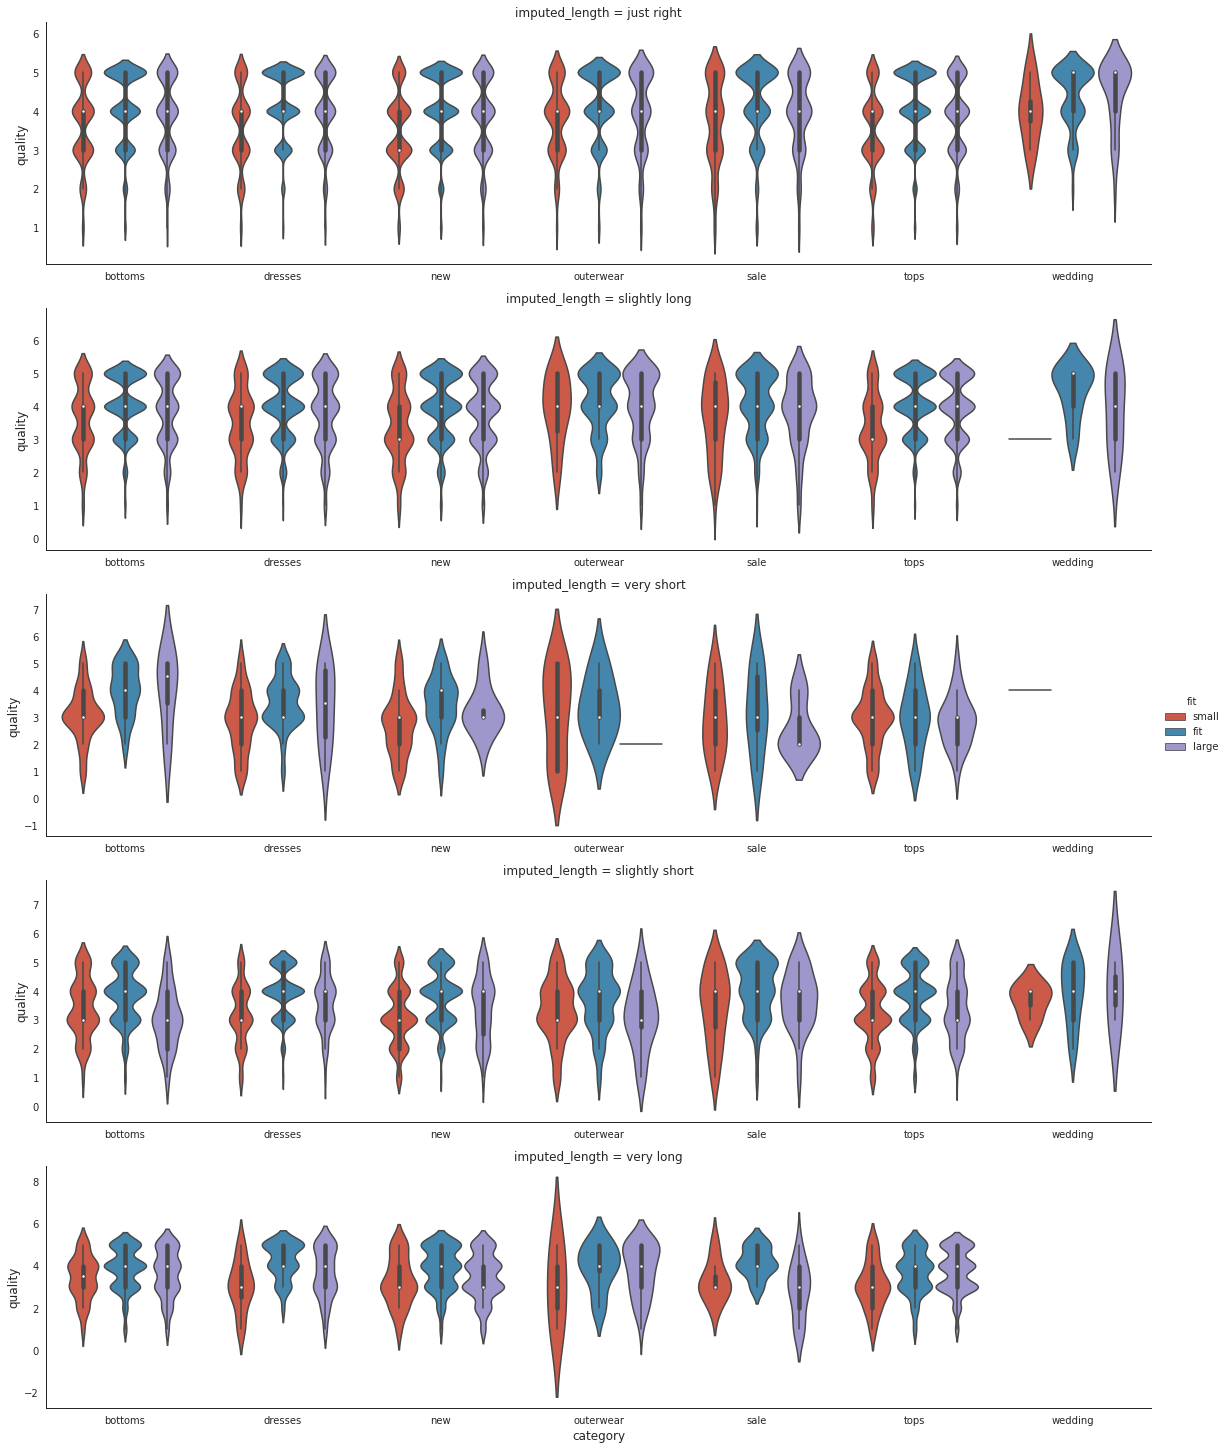

In [ ]:
g = sns.catplot(data=data_modcloth_df, x='category', y='quality', kind='violin', row='imputed_length', hue='fit', height=4, aspect=4, sharey=False, sharex=False)

Seeing above violin plots separated by length and for each length having category in x-axis and quality in y-axis, from the distribution shown in violin plots we can infer the below:

- For length as just right, slightly short & slightly long, users have rated majority with **>=3**, with very less distribution, comparatively, for values **<3** present.
- Where the length is very long and very short, we observe, the ratings shift to majority lying **<=4**. There is distribution for values >4 too, but its relatively less.
- For length just right, slightly short/long the median of quality for all fit feedback is mostly **4 or 5**. But for length very short and very long, the median comes to **2.5 to 4** which is expected behavior.

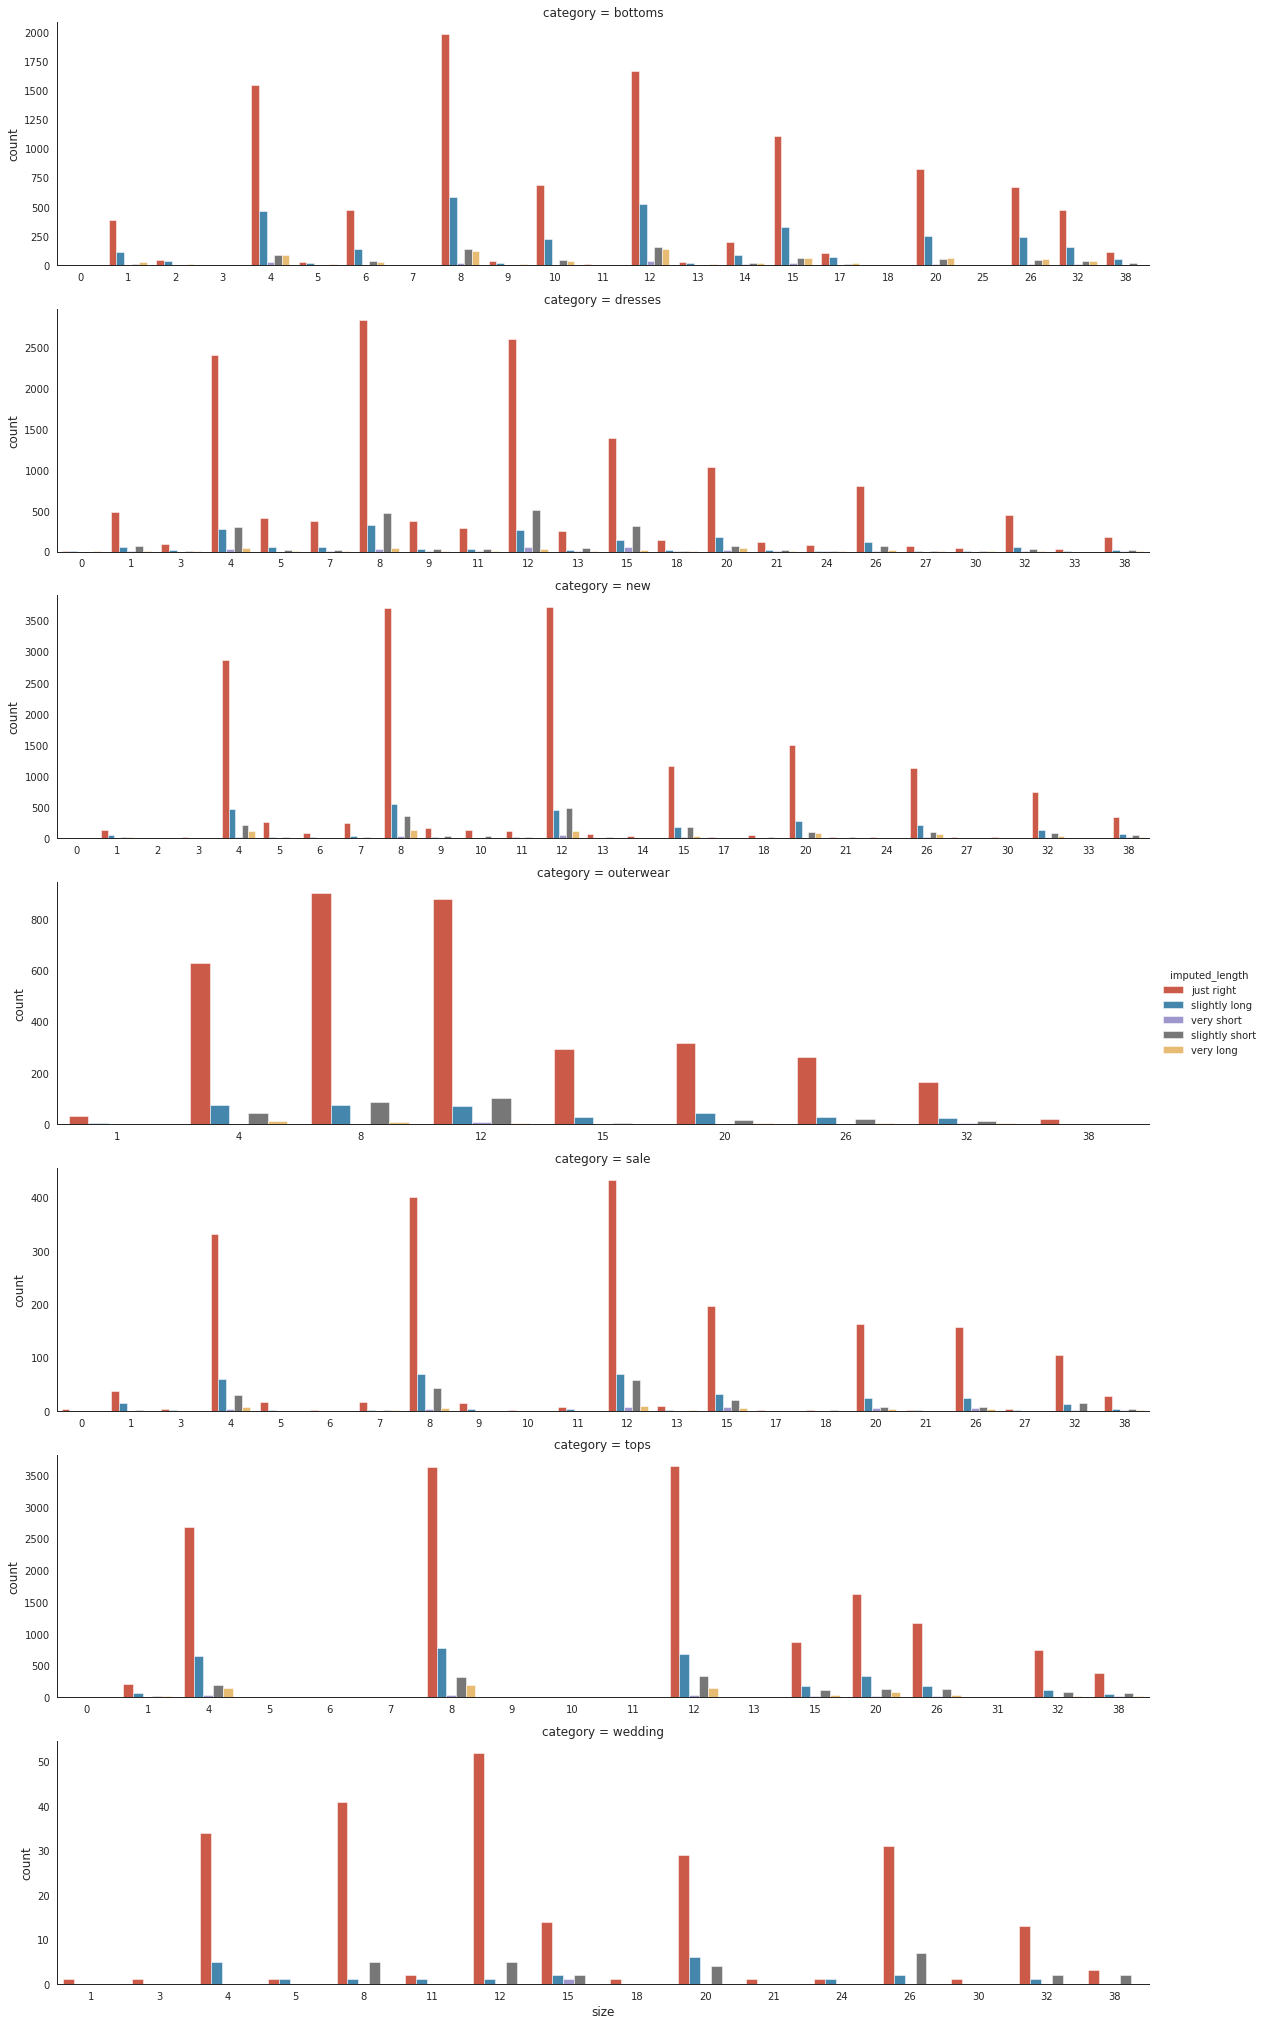

In [ ]:
g = sns.catplot(data=data_modcloth_df, x='size', kind='count', row='category', hue='imputed_length', height=4, aspect=4, sharey=False, sharex=False)

Seeing the above graph for relationship between size, length for each category we can make the following observations:

- For category **bottoms, tops & new**, amongst the different sizes, users in majority order **just right** length. But, we see **slightly long** length for those sizes as second majority. Thus, these categories might be suffering from long length issues causing returns.
- For category **dresses, outerwear & wedding**, we see a trend similar to first point, but this time **slightly short** is prominent as compared to **slightly long**.
- For category **sale** there is approximately an equal distribution of **slightly long** and **slightly short** for second majority.

## **Bodytype**

In [ ]:
data_renttherunway_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192544 entries, 0 to 192543
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fit                 192544 non-null  object 
 1   user_id             192544 non-null  int64  
 2   bust size           174133 non-null  object 
 3   item_id             192544 non-null  int64  
 4   weight              162562 non-null  float64
 5   rating              192462 non-null  float64
 6   rented for          192534 non-null  object 
 7   review_text         192544 non-null  object 
 8   body type           177907 non-null  object 
 9   review_summary      192544 non-null  object 
 10  category            192544 non-null  object 
 11  height              191867 non-null  float64
 12  size                192544 non-null  int64  
 13  age                 192544 non-null  float64
 14  review_date         192544 non-null  object 
 15  imputed_height      192544 non-nul

In [ ]:
#checking the missing values
findPercentageOfDataMissingInEachColumnOfDataframe(data_renttherunway_df, data_renttherunway_df.shape[0])

                    numberOfCellsMissingValues  percentageMissing
weight                                   29982          15.571506
bust size                                18411           9.561970
body type                                14637           7.601899
height                                     677           0.351608
rating                                      82           0.042588
rented for                                  10           0.005194
fit                                          0           0.000000
age                                          0           0.000000
imputed_weight                               0           0.000000
bustsize_in_inches                           0           0.000000
imputed_bustsize                             0           0.000000
imputed_height                               0           0.000000
review_date                                  0           0.000000
category                                     0           0.000000
size      

In [ ]:
# Looking at the most common size that the body types might have
print(filterCategoriesWithMostData.groupby('body type')['size'].median())



body type
apple                20
athletic              9
full bust            16
hourglass            14
pear                 12
petite                4
straight & narrow     8
Name: size, dtype: int64


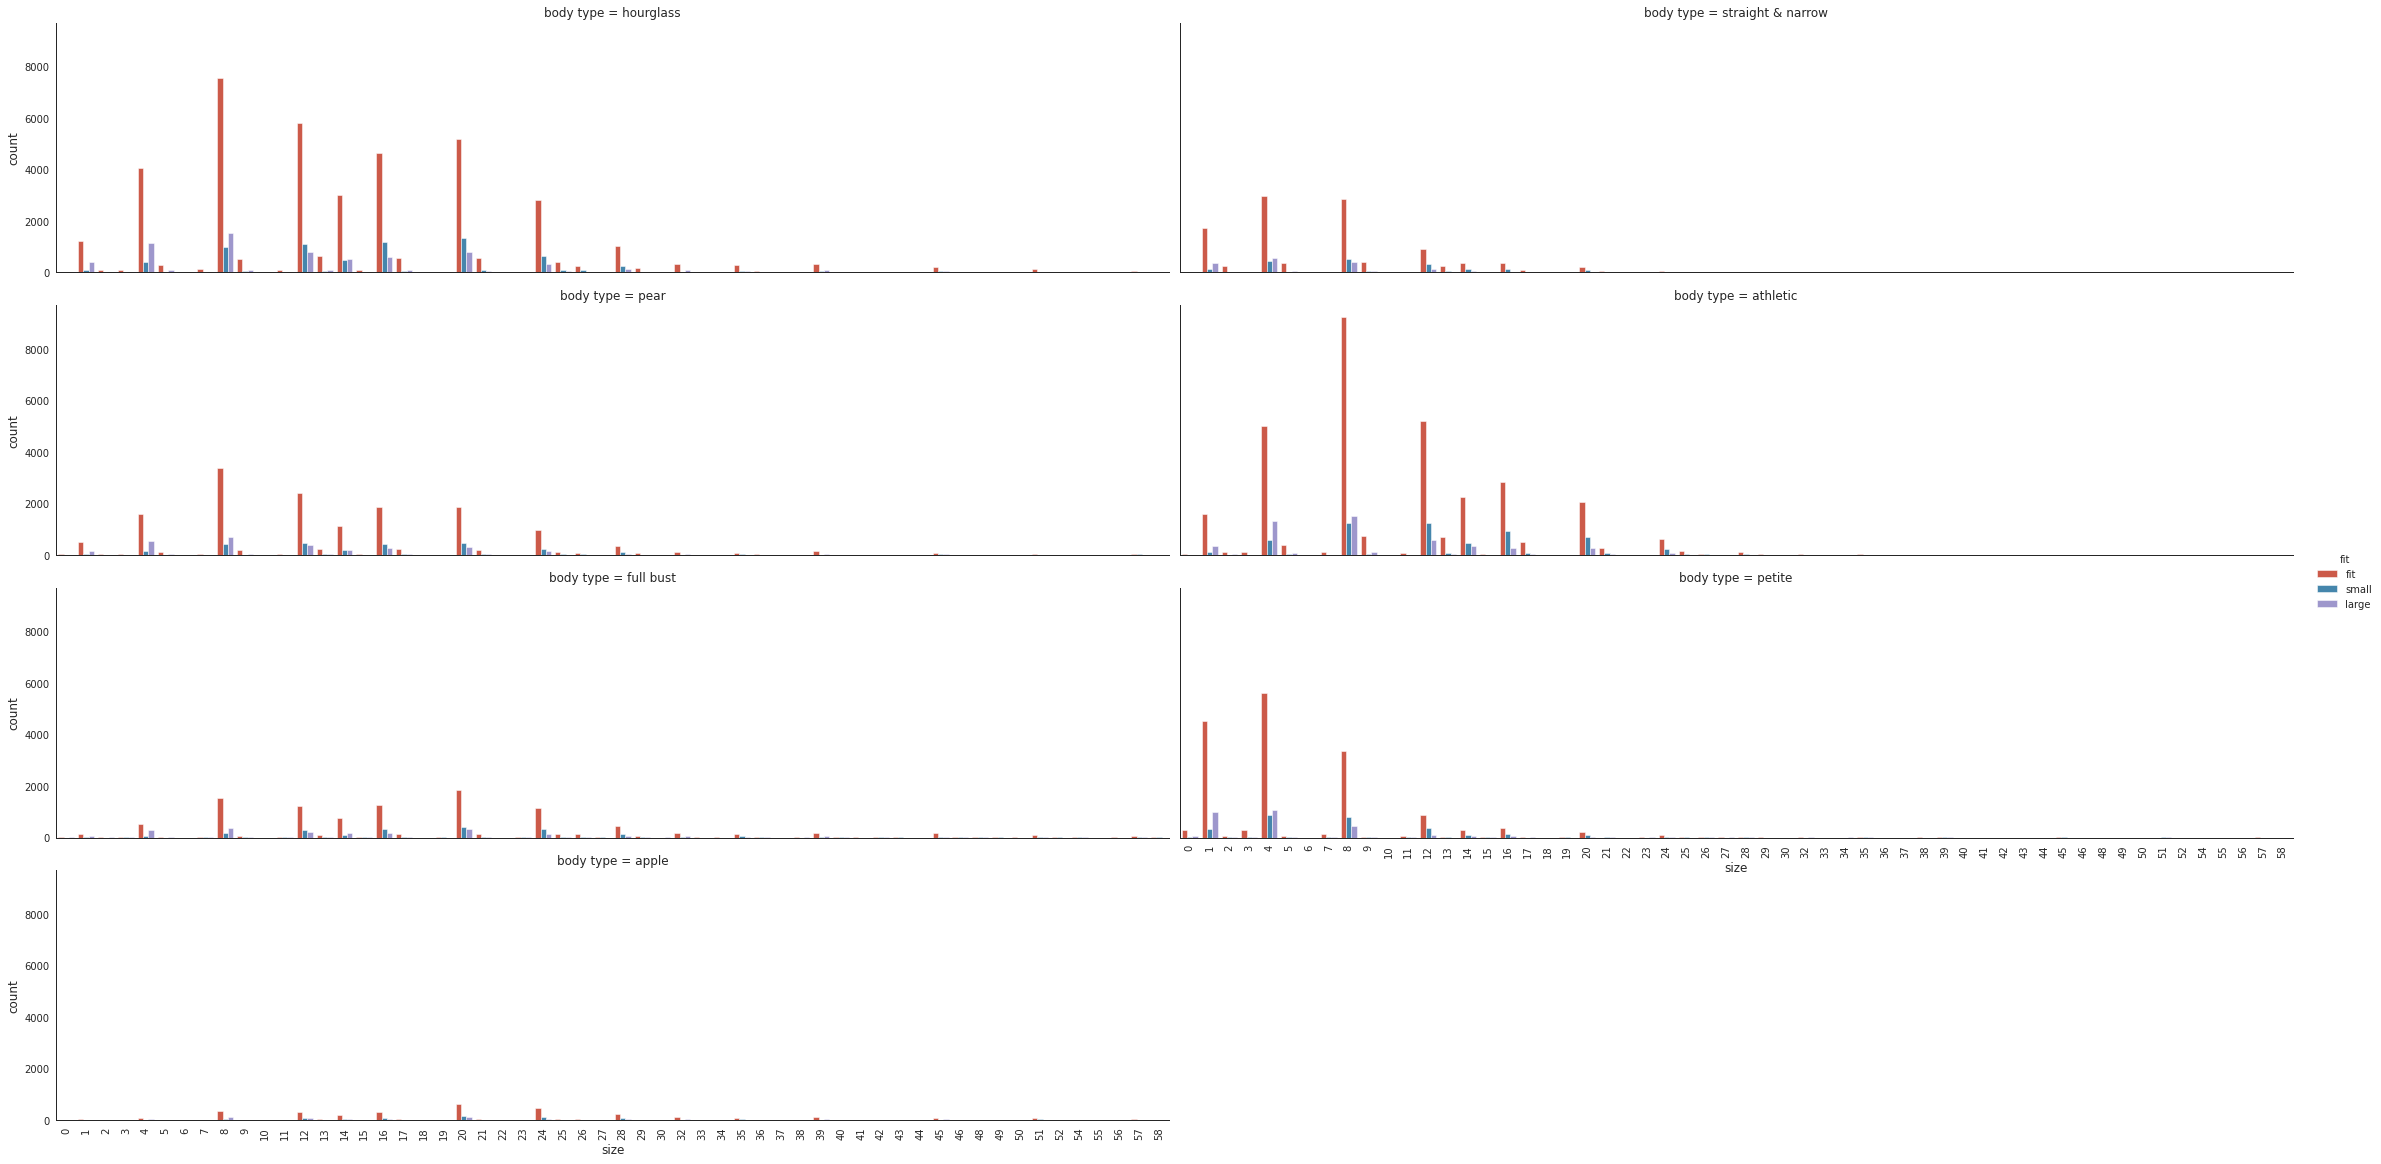

In [ ]:
g = sns.catplot(data=data_renttherunway_df, x='size',kind='count', hue='fit', col='body type', height=4, aspect=4, col_wrap=2)
g.set_xticklabels(rotation=90)

- From the above graphs, one thing is clear that any body type it be and any size it be, most of the fit feedback is 'Fit'.
- So, to impute the missing values of body type, as we have all the values for size, we can impute body type by mode of body type for current size.

In [ ]:
data_renttherunway_df=imputeBodyType(data_renttherunway_df)

- As we have imputed the unavailable body types, we can now see its relation with the various ratings that we have got.
- As in the case of ratings, we have got a scale from 1 to 5.
- Also, we have got the fit feedback.
- So, to ease things out, we are going to make another column called binary rating, i.e., either 1 or 0.
- It would be 1 in case it got a rating of 5 or 4 and a fit feedback as fit. All other entries would be considered as 0.

In [ ]:
bRating = (data_renttherunway_df["imputedRating"] == 5.0) | (data_renttherunway_df["imputedRating"] == 4.0) & (data_renttherunway_df["fit"] == "fit")
data_renttherunway_df["binary_rating"] = np.where(bRating == True, 1, 0)

- Now, we will be plotting a factor plot between imputed_bodyType and mean of the ratings (binary ratings) that the user has given.
- Lets plot the graphs for both imputed bodytype and bodytype to see if we have any stark differences.

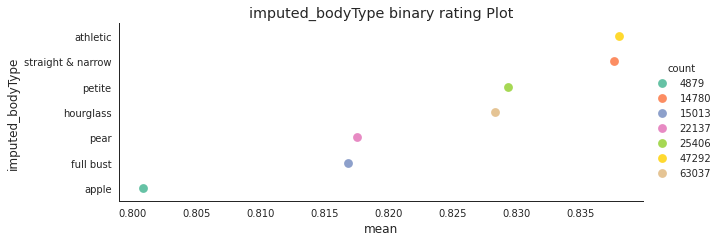

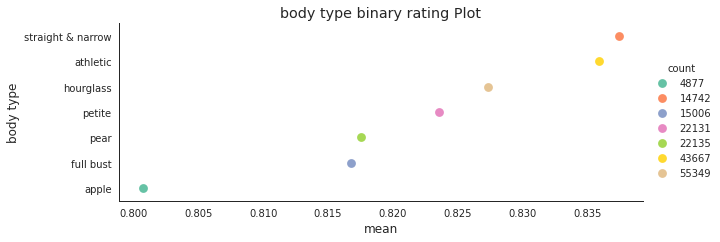

In [ ]:
vars = ["imputed_bodyType"]
plotFactorPlot(vars)
vars = ["body type"]
plotFactorPlot(vars)

- From the above plots, we can see that almost all body types are fairly close, except for Athletic body type which has got the highest mean for ratings.
- Not just that, it is almost true for all body types, be it imputed or original. This means that the imputed body type column also shows the same trend as of body type 

## **Category** (Rent the runway)

In [ ]:
print("Unique categories: {category:,}".format(category=data_renttherunway_df["category"].nunique()))

Unique categories: 68


In [ ]:
# data_renttherunway_df.groupby('category').size()
data_renttherunway_df['category'][data_renttherunway_df['category'].notnull()].value_counts(normalize=True,dropna=False).head(10)

dress       0.482404
gown        0.230498
sheath      0.100320
shift       0.027864
jumpsuit    0.026924
top         0.025610
maxi        0.017882
romper      0.015944
jacket      0.012485
mini        0.009094
Name: category, dtype: float64

In [ ]:
filterCategoriesWithMostData = data_renttherunway_df[((data_renttherunway_df['category'] == 'dress') | (data_renttherunway_df['category'] == 'gown') | (data_renttherunway_df['category'] == 'sheath') | (data_renttherunway_df['category'] == 'top') | (data_renttherunway_df['category'] == 'jumpsuit') | (data_renttherunway_df['category'] == 'romper') | (data_renttherunway_df['category'] == 'jacket') | (data_renttherunway_df['category'] == 'maxi') | (data_renttherunway_df['category'] == 'shift'))]

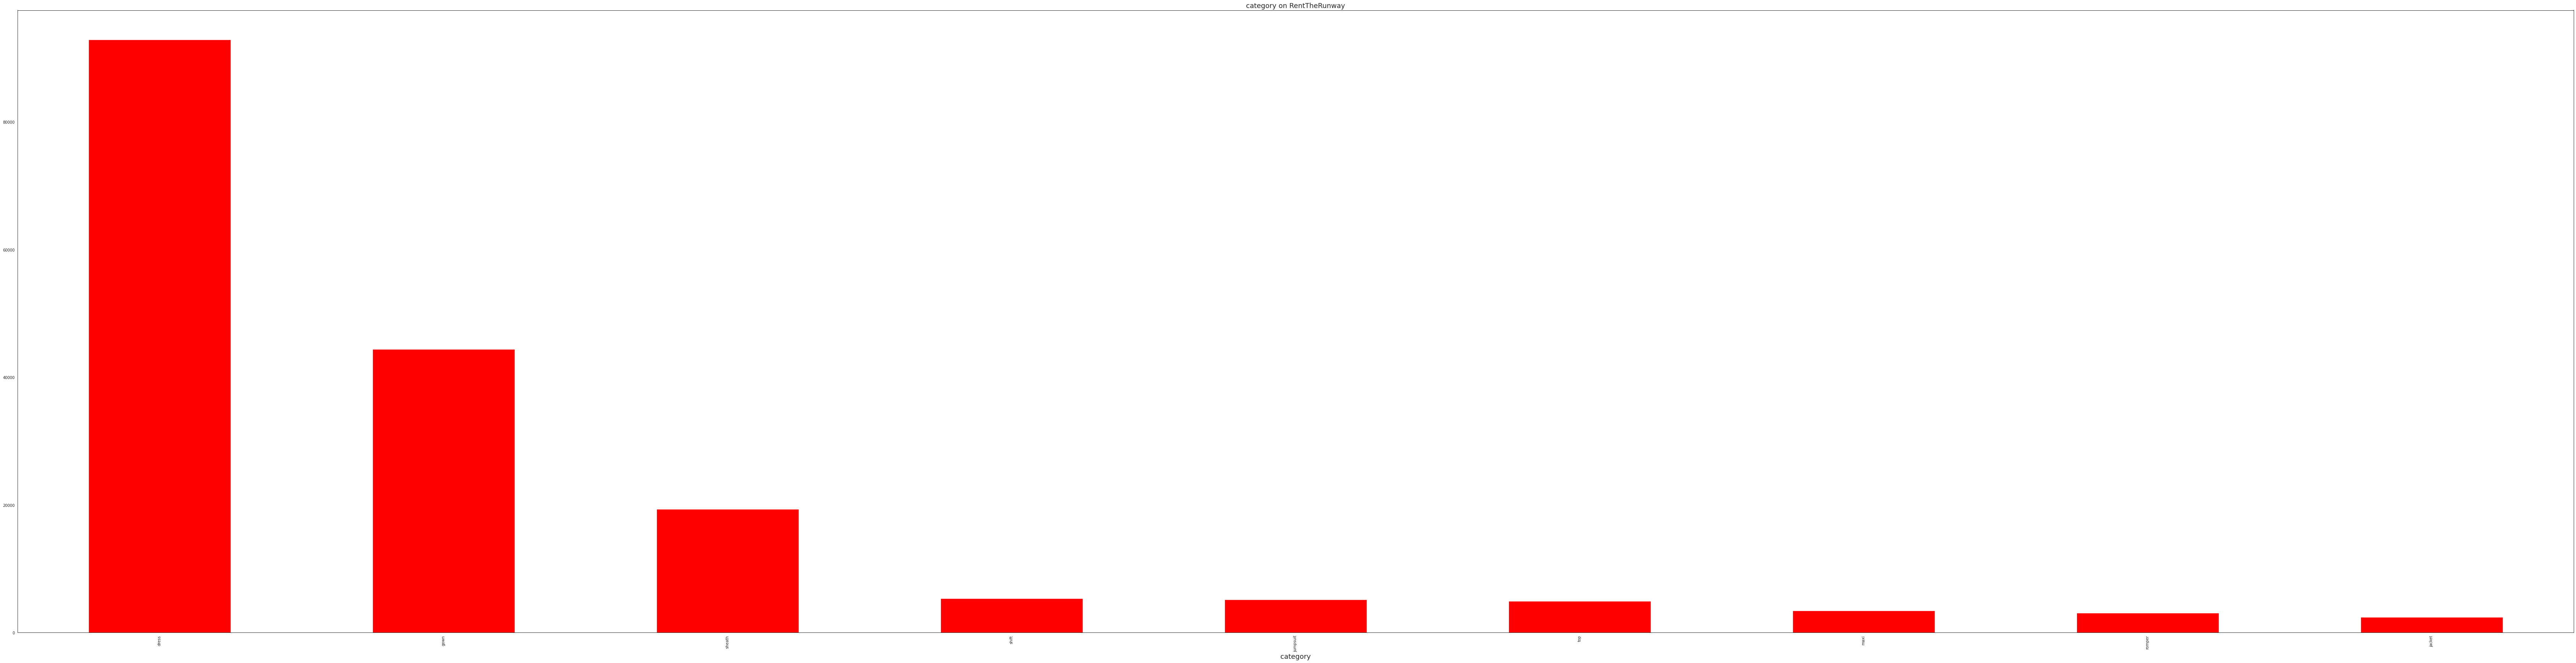

In [ ]:
fig, cx = plt.subplots(figsize = (120,30))
cols = ['category']
frequencyCountByValue(filterCategoriesWithMostData, cols[0],'RentTheRunway',cx)

- Although we have 68 categories defined in the dataset, but out of those, there are only 10 which are purchased around 90% of the time.
- Out of those 10, dresses are the one which are bought the most.
-Also, all the data is present for categories, so their is no imputation required.

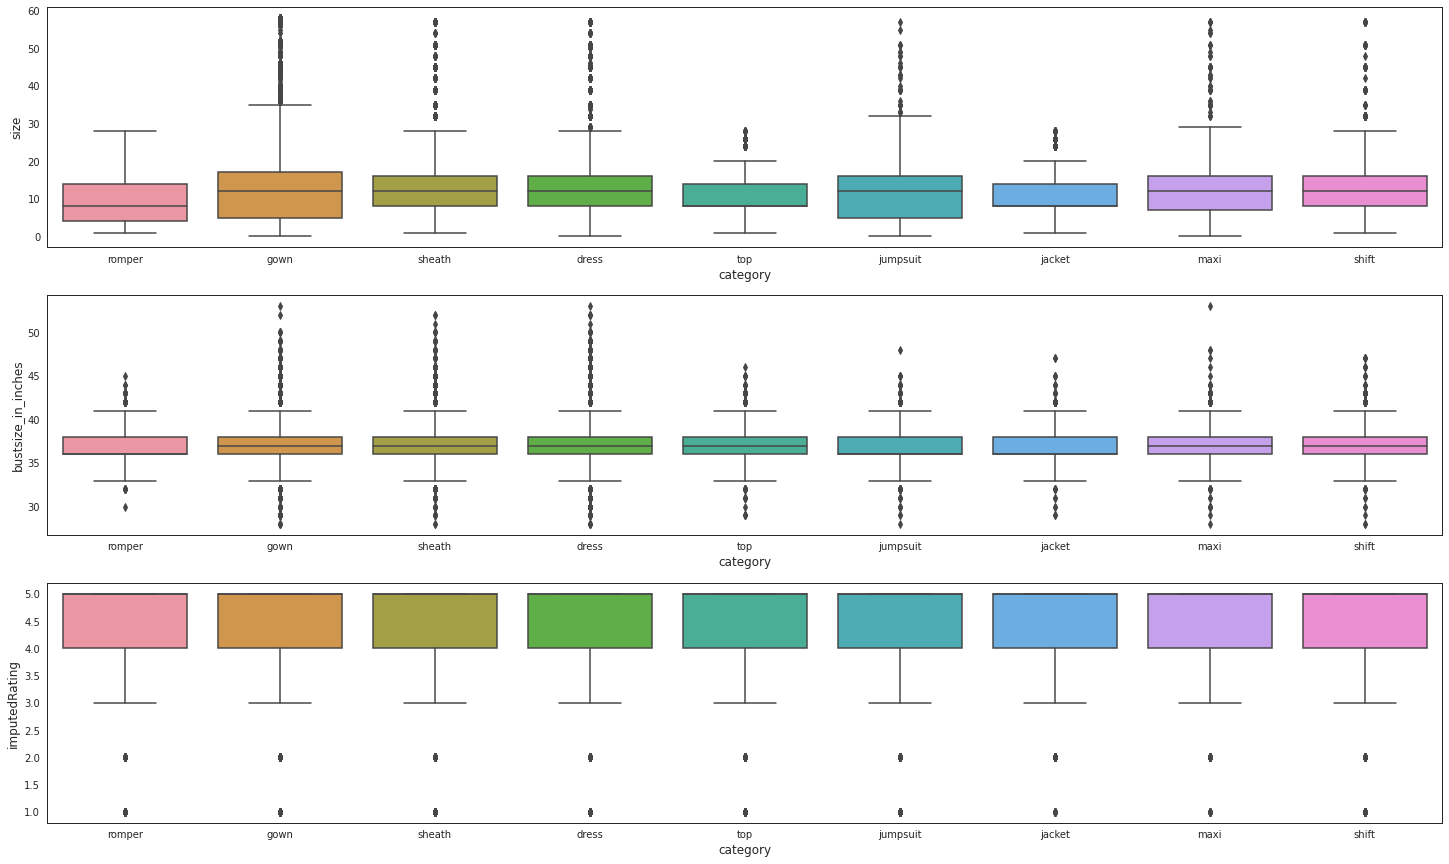

In [ ]:
f, axes = plt.subplots(3,1,figsize=(25,15))
sns.boxplot(x="category", y="size", data=filterCategoriesWithMostData, orient='v', ax=axes[0])
sns.boxplot(x="category", y="bustsize_in_inches", data=filterCategoriesWithMostData, orient='v', ax=axes[1])
sns.boxplot(x="category", y="imputedRating", data=filterCategoriesWithMostData, orient='v', ax=axes[2])

From the above graphs, we can deduce the following:
- Almost all the categories purchased are between size 5 and 15.
- For bust size in inches, although we do have outliers, but most of the values are between 35 and 40.
- The categories that have been bought the most have ratings 4 and above, and therefore are mostly given Fit feedback.

In [ ]:
g_by_category = filterCategoriesWithMostData.groupby('category')
cat_fit = g_by_category['fit'].value_counts()
cat_fit = cat_fit.unstack()
cat_fit_norm = norm_counts(cat_fit)
cat_fit_norm.drop(['fit'], axis=1, inplace=True)

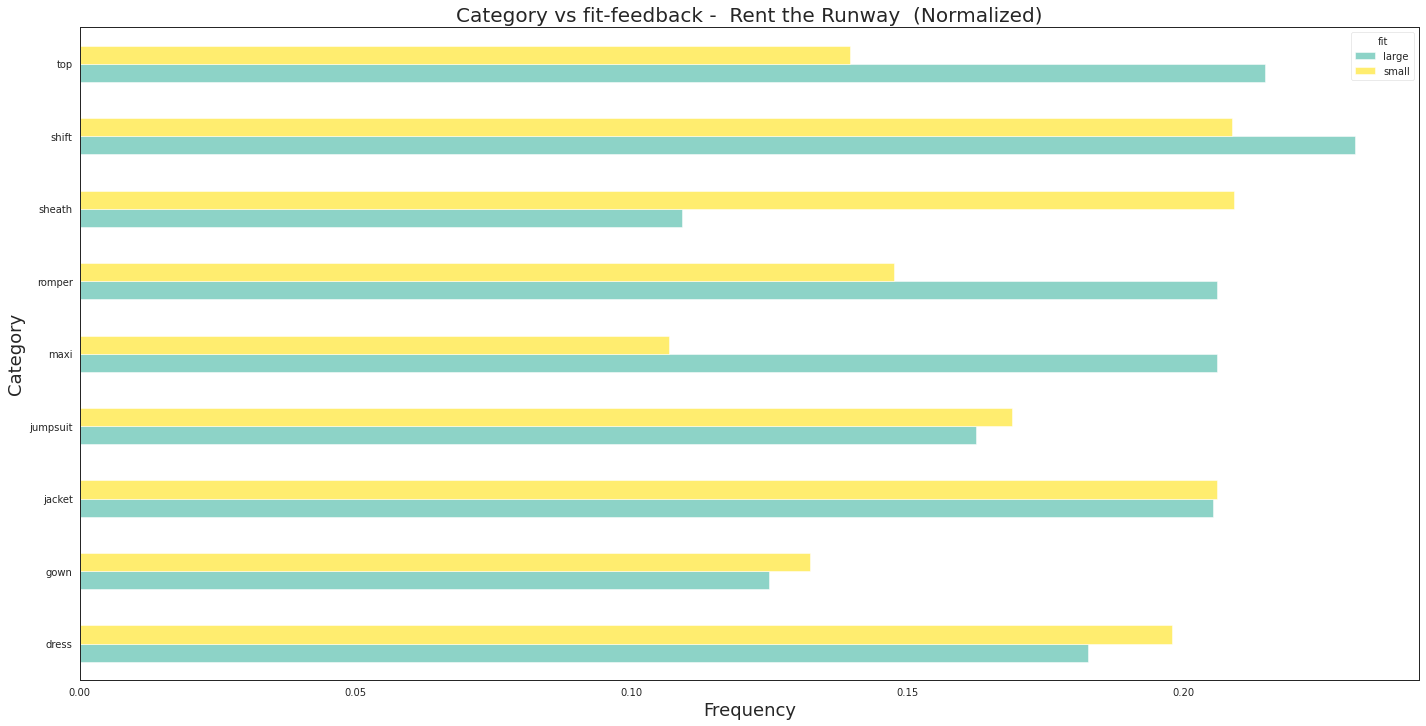

In [ ]:
plot_barhRR(cat_fit_norm, 'fit', norm=1, cmap='Set3')

- From the above we can see that for dresses, gowns, jackets, jumpsuits and shealth, people usually buy a smaller size. This might result into a return request.
- For tops, shifts, romper and maxi, people tend to buy a bigger size which can a reason for return in the future.

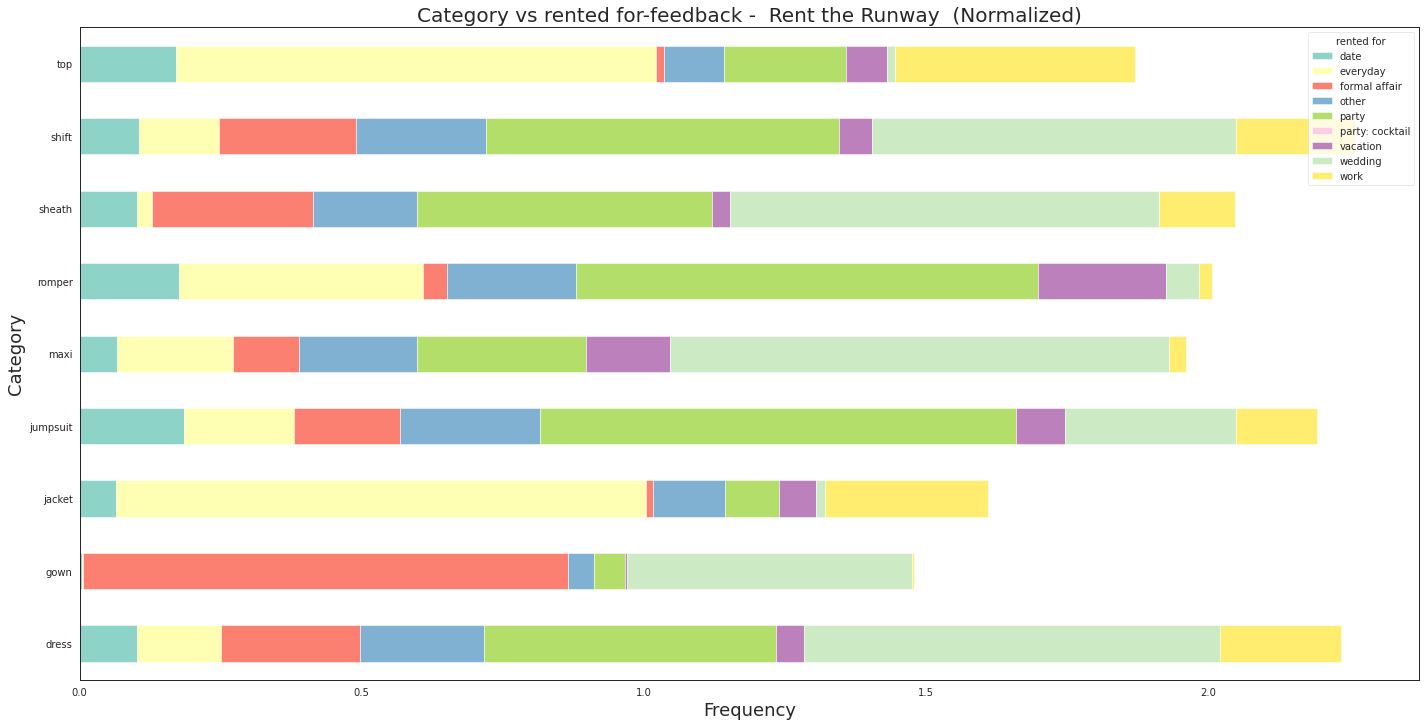

In [ ]:
cat_rentedfor = g_by_category['rented for'].value_counts()
cat_rentedfor = cat_rentedfor.unstack()
cat_rentedfor_norm = norm_counts(cat_rentedfor)
plot_barhRR(cat_rentedfor_norm, 'rented for', 'Set3', stacked=1, norm=1)

This is really an informative plot. This plot can be used for recommendations. Here we can see what category has been purchased for what kind of purpose.
- For a wedding a purchase of the following is made usually- shift, shealth,romper,jumpsuit,dress
- For a date- shift, shealth,maxi, dress.
- For everyday use- Jackets, rompers and tops.
- For formal affair- a gown.
- For a vacation- Maxi and romper.
- For work- Tops, jackets and dresses.


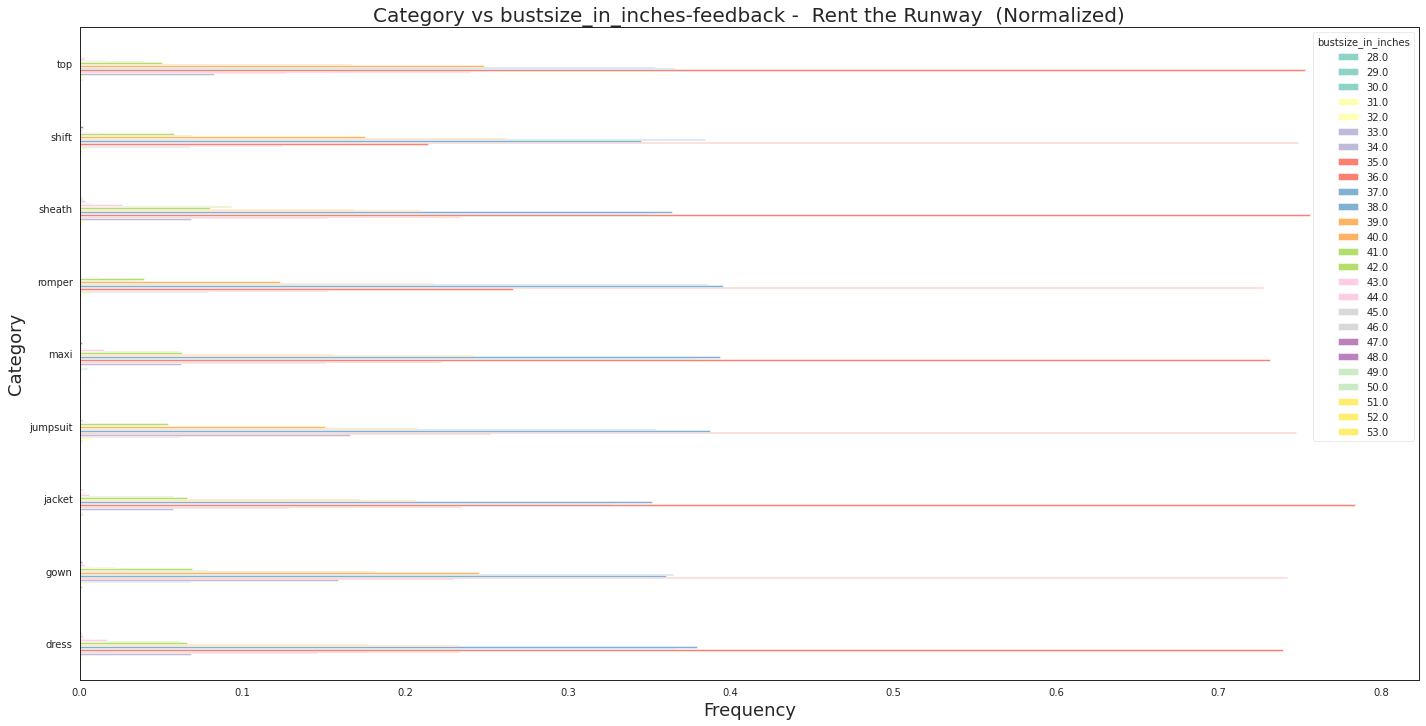

In [ ]:
cat_bust = g_by_category['bustsize_in_inches'].value_counts()
cat_bust = cat_bust.unstack()
cat_bust_norm = norm_counts(cat_bust)
plot_barhRR(cat_bust_norm, 'bustsize_in_inches', cmap='Set3', norm=1)

- The above plot can also be used for recommending categories. After a buyer puts in her bust size, it could be converted to inches, and then the most bought categories with that bustsize could be recommended to the buyer.